# 33150 PSET 4
# Giovanni Longo (12228450)

#### ChatGPT was used for basic function debugging and plotnine assistance.

#### Begin by importing necessary libraries and setting varibales.

In [1]:
from plotnine import aes
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import sys
from tqdm import tqdm
import statsmodels.api as sm
import functools
import seaborn as sns
import patchworklib as pw
import itertools
import plotnine as p9
import datetime
import os
import hashlib
import io
from matplotlib.image import imread

quandl.ApiConfig.api_key = '1n-fMYgMqmbySCU-zs6e'
start_date = '2016-01-01' 
end_date = '2023-06-30'

<Figure size 100x100 with 0 Axes>

#### This is a class to store all the optimal parameters we find as we work throughout our project. They will be explained as we go through the strategy.

In [125]:
class OptimalParameters:
    SAFE_THRESHOLD_PCT = 0
    RISKY_THRESHOLD_PCT = 0
    TAU = 0
    T = 0

#### First, we load in our tab delim data to load the entire data frames we will be analyzing. We are going to turn the price and quantity columns into a decimal based number for readability and operation ease.

In [3]:
def regularize_price_and_quantity(raw_df):
    df = raw_df.copy()
    
    df['PriceMillionths'] = df['PriceMillionths']/1_000_000
    df['SizeBillionths'] = df['SizeBillionths']/1_000_000_000
    
    df.rename(columns={'PriceMillionths': 'Price', 'SizeBillionths': 'Size'}, inplace=True)
    
    return df

In [4]:
# Define the relevant data frames
eth_btc_trade_df =  regularize_price_and_quantity(pd.read_csv('trades_narrow_ETH-BTC_2023.delim', sep='\t'))
btc_usd_trade_df =  regularize_price_and_quantity(pd.read_csv('trades_narrow_BTC-USD_2023.delim', sep='\t'))
eth_usd_trade_df =  regularize_price_and_quantity(pd.read_csv('trades_narrow_ETH-USD_2023.delim', sep='\t'))

In [5]:
eth_usd_trade_df

received_utc_nanoseconds  timestamp_utc_nanoseconds    Price  \
0            1674521275236165000        1674521271071902000  1629.67   
1            1674521275287511000        1674521271398509000  1629.77   
2            1674521275288004000        1674521271398509000  1629.78   
3            1674521275288470000        1674521271398509000  1629.79   
4            1674521275330683000        1674521271578052000  1629.77   
...                          ...                        ...      ...   
377180       1674658830284683000        1674658830318708000  1533.33   
377181       1674658830285405000        1674658830318708000  1533.34   
377182       1674658830287086000        1674658830319185000  1533.31   
377183       1674658830299074000        1674658830330265000  1533.31   
377184       1674658830328762000        1674658830376266000  1533.30   

            Size  Side  
0       0.011815    -1  
1       0.092159     1  
2       0.712595     2  
3       1.016994     2  
4       0.092150     1  
...          ...   ...  
377180  2.560936     1  
377181  5.056896     3  
377182  2.095787     1  
377183  1.181857     2  
377184  0.040724     1  

[377185 rows x 5 columns]

#### After loading in and organizing the raw data, we have to split the samples into training and testing sets. We will use the first 40% of the data as a training sample and the rest of the data frame for our out-of-sample testing. To avoid repetition, we have made a helper function that will split our data accordingly.

In [6]:
def split_data_into_training_and_testing(df, training_cutoff=0.4):
    '''
    Function that takes in a dataframe and splits it into a training sample (the first 40%) and 
    a testing sample (the remaining 60%).
    '''
    # We have made a copy of the data frame to avoid changing the original dataset
    df_copy = df.copy()
    split_point = int(len(df_copy) * training_cutoff)
    
    training_df = df.iloc[:split_point]
    testing_df = df.iloc[split_point:]
    
    return training_df, testing_df

In [7]:
eth_btc_trade_train, eth_btc_trade_test = split_data_into_training_and_testing(eth_btc_trade_df)
btc_usd_trade_train, btc_usd_trade_test = split_data_into_training_and_testing(btc_usd_trade_df)
eth_usd_trade_train, eth_usd_trade_test = split_data_into_training_and_testing(eth_usd_trade_df)

#### With our split data, we will now implement helper functions that allow us to find the trade flow and forward returns needed for our training sample.

In [91]:
# We will calculate the trade flow and forward return outside the TradeFlowStrategy
# class to have our data preloaded before entering the class
def consolidate_by_timestamp(df):
    consolidated_df = df.groupby('timestamp_utc_nanoseconds').agg({
        'Price': 'mean',
        'Size': 'sum', 
        'Side': 'sum'
    }).reset_index()
    
    consolidated_df['Side'] = np.sign(consolidated_df['Side'])
    
    return consolidated_df


def calculate_trade_flow(input_df, look_back_val):    
    df = input_df.copy()
    df.set_index('timestamp_utc_nanoseconds', inplace=True)
    look_back_val = look_back_val * (10**9)
    
    # Create a cumulative sum of the size * side to be used for later trade flow calculation.
    df['cum_sum_now'] = (df['Size'] * df['Side']).cumsum() 
    df['cum_sum_just_before'] = df['cum_sum_now'].shift(1)
    
    df_now = df[['cum_sum_now']].reset_index()
    # We need a shifted data frame in order to find the farthest tau-interval cumulative sum to subtract
    # from our cumulative sum in the period just before our observation (which yields the current tau
    # trade flow
    df_shifted = df_now.copy()
    df_shifted['timestamp_utc_nanoseconds'] = df_shifted['timestamp_utc_nanoseconds'] - look_back_val
    
    merged_df = pd.merge_asof(df_shifted.sort_values('timestamp_utc_nanoseconds'), 
                              df_now.sort_values('timestamp_utc_nanoseconds'), 
                              on='timestamp_utc_nanoseconds', direction='backward')
    
    df['cum_sum_tau_before'] = merged_df.set_index(df.index)['cum_sum_now_y']
    
    df['trade_flow'] = df['cum_sum_just_before'] - df['cum_sum_tau_before']
    
    df.drop(columns=['cum_sum_now', 'cum_sum_just_before', 'cum_sum_tau_before'], 
            axis=1, inplace=True)
    
    df.reset_index(inplace=True)
    df.rename(columns={'timestamp_utc_nanoseconds': 'timestamp'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    return df


def calculate_forward_returns(input_df, look_forward_val):
    df = input_df.copy()
    look_forward_val = look_forward_val * 10**9
    df['timestamp'] = df['timestamp'].astype('int64')
    df['timestamp'] = -df['timestamp']
    df.set_index('timestamp', inplace=True)
    
    df_now = df[['Price']].reset_index()

    df_shifted = df_now.copy()
    df_shifted['timestamp'] = df_shifted['timestamp'] - look_forward_val
    df_shifted['timestamp'] = df_shifted['timestamp'].astype('int64')
    
    # We have to set our 
    merged_df = pd.merge_asof(df_shifted.sort_values('timestamp'), 
                              df_now.sort_values('timestamp'), 
                              on='timestamp', direction='backward')
    
    merged_df['timestamp'] = -merged_df['timestamp']
    merged_df.sort_values(by='timestamp', inplace=True)
    merged_df.reset_index(inplace=True, drop=True)
    
    df.reset_index(inplace=True)
    df['timestamp'] = -df['timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['look_ahead_price'] = merged_df['Price_y']
    df.set_index('timestamp', inplace=True)
    
    df['forward_return'] = (df['look_ahead_price'] / df['Price']) - 1
    df.drop(columns = ['look_ahead_price'], axis=1, inplace=True)

    return df

In [9]:
tau, T = 10, 3
consolidated_eth_usd_trade_train = consolidate_by_timestamp(eth_usd_trade_train)
trade_flow_eth_usd_trade_train = calculate_trade_flow(consolidated_eth_usd_trade_train, tau)
trade_flow_eth_usd_trade_train

timestamp        Price      Size  Side  trade_flow
0     2023-01-24 00:47:51.071902  1629.670000  0.011815    -1         NaN
1     2023-01-24 00:47:51.398509  1629.780000  1.821748     1         NaN
2     2023-01-24 00:47:51.578052  1629.770000  0.092150     1         NaN
3     2023-01-24 00:47:51.660995  1629.795000  0.613560     1         NaN
4     2023-01-24 00:47:51.885174  1629.895000  0.480000     1         NaN
...                          ...          ...       ...   ...         ...
99014 2023-01-24 17:21:47.543946  1615.320000  0.173890     1    5.703458
99015 2023-01-24 17:21:47.833654  1615.320000  0.185720     1    5.878261
99016 2023-01-24 17:21:48.108631  1615.360000  0.501620     1    6.063981
99017 2023-01-24 17:21:48.229989  1615.425000  4.888522     1    6.565601
99018 2023-01-24 17:21:48.230081  1615.473333  3.497487     1   11.454123

[99019 rows x 5 columns]

In [10]:
finished_eth_usd_trade_train = calculate_forward_returns(trade_flow_eth_usd_trade_train, T).dropna()
finished_eth_usd_trade_train

Price      Size  Side  trade_flow  \
timestamp                                                             
2023-01-24 00:48:01.125719  1629.860000  0.360000     1    2.419784   
2023-01-24 00:48:02.228589  1629.860000  0.026130    -1   -0.129234   
2023-01-24 00:48:02.352417  1629.870000  0.006442     1   -0.155364   
2023-01-24 00:48:02.433917  1629.860000  0.038490    -1   -0.148922   
2023-01-24 00:48:02.472166  1629.855000  0.032530    -1   -0.187412   
...                                 ...       ...   ...         ...   
2023-01-24 17:21:42.301843  1615.110000  0.123779     1   -5.020589   
2023-01-24 17:21:43.292355  1614.875000  4.371570     1   -4.928825   
2023-01-24 17:21:44.106335  1614.983333  1.847999     1    1.479233   
2023-01-24 17:21:45.112978  1614.800000  0.032003    -1    3.327232   
2023-01-24 17:21:45.113559  1614.785000  0.746267    -1    3.295229   

                            forward_return  
timestamp                                   
2023-01-24 00:48:01.125719       -0.000221  
2023-01-24 00:48:02.228589       -0.000258  
2023-01-24 00:48:02.352417       -0.000258  
2023-01-24 00:48:02.433917       -0.000236  
2023-01-24 00:48:02.472166       -0.000233  
...                                    ...  
2023-01-24 17:21:42.301843       -0.000232  
2023-01-24 17:21:43.292355        0.000276  
2023-01-24 17:21:44.106335        0.000202  
2023-01-24 17:21:45.112978        0.000387  
2023-01-24 17:21:45.113559        0.000396  

[98974 rows x 5 columns]

In [11]:
consolidated_eth_usd_trade_test = consolidate_by_timestamp(eth_usd_trade_test)
finished_eth_usd_trade_test = calculate_trade_flow(consolidated_eth_usd_trade_test, tau).dropna()
finished_eth_usd_trade_test.set_index('timestamp', inplace=True)
finished_eth_usd_trade_test

Price      Size  Side  trade_flow
timestamp                                                          
2023-01-24 17:21:59.250078  1615.310000  0.001374    -1   -1.116909
2023-01-24 17:22:00.112202  1615.440000  0.099347     1   -1.015956
2023-01-24 17:22:00.317682  1615.466667  1.847532     1   -0.916609
2023-01-24 17:22:00.765753  1615.580000  2.600000    -1    0.927560
2023-01-24 17:22:00.799001  1615.580000  2.600000    -1   -1.672440
...                                 ...       ...   ...         ...
2023-01-25 15:00:30.318655  1533.320000  4.554000     1  -87.009370
2023-01-25 15:00:30.318708  1533.335000  7.617833     1  -82.455370
2023-01-25 15:00:30.319185  1533.310000  2.095787     1  -74.837538
2023-01-25 15:00:30.330265  1533.310000  1.181857     1  -72.741751
2023-01-25 15:00:30.376266  1533.300000  0.040724     1  -71.559894

[151218 rows x 4 columns]

## NOTE:

#### The above functions use the merge_asof operation, as the reindex operation requires EXACT matches in order to work properly. Pandas operations are much more efficient than using for loops, but they also come with some drawbacks. Notably, we do not have exactly what we want in terms of forward returns and trade flow because merge_asof finds the closest value that is at least tau/T away. I tried to find a workaround to this, but I was unable to use any vectorized operations to do so. I have opted to take this merge_asof approach because it is MUCH quicker and gets us sufficiently close to the values that we intend to use. Yes, there is some slight error, but it won't significantly change our regression (or trade flow) since trade prices will remain within a reasonable scope for our given intervals.

#### Other than this slight caveat, the functions above work as inteneded.

#### Now that we have the training and testing splits for the different crypto pairs, we will create the trade flow class to implement our trading strategy. We need to first find a weighting for the return predictions we will estimate in the testing set, which can found using a regression between $\tau$-interval trade flow and T-second forward returns. After we have found our associated beta, we will use a chosen threshold j to judge the effect of participating in an executed trade. Note that we are NOT actually entering any trades ourselves, but are rather deciding whether entering a trade position aligned with our return prediction would have been profitable.

In [12]:
class TradeFlowStrategy:
    def __init__(self, training_data, testing_data, threshold, trading_cost=0, make_pred=True):
        self.training_data = training_data
        self.testing_data = testing_data
        self.threshold = threshold
        self.trading_cost = trading_cost
        
        # Regression variable
        self.beta = 0   
        
        # Trade variables
        self.trade_pnl = 0
        self.cumulative_pnl =  0
        self.quantity_held = 0
        self.cumulative_trading_cost = 0
        self.trading_log = pd.DataFrame()
        
        self.make_pred = make_pred
        
        
    def find_regression_beta(self):
        df = self.training_data
        
        X = df['trade_flow']
        y = df['forward_return']
        
        model = sm.OLS(y, X).fit()
        
        self.beta = model.params[0]
    
    
    def calculate_trade_pnl(self, price):
        if not self.trading_log.empty:
            previous_price = self.trading_log['trade_price'].iloc[-1]
            self.trade_pnl = (price - previous_price) * self.quantity_held
    
    
    def update_trading_log(self, timestamp, side, size, price, trade_amount):
        new_entry = {
            'time':timestamp, 
            'trade_side':side, 
            'trade_size':size,
            'trade_price':price,
            'trade_amount': trade_amount,
            'quantity_held': self.quantity_held,
            'total_trading_cost': self.cumulative_trading_cost,
            'trade_pnl':self.trade_pnl,
            'total_pnl':self.cumulative_pnl
        }
    
        new_row = pd.DataFrame([new_entry])
        self.trading_log = pd.concat([self.trading_log, new_row], ignore_index=True)
    
    
    def execute_trade(self, curr_row, time):
        side = 'bid' if np.sign(curr_row['return_predictions'][0]) == 1 else 'offer'
        
        # As mentioned in class, we have chosen a reasonable proportion of the last trade 
        # to call our quantity traded (5%)
        quantity = curr_row['Size'][0] * 0.05
        trade_amount = curr_row['Price'][0] * quantity
        trade_price = curr_row['Price'][0]
        
        self.calculate_trade_pnl(trade_price)
        self.trade_pnl -= (self.trading_cost * quantity)

        self.cumulative_pnl += self.trade_pnl
        self.cumulative_trading_cost += (self.trading_cost * quantity)
        
        if side == 'bid':
            self.quantity_held += quantity
        else:
            self.quantity_held -= quantity
            
        self.update_trading_log(
            time, 
            side, 
            quantity,
            trade_price, 
            trade_amount
        )
        
    
    def make_return_predictions(self):
        self.find_regression_beta()
        self.testing_data['return_predictions'] = self.beta * self.testing_data['trade_flow']
    
    
    def run_strategy(self):
        if self.make_pred:
            self.make_return_predictions()
        final_date = self.testing_data.index[-1]
        
        for time in tqdm(self.testing_data.index, desc='Running strategy on testing set'):
            curr_row = self.testing_data[self.testing_data.index == time]
            if time != final_date:
                return_pred = curr_row['return_predictions'].iloc[0]
                print(return_pred)
                if abs(return_pred) > self.threshold:
                    self.execute_trade(curr_row, time)
            # Make sure to liquidate the position at the last timestamp
            else:
                final_price = curr_row['Price'][0]
                self.calculate_trade_pnl(final_price)
                self.trade_pnl -= (self.trading_cost * self.quantity_held)
                
                self.cumulative_pnl += self.trade_pnl
                self.cumulative_trading_cost += (self.trading_cost * self.quantity_held)
                
                side = 'bid' if np.sign(np.sign(self.quantity_held)) == -1 else 'offer'
                size = self.quantity_held
                self.quantity_held = 0
                
                self.update_trading_log(
                    time, 
                    side,
                    size,
                    final_price, 
                    self.quantity_held * final_price
                )
                
        self.trading_log.set_index('time', inplace=True)

In [13]:
first_trade_threshold = 10**(-5)
first_attempt_tfs = TradeFlowStrategy(finished_eth_usd_trade_train, finished_eth_usd_trade_test, first_trade_threshold, 0.00001)
first_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 151218/151218 [00:52<00:00, 2907.14it/s]


In [14]:
first_attempt_tfs.trading_log

trade_side  trade_size  trade_price  trade_amount  \
time                                                                           
2023-01-24 17:22:46.943065      offer    0.331895     1616.000    536.342687   
2023-01-24 17:22:46.943076      offer    3.073368     1616.000   4966.562673   
2023-01-24 17:22:46.943113      offer    0.463585     1616.000    749.153895   
2023-01-24 17:22:46.950673      offer    0.053549     1616.000     86.535184   
2023-01-24 17:22:46.961152      offer    0.058723     1615.990     94.895781   
...                               ...         ...          ...           ...   
2023-01-25 15:00:30.318655        bid    0.227700     1533.320    349.136970   
2023-01-25 15:00:30.318708        bid    0.380892     1533.335    584.034468   
2023-01-25 15:00:30.319185        bid    0.104789     1533.310    160.674528   
2023-01-25 15:00:30.330265        bid    0.059093     1533.310     90.607661   
2023-01-25 15:00:30.376266      offer   75.313092     1533.300      0.000000   

                            quantity_held  total_trading_cost     trade_pnl  \
time                                                                          
2023-01-24 17:22:46.943065      -0.331895            0.000003 -3.318952e-06   
2023-01-24 17:22:46.943076      -3.405263            0.000034 -3.073368e-05   
2023-01-24 17:22:46.943113      -3.868849            0.000039 -4.635853e-06   
2023-01-24 17:22:46.950673      -3.922398            0.000039 -5.354900e-07   
2023-01-24 17:22:46.961152      -3.981121            0.000040  3.922339e-02   
...                                   ...                 ...           ...   
2023-01-25 15:00:30.318655      74.768318            0.012020  1.863515e+01   
2023-01-25 15:00:30.318708      75.149209            0.012024  1.121521e+00   
2023-01-25 15:00:30.319185      75.253999            0.012025 -1.878731e+00   
2023-01-25 15:00:30.330265      75.313092            0.012026 -5.909285e-07   
2023-01-25 15:00:30.376266       0.000000            0.012779 -7.538840e-01   

                              total_pnl  
time                                     
2023-01-24 17:22:46.943065    -0.000003  
2023-01-24 17:22:46.943076    -0.000034  
2023-01-24 17:22:46.943113    -0.000039  
2023-01-24 17:22:46.950673    -0.000039  
2023-01-24 17:22:46.961152     0.039184  
...                                 ...  
2023-01-25 15:00:30.318655 -4260.349169  
2023-01-25 15:00:30.318708 -4259.227648  
2023-01-25 15:00:30.319185 -4261.106379  
2023-01-25 15:00:30.330265 -4261.106380  
2023-01-25 15:00:30.376266 -4261.860264  

[10318 rows x 8 columns]

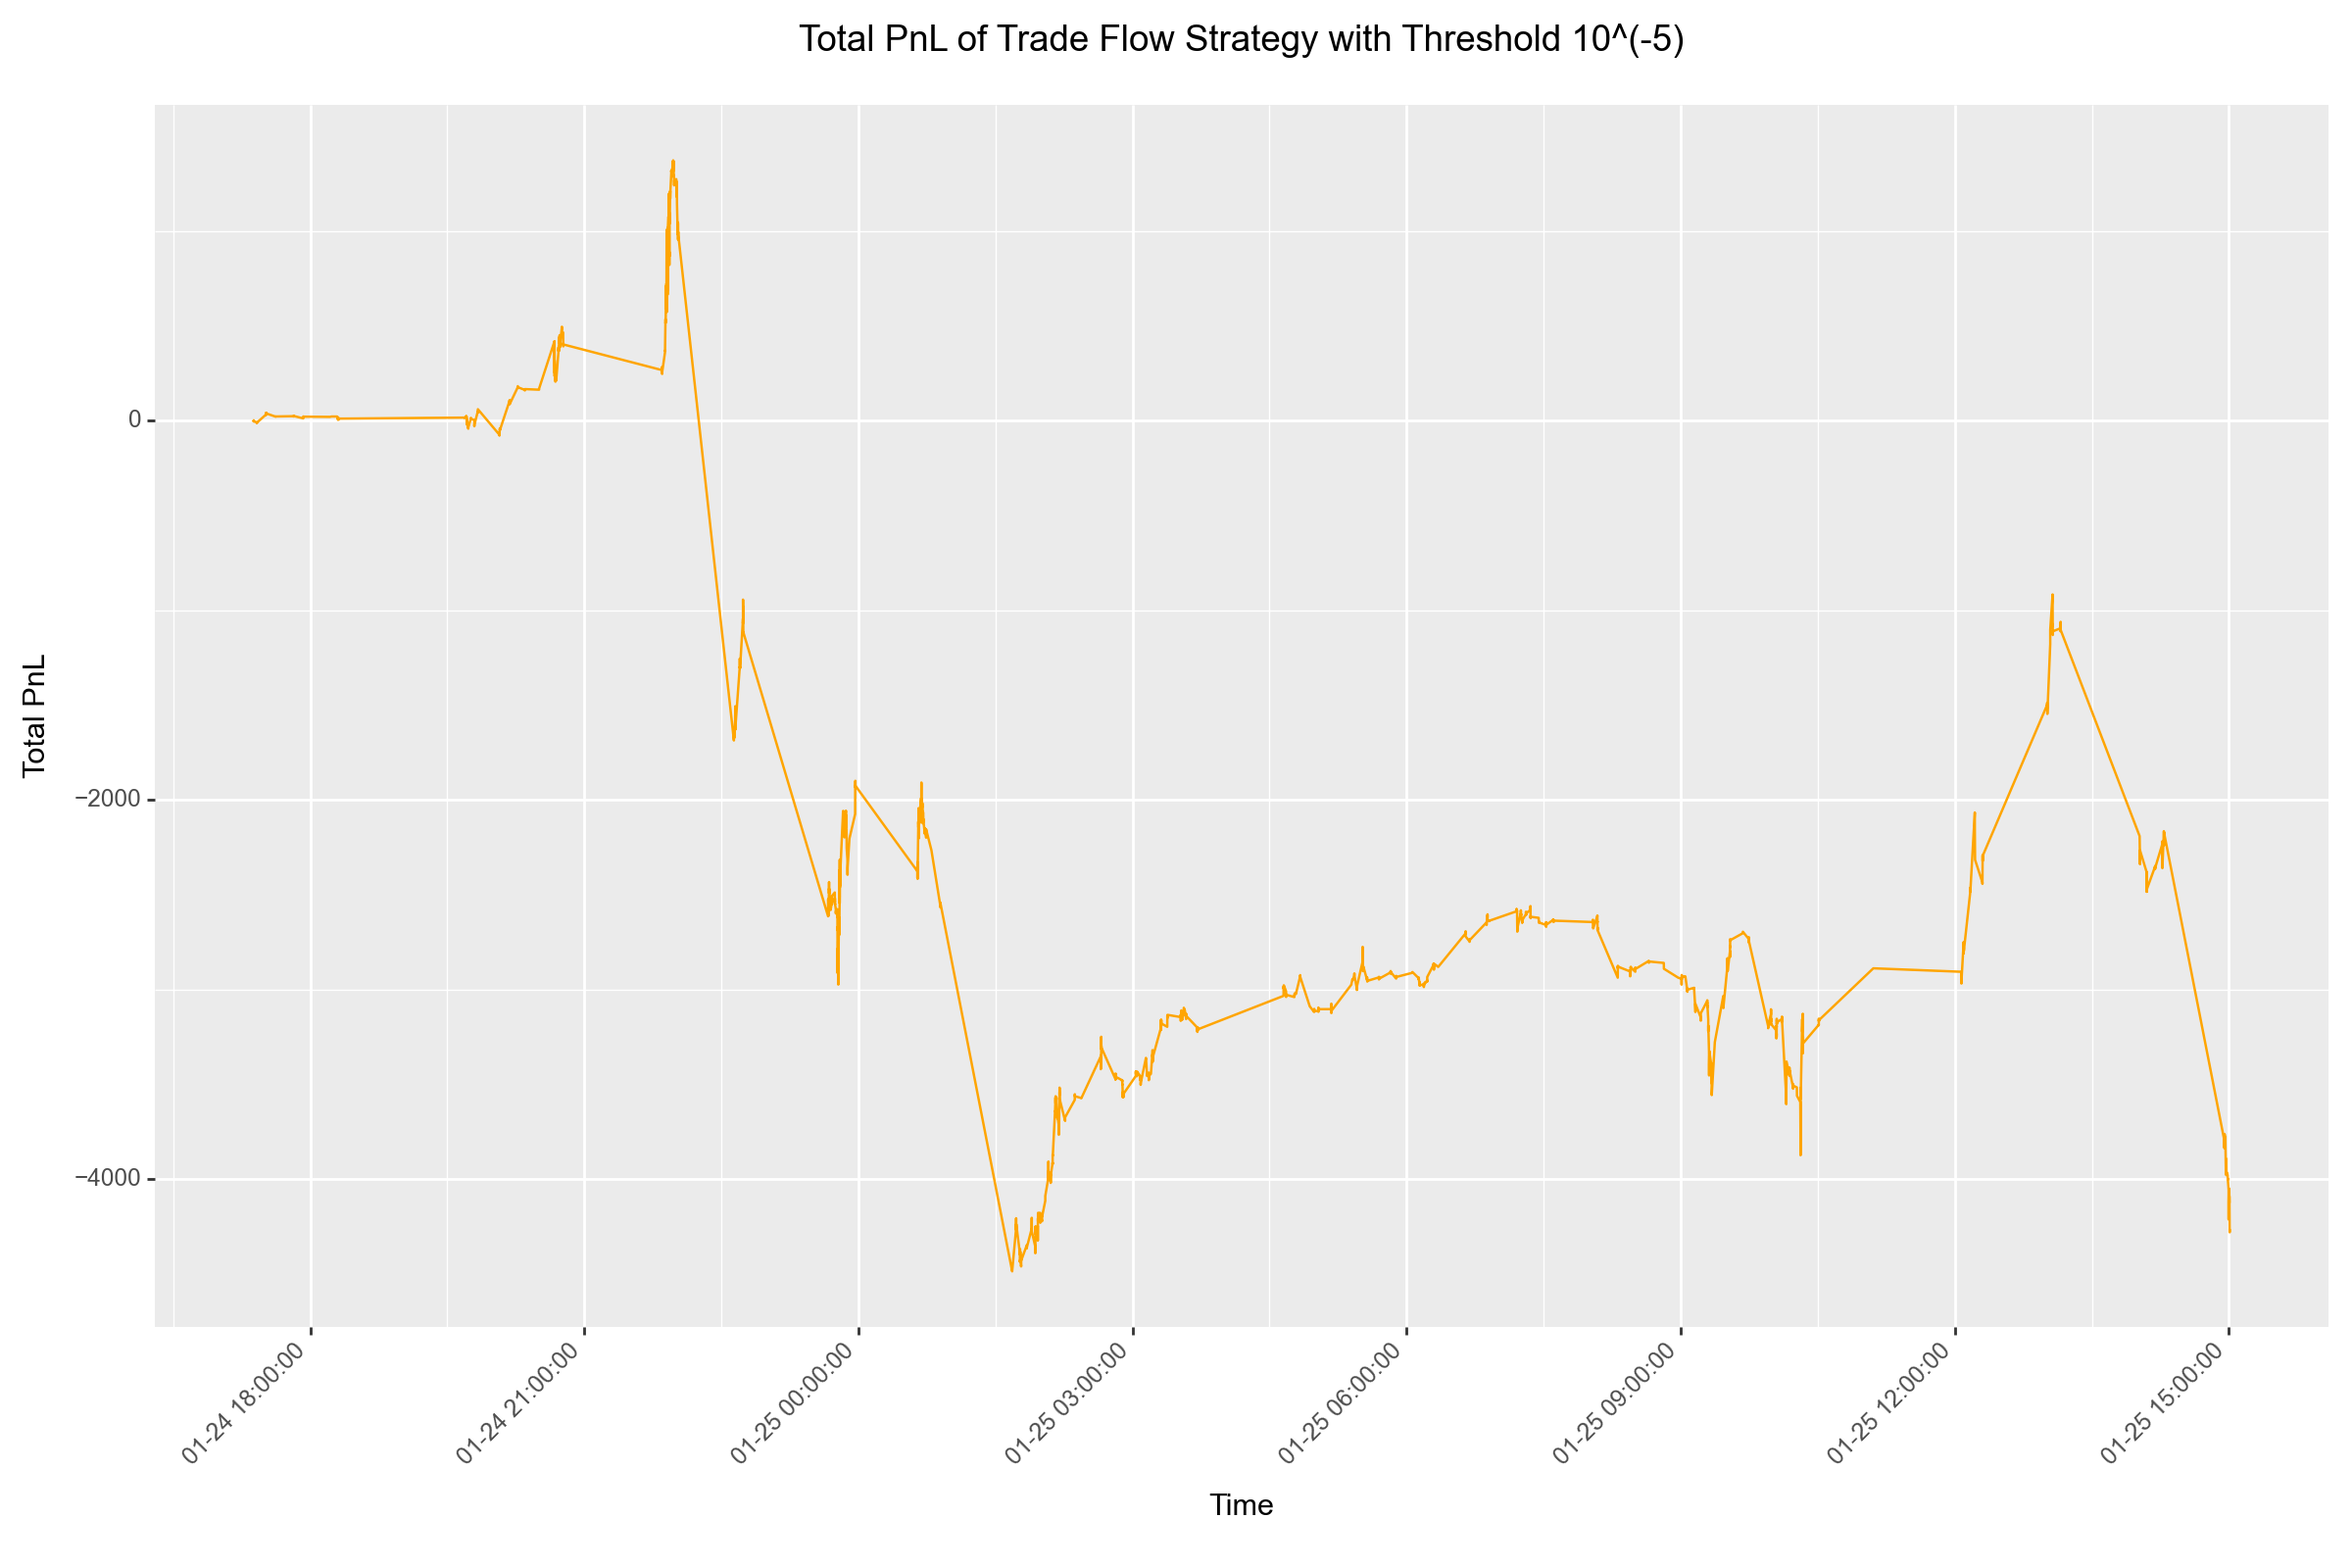

In [15]:
df = first_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

first_attempt_pnl_plot = (p9. ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title='Total PnL of Trade Flow Strategy with Threshold 10^(-5)',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

first_attempt_pnl_plot.draw()

#### As we can see, the first attempt at a strategy traded over 10,000 times and had a overall PnL of about -4261 by the last trading day. Obviously, this is not desirable, so we will explore tweaking a few of the existing parameters to see if we can adjust this overall PnL in our favor. We will start with the ETH-USD data and will test the other data sets later if we can discern a useful set of trading parameters. The first parameter we will tweak is the threshold, j. We have started with a threshold that captures about 7% of all trading opportunities, so let us first adjust our j to include more trading opportunities to see if this fixes our PnL.

In [16]:
second_trade_threshold = 10**(-6)
second_attempt_tfs = TradeFlowStrategy(finished_eth_usd_trade_train, finished_eth_usd_trade_test, second_trade_threshold, 0.00001)
second_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 151218/151218 [02:53<00:00, 869.52it/s] 


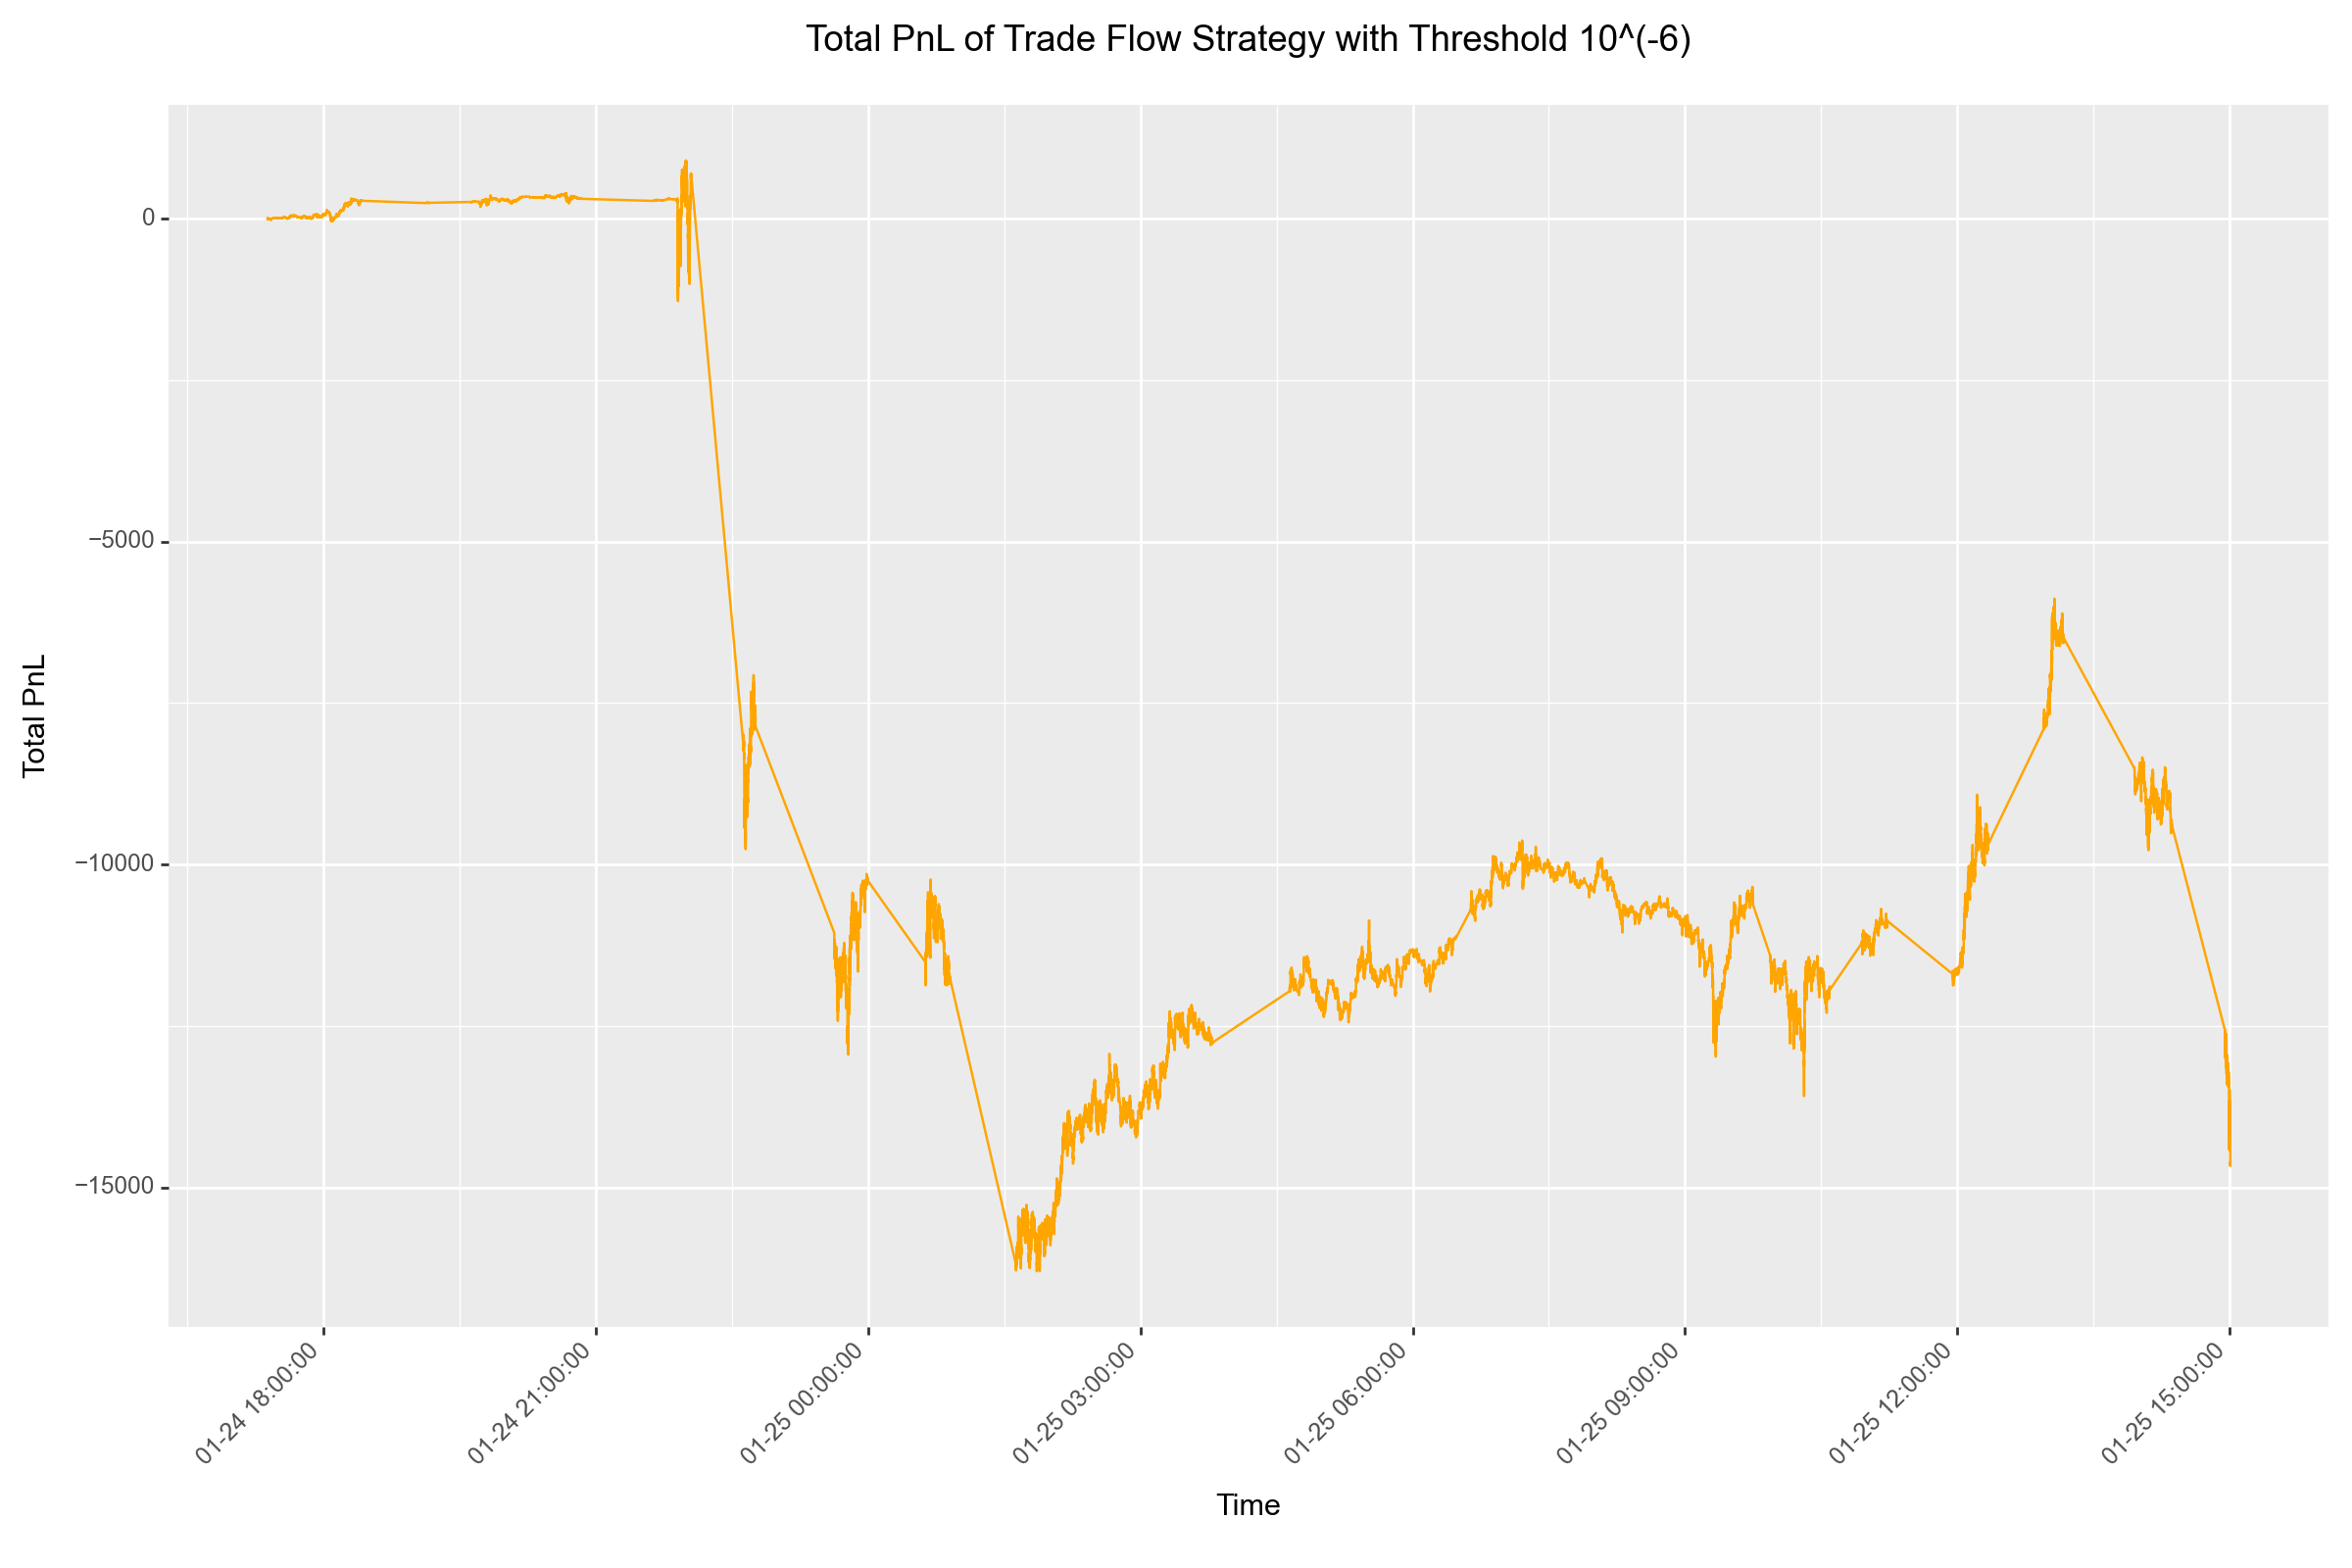

In [17]:
df = second_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

second_attempt_pnl_plot = (p9. ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title='Total PnL of Trade Flow Strategy with Threshold 10^(-6)',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

second_attempt_pnl_plot.draw()

In [18]:
third_trade_threshold = 5*10**(-6)

third_attempt_tfs = TradeFlowStrategy(finished_eth_usd_trade_train, finished_eth_usd_trade_test, third_trade_threshold, 0.00001)
third_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 151218/151218 [01:07<00:00, 2239.38it/s]


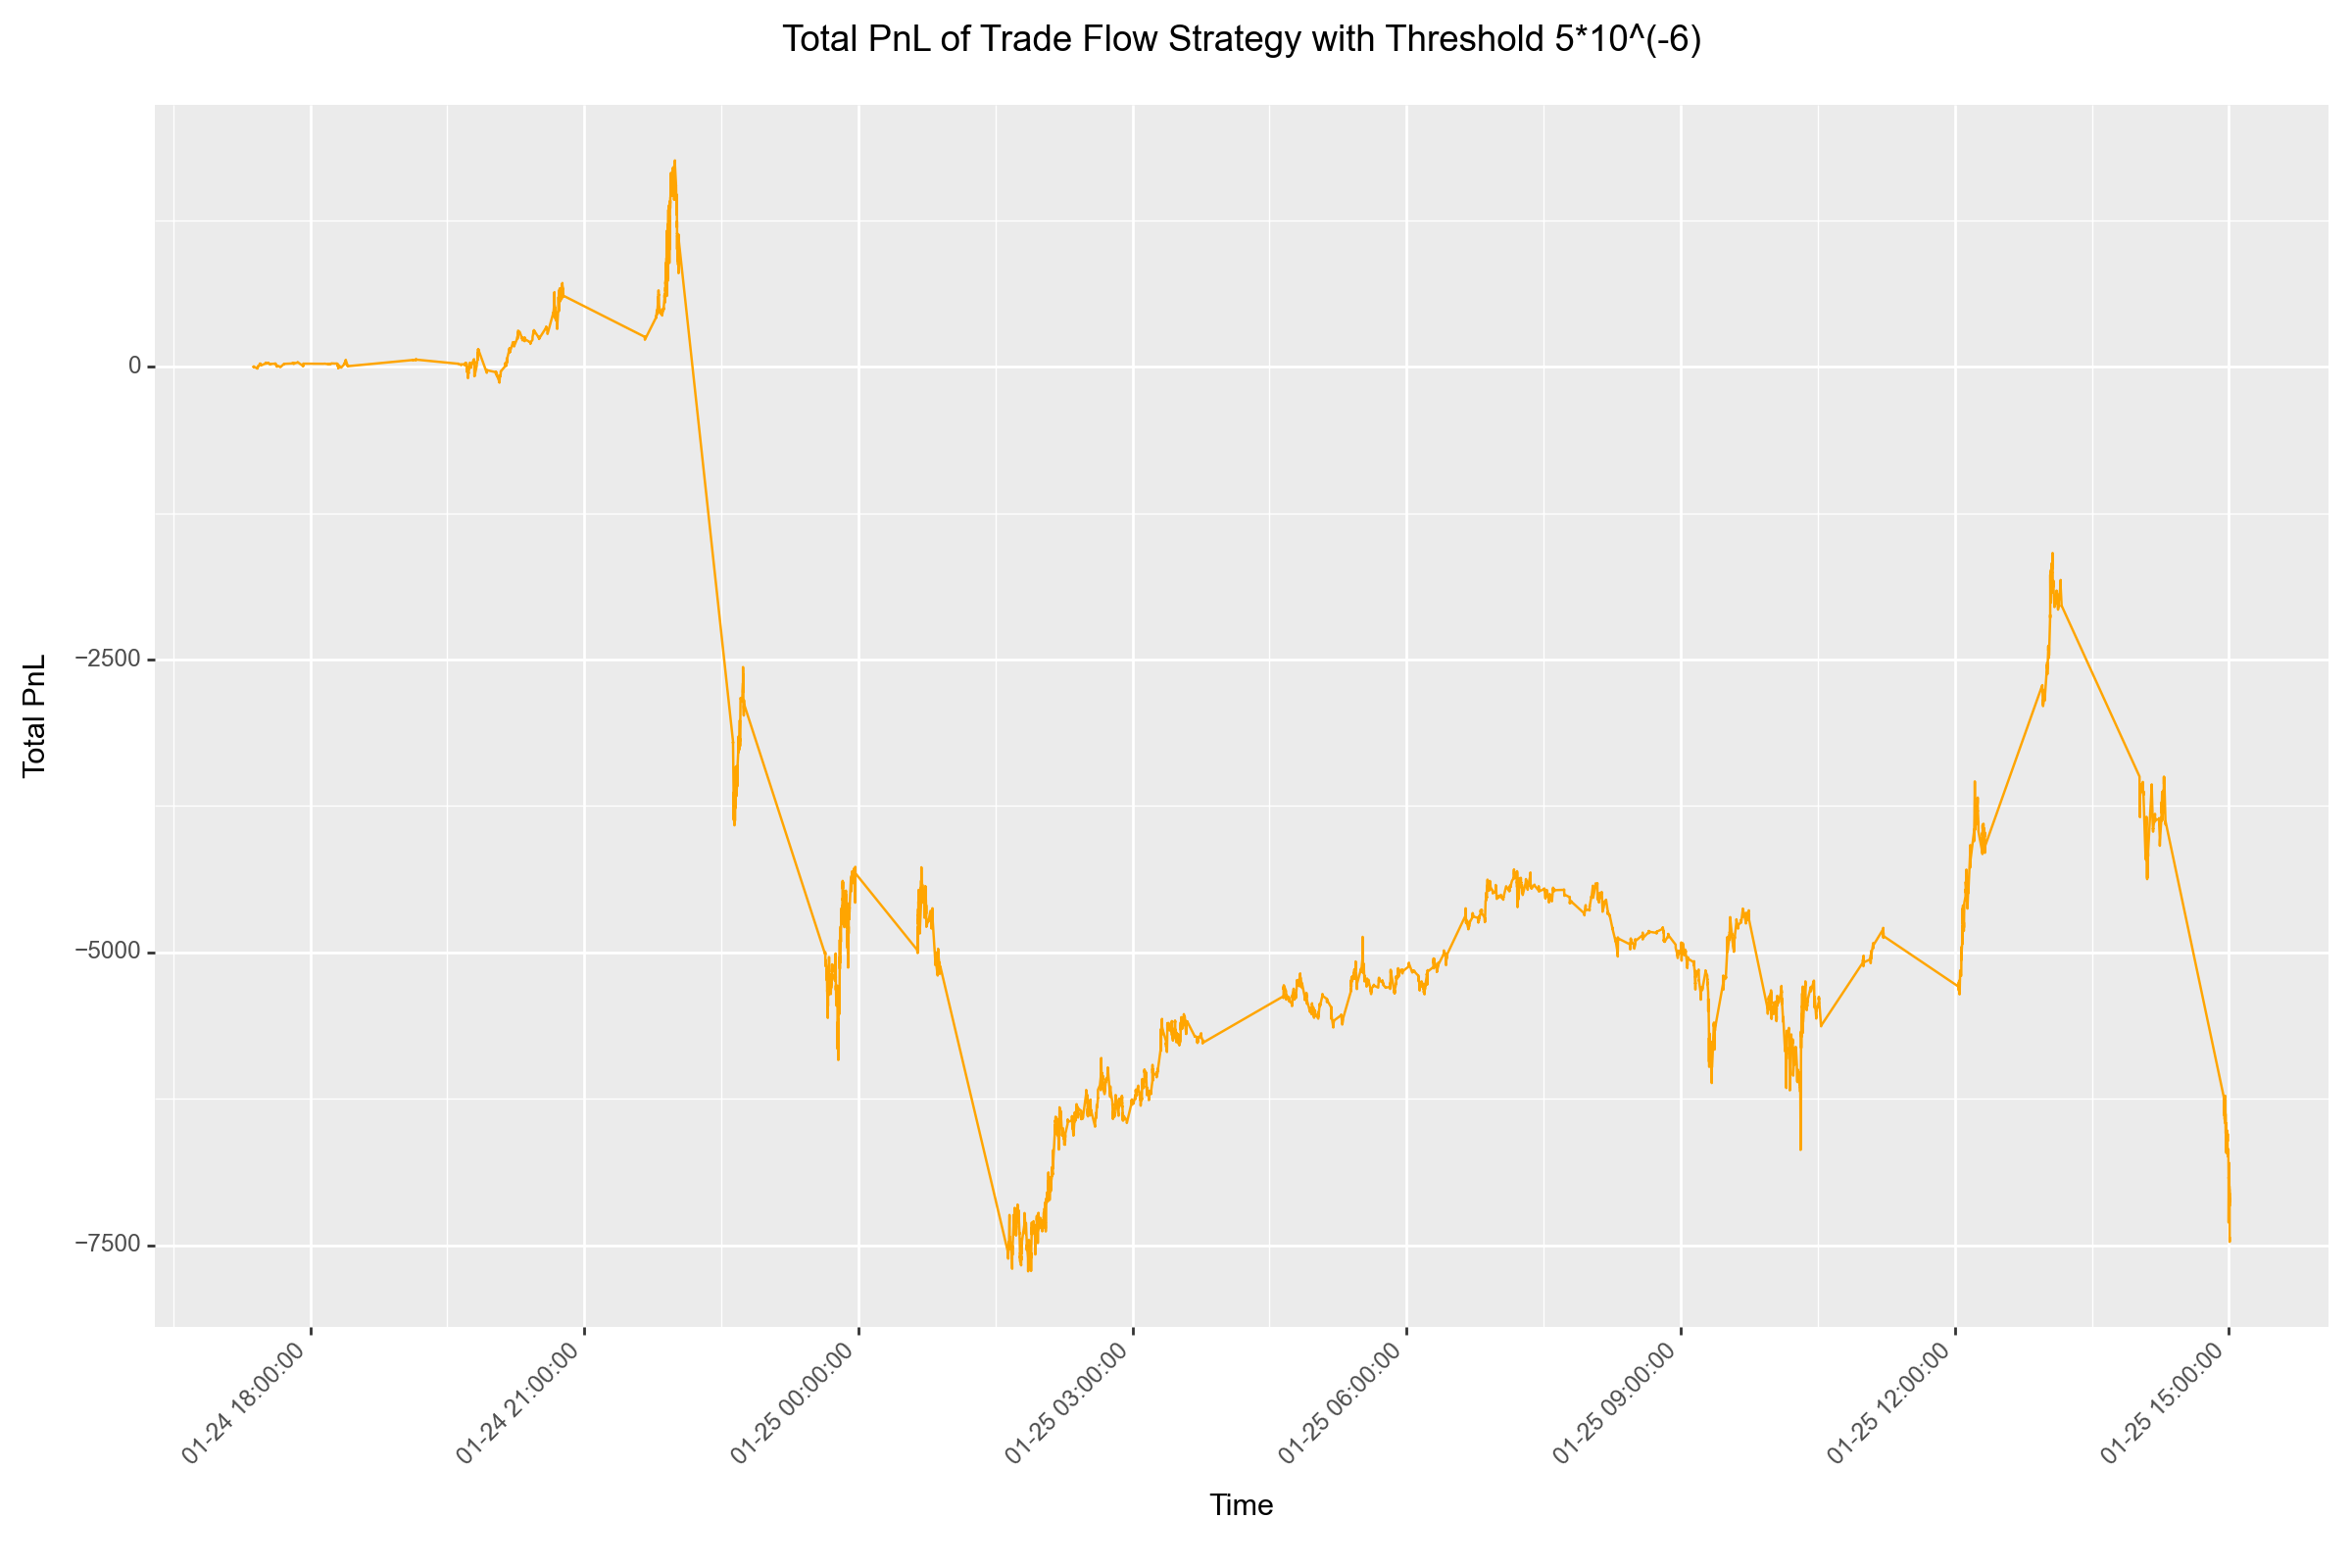

In [19]:
df = third_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

third_attempt_pnl_plot = (p9. ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title='Total PnL of Trade Flow Strategy with Threshold 5*10^(-6)',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

third_attempt_pnl_plot.draw()

In [20]:
fourth_trade_threshold = 3*10**(-5)

fourth_attempt_tfs = TradeFlowStrategy(finished_eth_usd_trade_train, finished_eth_usd_trade_test, fourth_trade_threshold, 0.00001)
fourth_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 151218/151218 [00:46<00:00, 3239.59it/s]


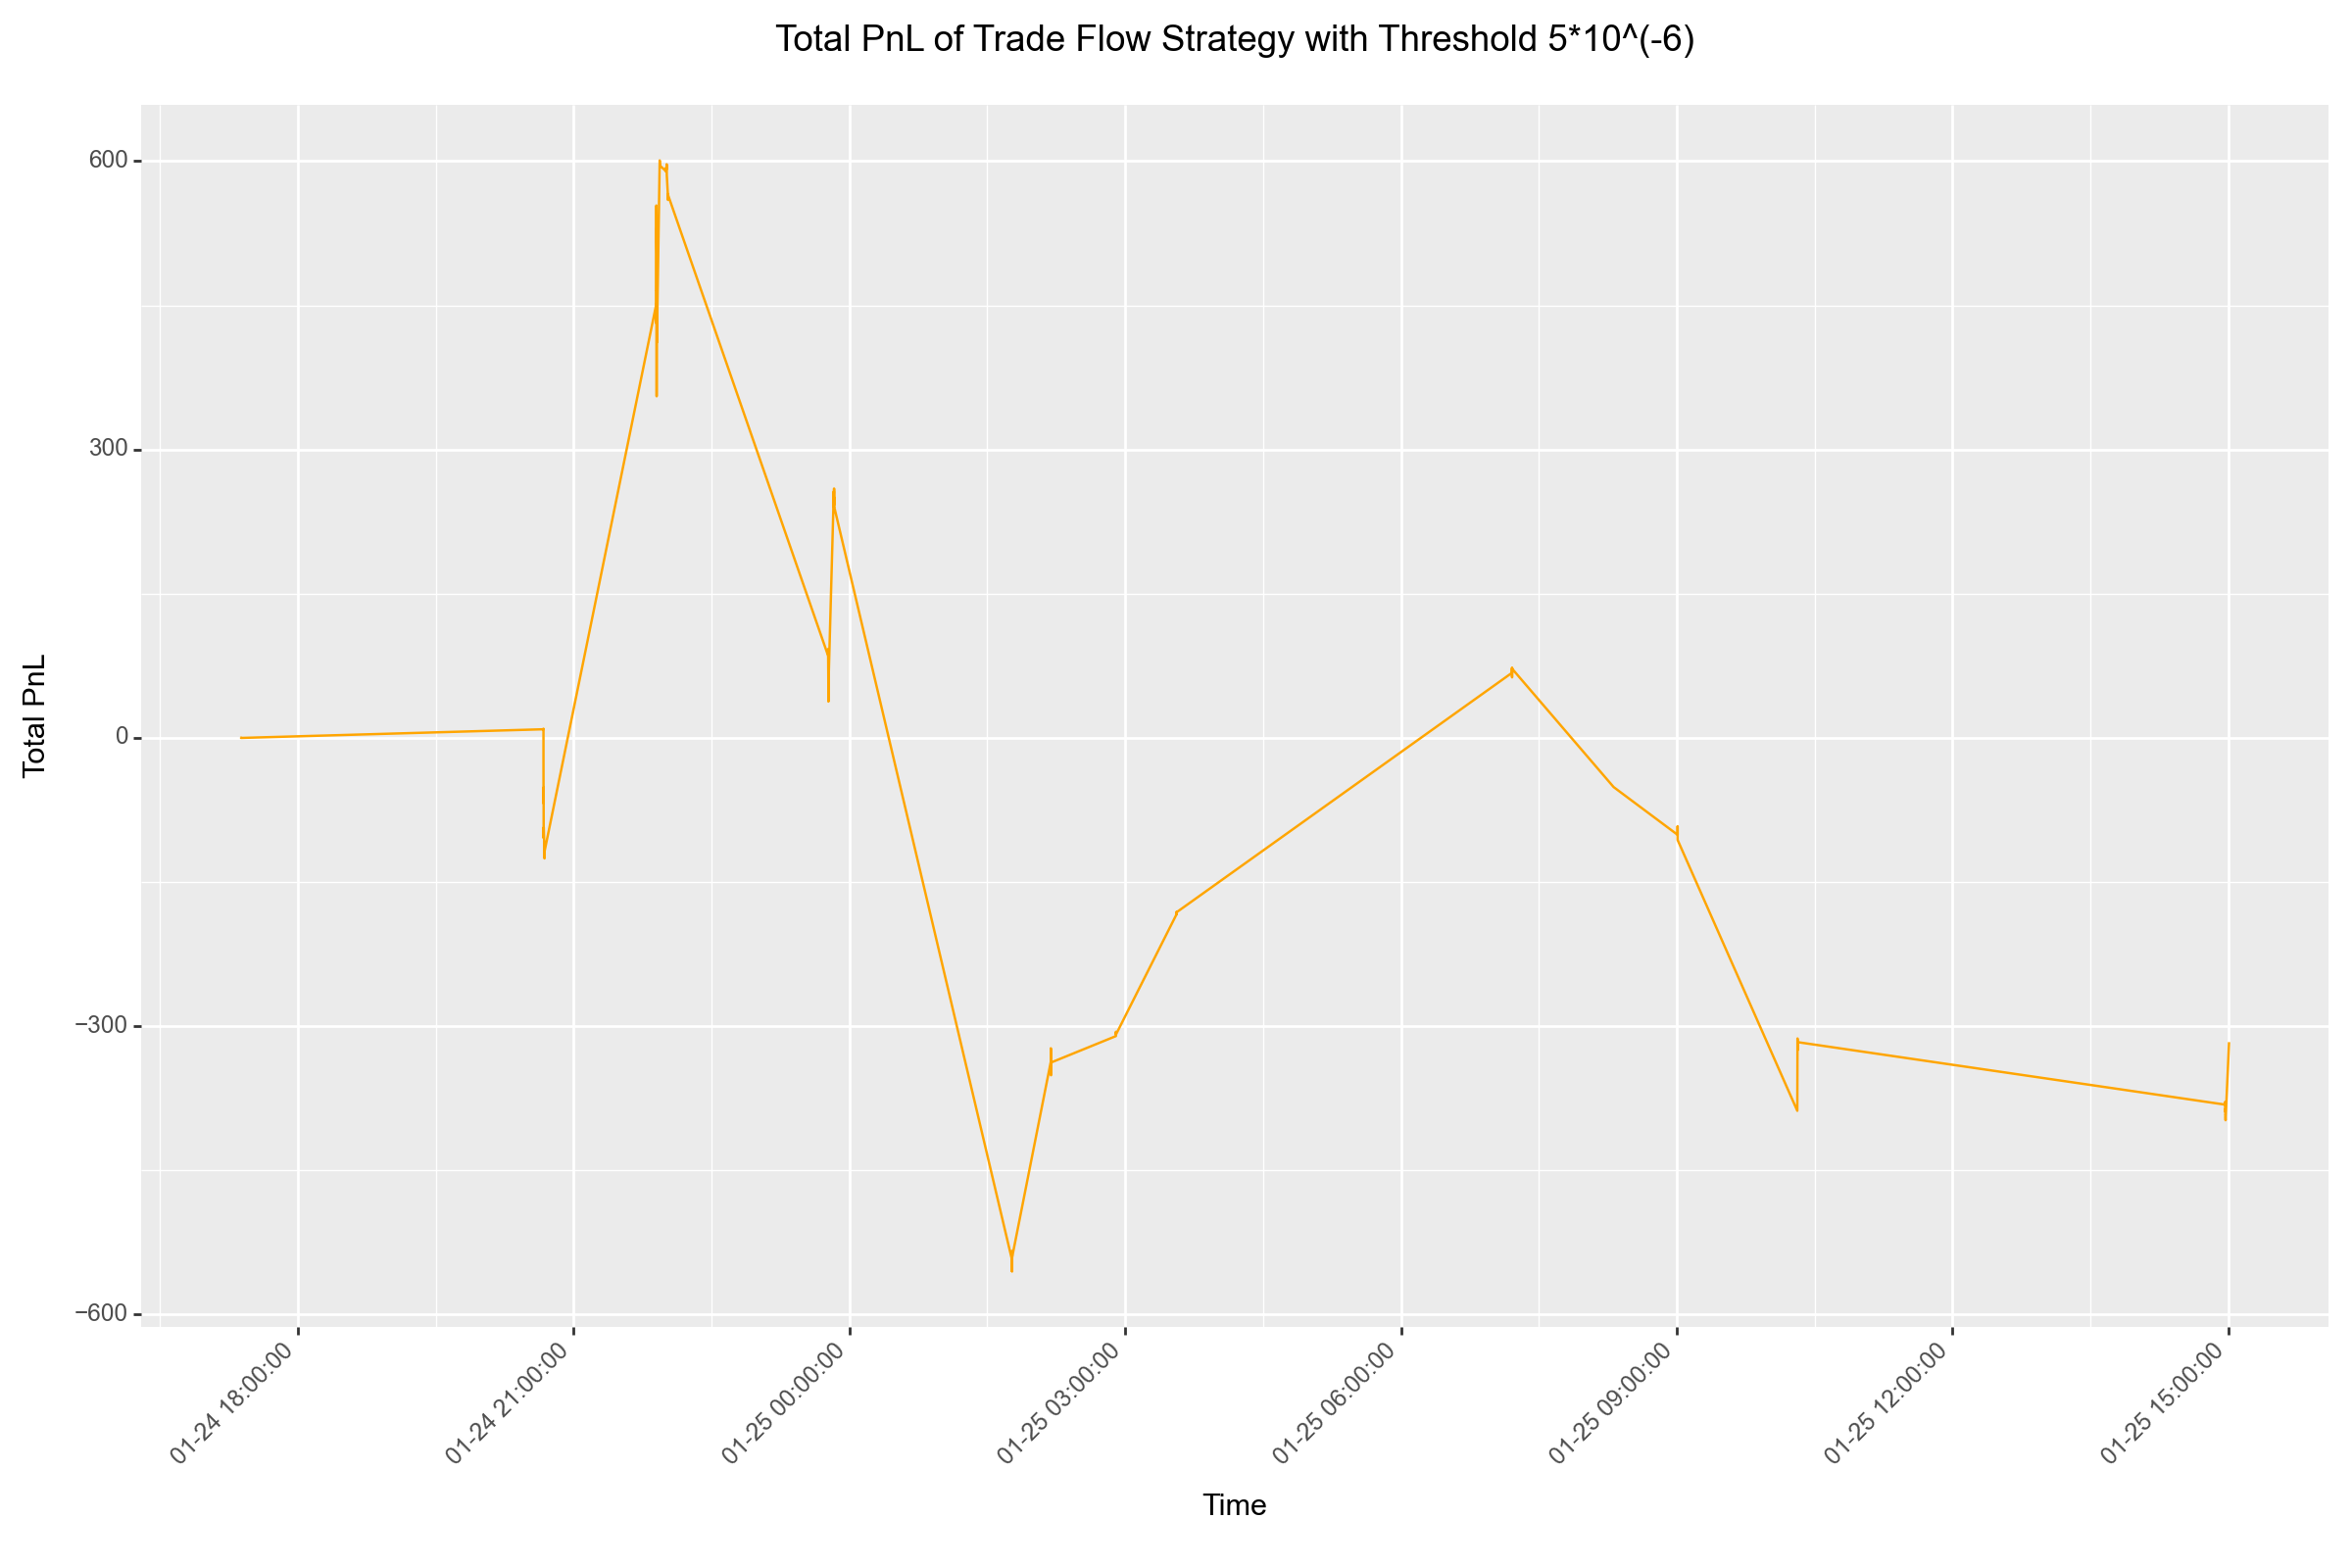

In [21]:
df = fourth_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

fourth_attempt_pnl_plot = (p9. ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title='Total PnL of Trade Flow Strategy with Threshold 5*10^(-6)',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

fourth_attempt_pnl_plot.draw()

#### As we can see, adjusting the threshold merely magnifies our losses; the more we trade, the more we end up losing in total PnL. The general trend of the PnL plots are all similar, indicating that with our current setup, the threshold is not the issue with our strategy. Instead, it is likely the actual regression itself that causes such unfavorable profits, which means that we should adjust the training/testing data and the weighting of our return predictions (through different beta calculations). Let's start with the first of these two possibilities. Note that at the beginning, we decided to use 40% of the training data to calculate our regression. Because of the poor PnL we are seeing, perhaps this indicates that our model needed a bit more training data in order to form a useful regression coefficient. We do want to avoid overfitting our data, but let's try a 60/40 train/test split to see if this has any benefit to our PnL.

In [22]:
longer_eth_usd_trade_train, shorter_eth_usd_trade_test = split_data_into_training_and_testing(eth_usd_trade_df, training_cutoff=0.6)

In [23]:
long_consolidated_eth_usd_trade_train = consolidate_by_timestamp(longer_eth_usd_trade_train)
long_trade_flow_eth_usd_trade_train = calculate_trade_flow(long_consolidated_eth_usd_trade_train, tau)
long_finished_eth_usd_trade_train = calculate_forward_returns(long_trade_flow_eth_usd_trade_train, T).dropna()

short_consolidated_eth_usd_trade_test = consolidate_by_timestamp(shorter_eth_usd_trade_test)
short_finished_eth_usd_trade_test = calculate_trade_flow(short_consolidated_eth_usd_trade_test, tau).dropna()
short_finished_eth_usd_trade_test.set_index('timestamp', inplace=True)

In [24]:
first_long_train_attempt_tfs = TradeFlowStrategy(long_finished_eth_usd_trade_train, short_finished_eth_usd_trade_test, first_trade_threshold, 0.00001)
first_long_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99822/99822 [00:41<00:00, 2384.80it/s]


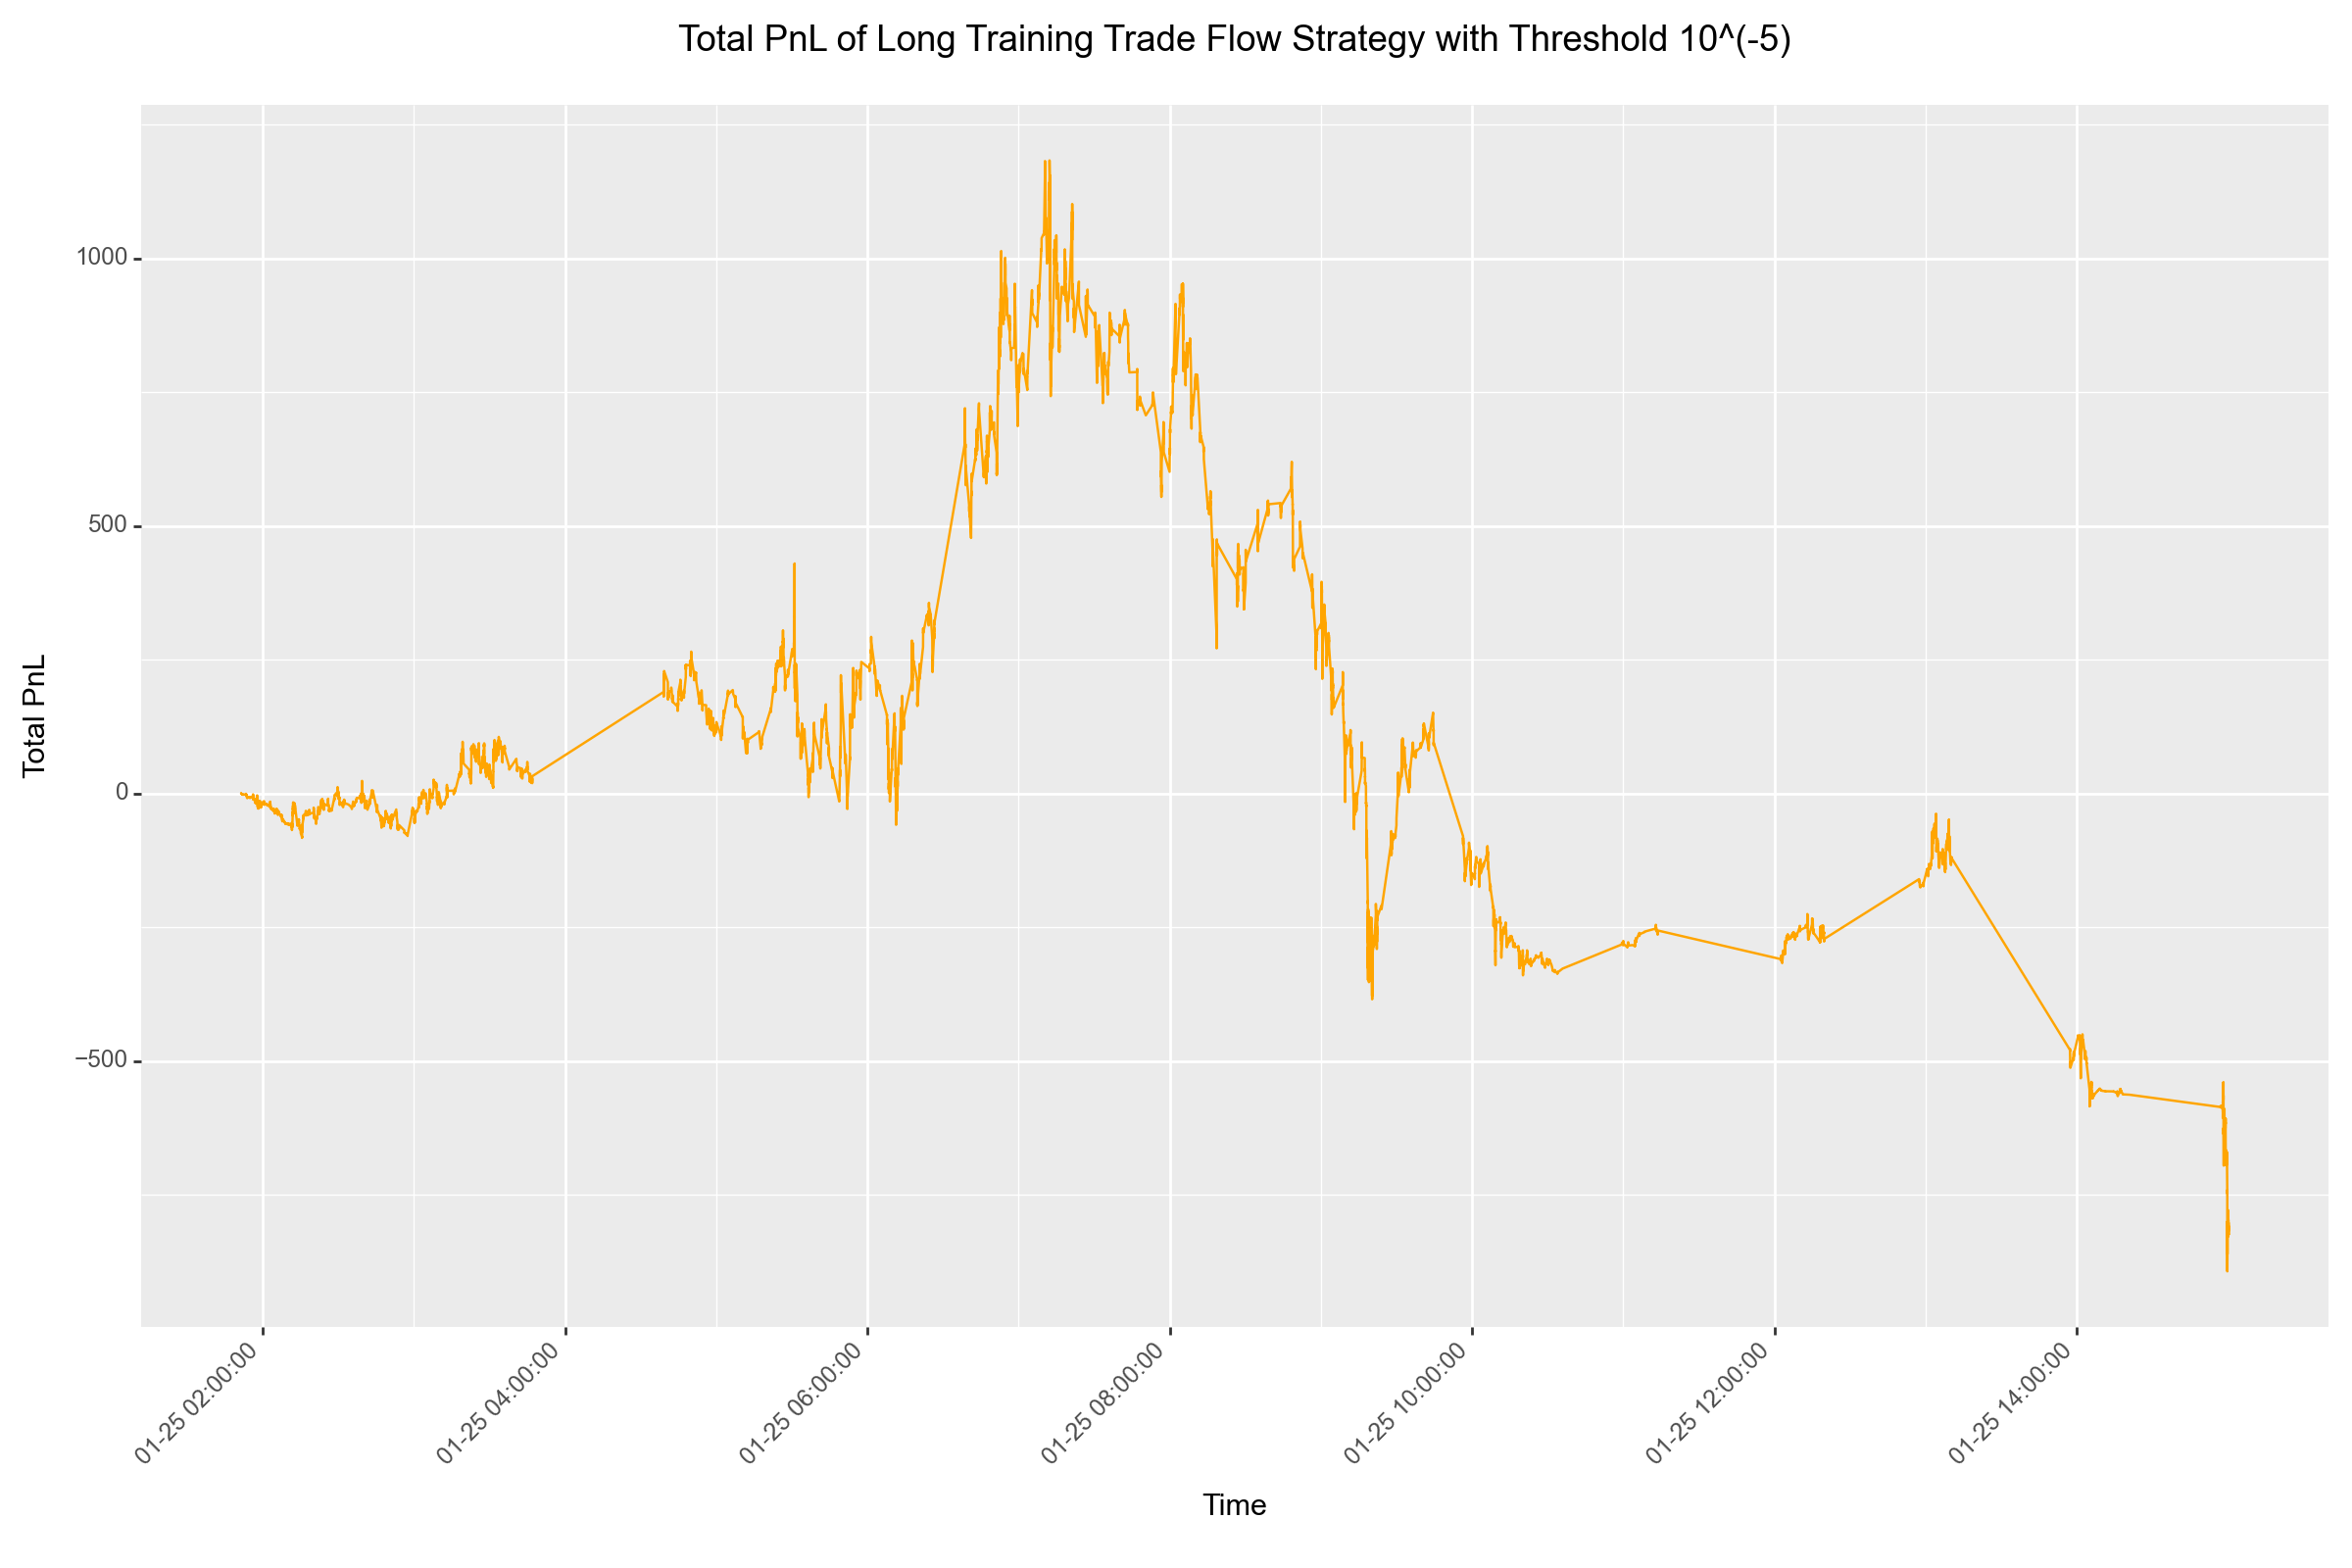

In [25]:
df = first_long_train_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

first_long_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title='Total PnL of Long Training Trade Flow Strategy with Threshold 10^(-5)',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

first_long_attempt_pnl_plot.draw()

#### Immediately we see a much more promising PnL plot. Though we do end up with unfavorable PnL at the very end of the trading period, we see a maximum cumulative PnL that has greater magnitude than our minimum cumulative PnL (which is a step in the right direction). Let us see how the different thresholds perform now that we have a more promising outlook on our PnL.

In [26]:
second_long_train_attempt_tfs = TradeFlowStrategy(long_finished_eth_usd_trade_train, short_finished_eth_usd_trade_test, second_trade_threshold, 0.00001)
second_long_train_attempt_tfs.run_strategy()

third_long_train_attempt_tfs = TradeFlowStrategy(long_finished_eth_usd_trade_train, short_finished_eth_usd_trade_test, third_trade_threshold, 0.00001)
third_long_train_attempt_tfs.run_strategy()

fourth_long_train_attempt_tfs = TradeFlowStrategy(long_finished_eth_usd_trade_train, short_finished_eth_usd_trade_test, fourth_trade_threshold, 0.00001)
fourth_long_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99822/99822 [00:27<00:00, 3589.02it/s]


In [27]:
def get_plot_as_image(data, threshold):
    df = data.copy()
    df['timestamp'] = df.index
    
    plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
            + p9.geom_line(color='orange')
            + p9.theme(figure_size=(8, 6), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
            + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
            + p9.labs(title=f'Total PnL for Threshold {threshold}', x='Time', y='Total PnL'))
    buffer = io.BytesIO()
    plot.save(buffer, format='png', verbose=False)
    buffer.seek(0)
    return imread(buffer)

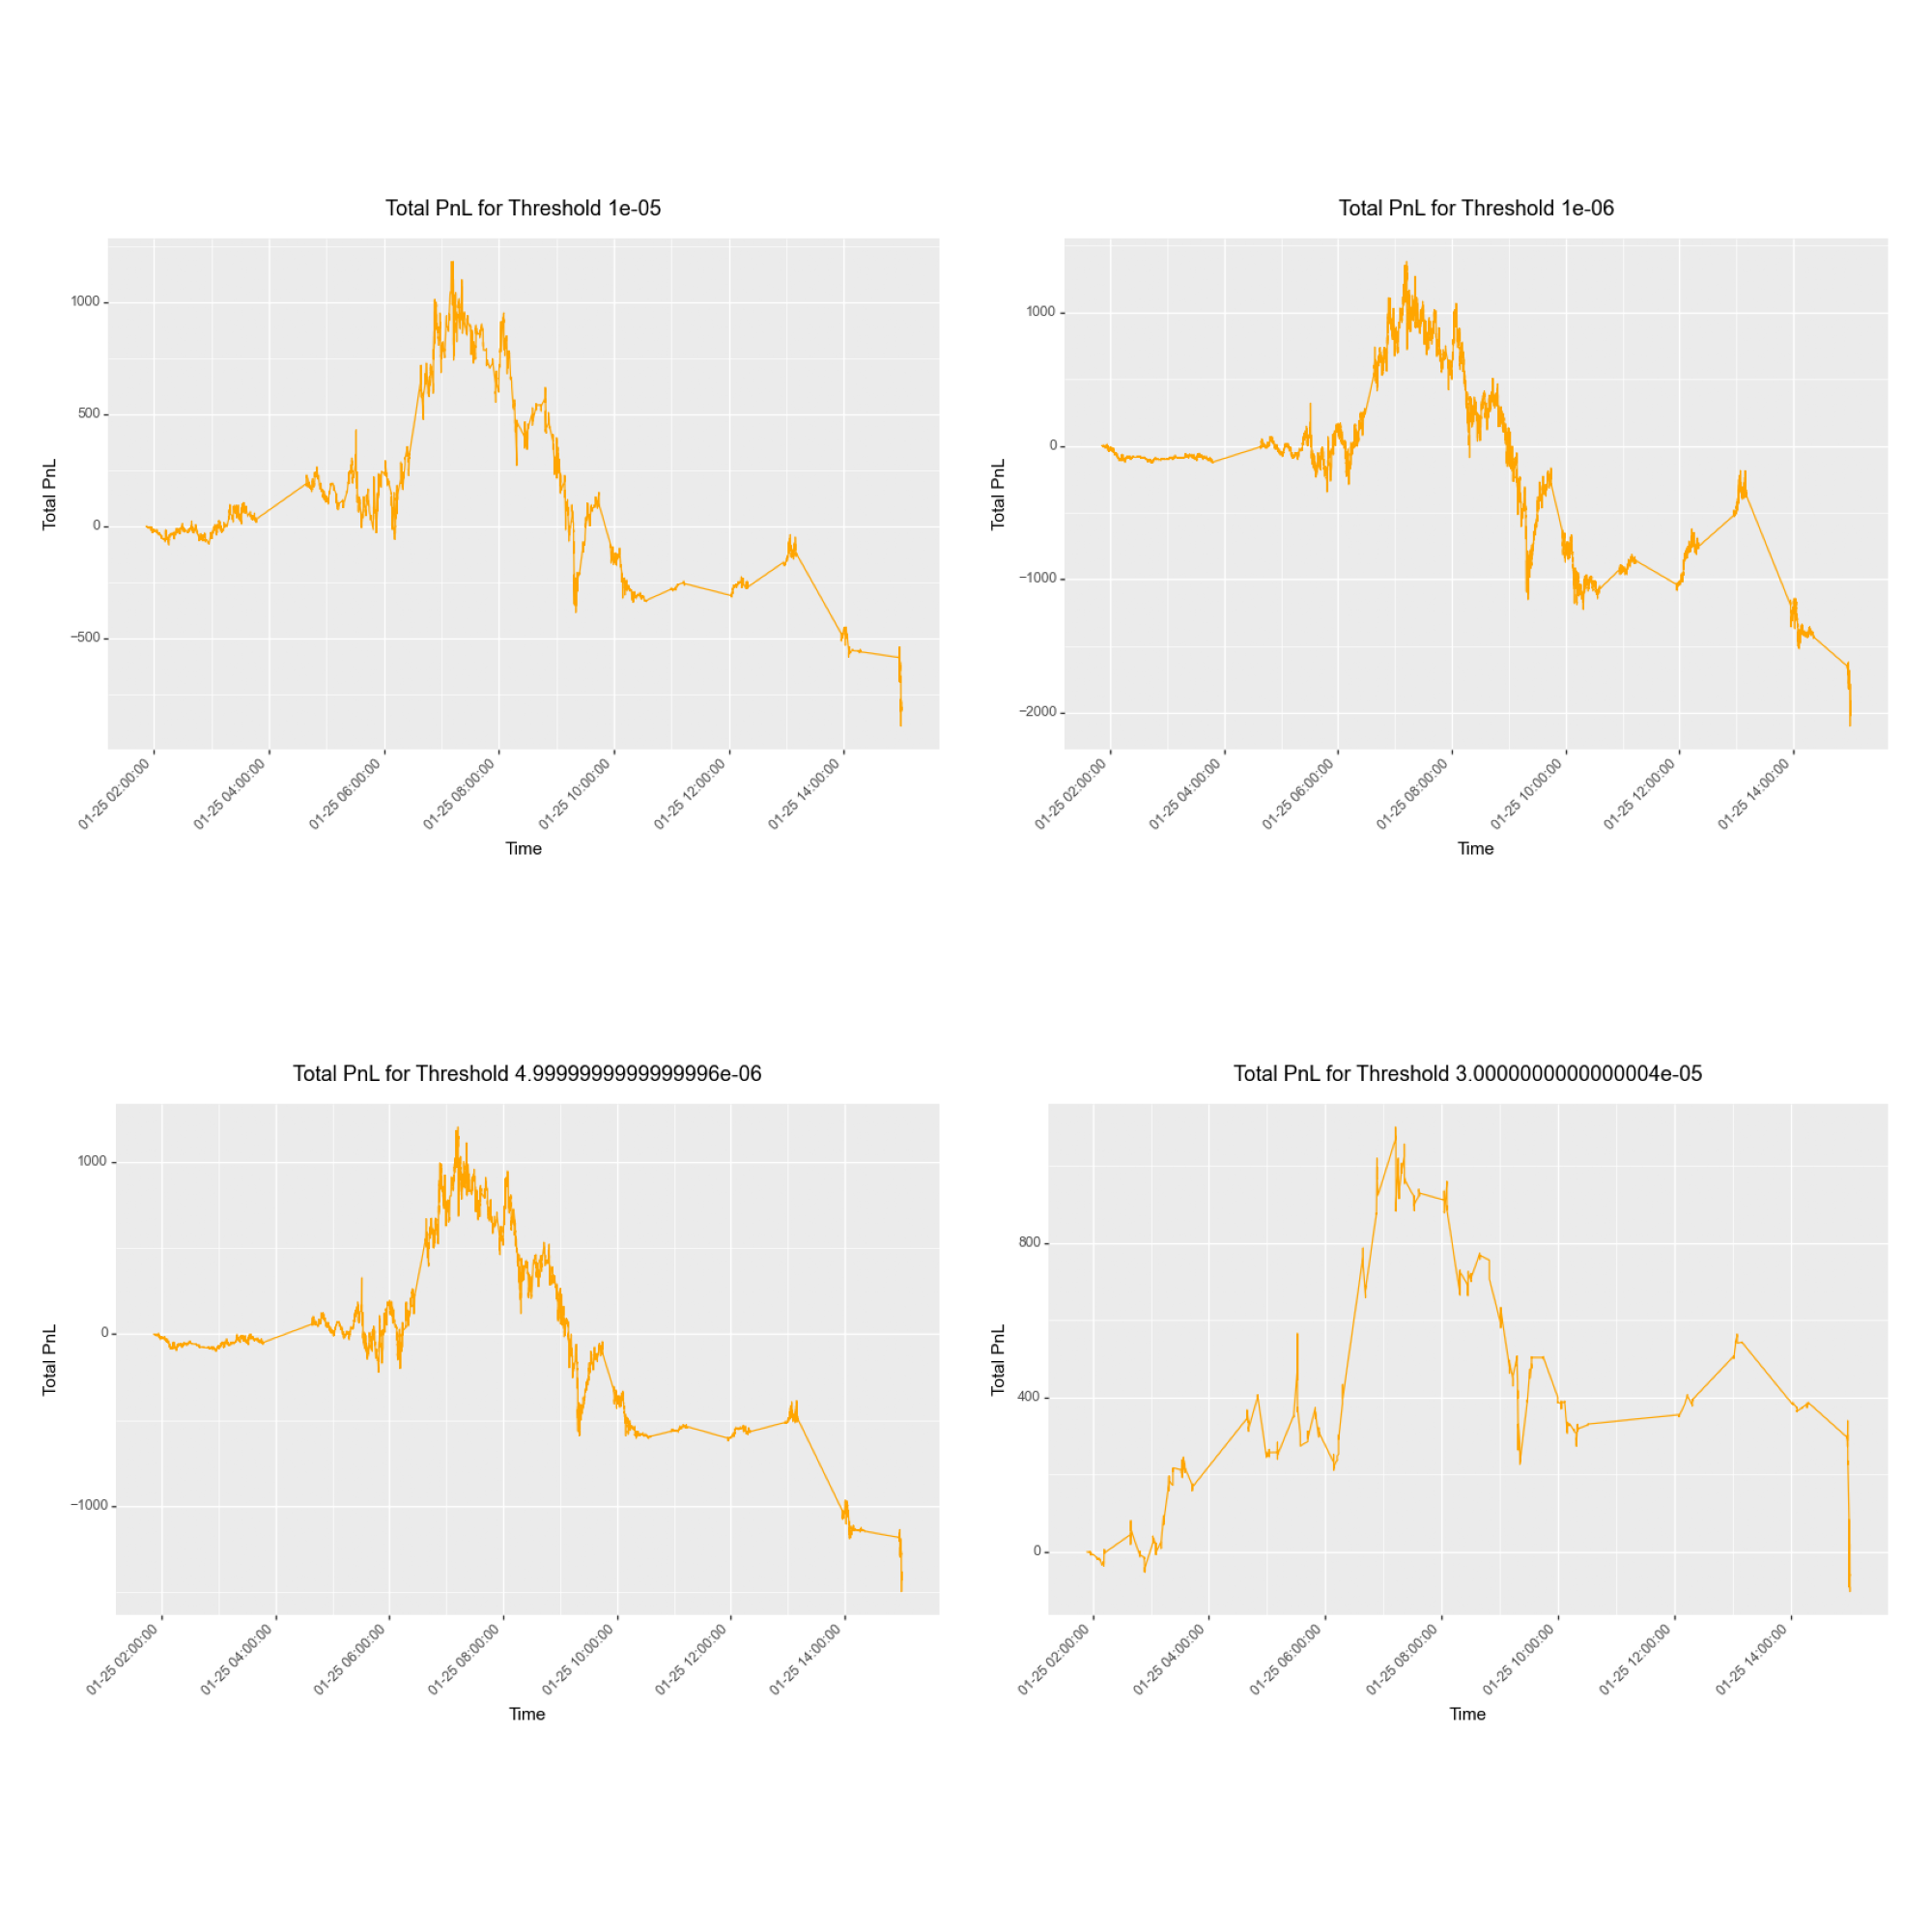

In [28]:
strats_list = [
    (first_long_train_attempt_tfs, first_trade_threshold), 
    (second_long_train_attempt_tfs, second_trade_threshold),
    (third_long_train_attempt_tfs, third_trade_threshold),
    (fourth_long_train_attempt_tfs, fourth_trade_threshold)
               ]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i, ele in enumerate(strats_list):
    df = ele[0].trading_log
    threshold = ele[1]
    
    image = get_plot_as_image(df, threshold)
    axes[i].imshow(image)
    axes[i].axis('off')


plt.tight_layout()
plt.show()

#### Interestingly enough, we see that even with smaller thresholds, the upside potential of the strategy appears to be similar, capping at a total cumulative PnL of around 1000. However, the higher thresholds have much greater downside, holding onto unprofitable positions and missing out on good opportunities towards the end of the testing period. We at least see that our strategy has potential to make PnL, but we have to figure out a way to avoid this drastic decline in PnL towards the end of the period. We see that the highest trading threshold performs the best, so we will stick with this threshold for now. We obviously don't want to edit our strategy using lookahead bias by assuming we would have sold off our positions at the perfect PnL. So, let us see if varying the values for tau and T would yield a better PnL for the strategy. 

In [29]:
second_tau, second_T = 20, 10

second_tau_and_T_trade_flow_eth_usd_trade_train = calculate_trade_flow(long_consolidated_eth_usd_trade_train, second_tau)
second_tau_and_T_finished_eth_usd_trade_train = calculate_forward_returns(second_tau_and_T_trade_flow_eth_usd_trade_train, second_T).dropna()

second_tau_and_T_finished_eth_usd_trade_test = calculate_trade_flow(short_consolidated_eth_usd_trade_test, second_tau).dropna()
second_tau_and_T_finished_eth_usd_trade_test.set_index('timestamp', inplace=True)

In [30]:
second_tau_and_T_train_attempt_tfs = TradeFlowStrategy(
    second_tau_and_T_finished_eth_usd_trade_train, 
    second_tau_and_T_finished_eth_usd_trade_test, 
    fourth_trade_threshold, 
    0.00001)

second_tau_and_T_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99798/99798 [00:32<00:00, 3099.68it/s]


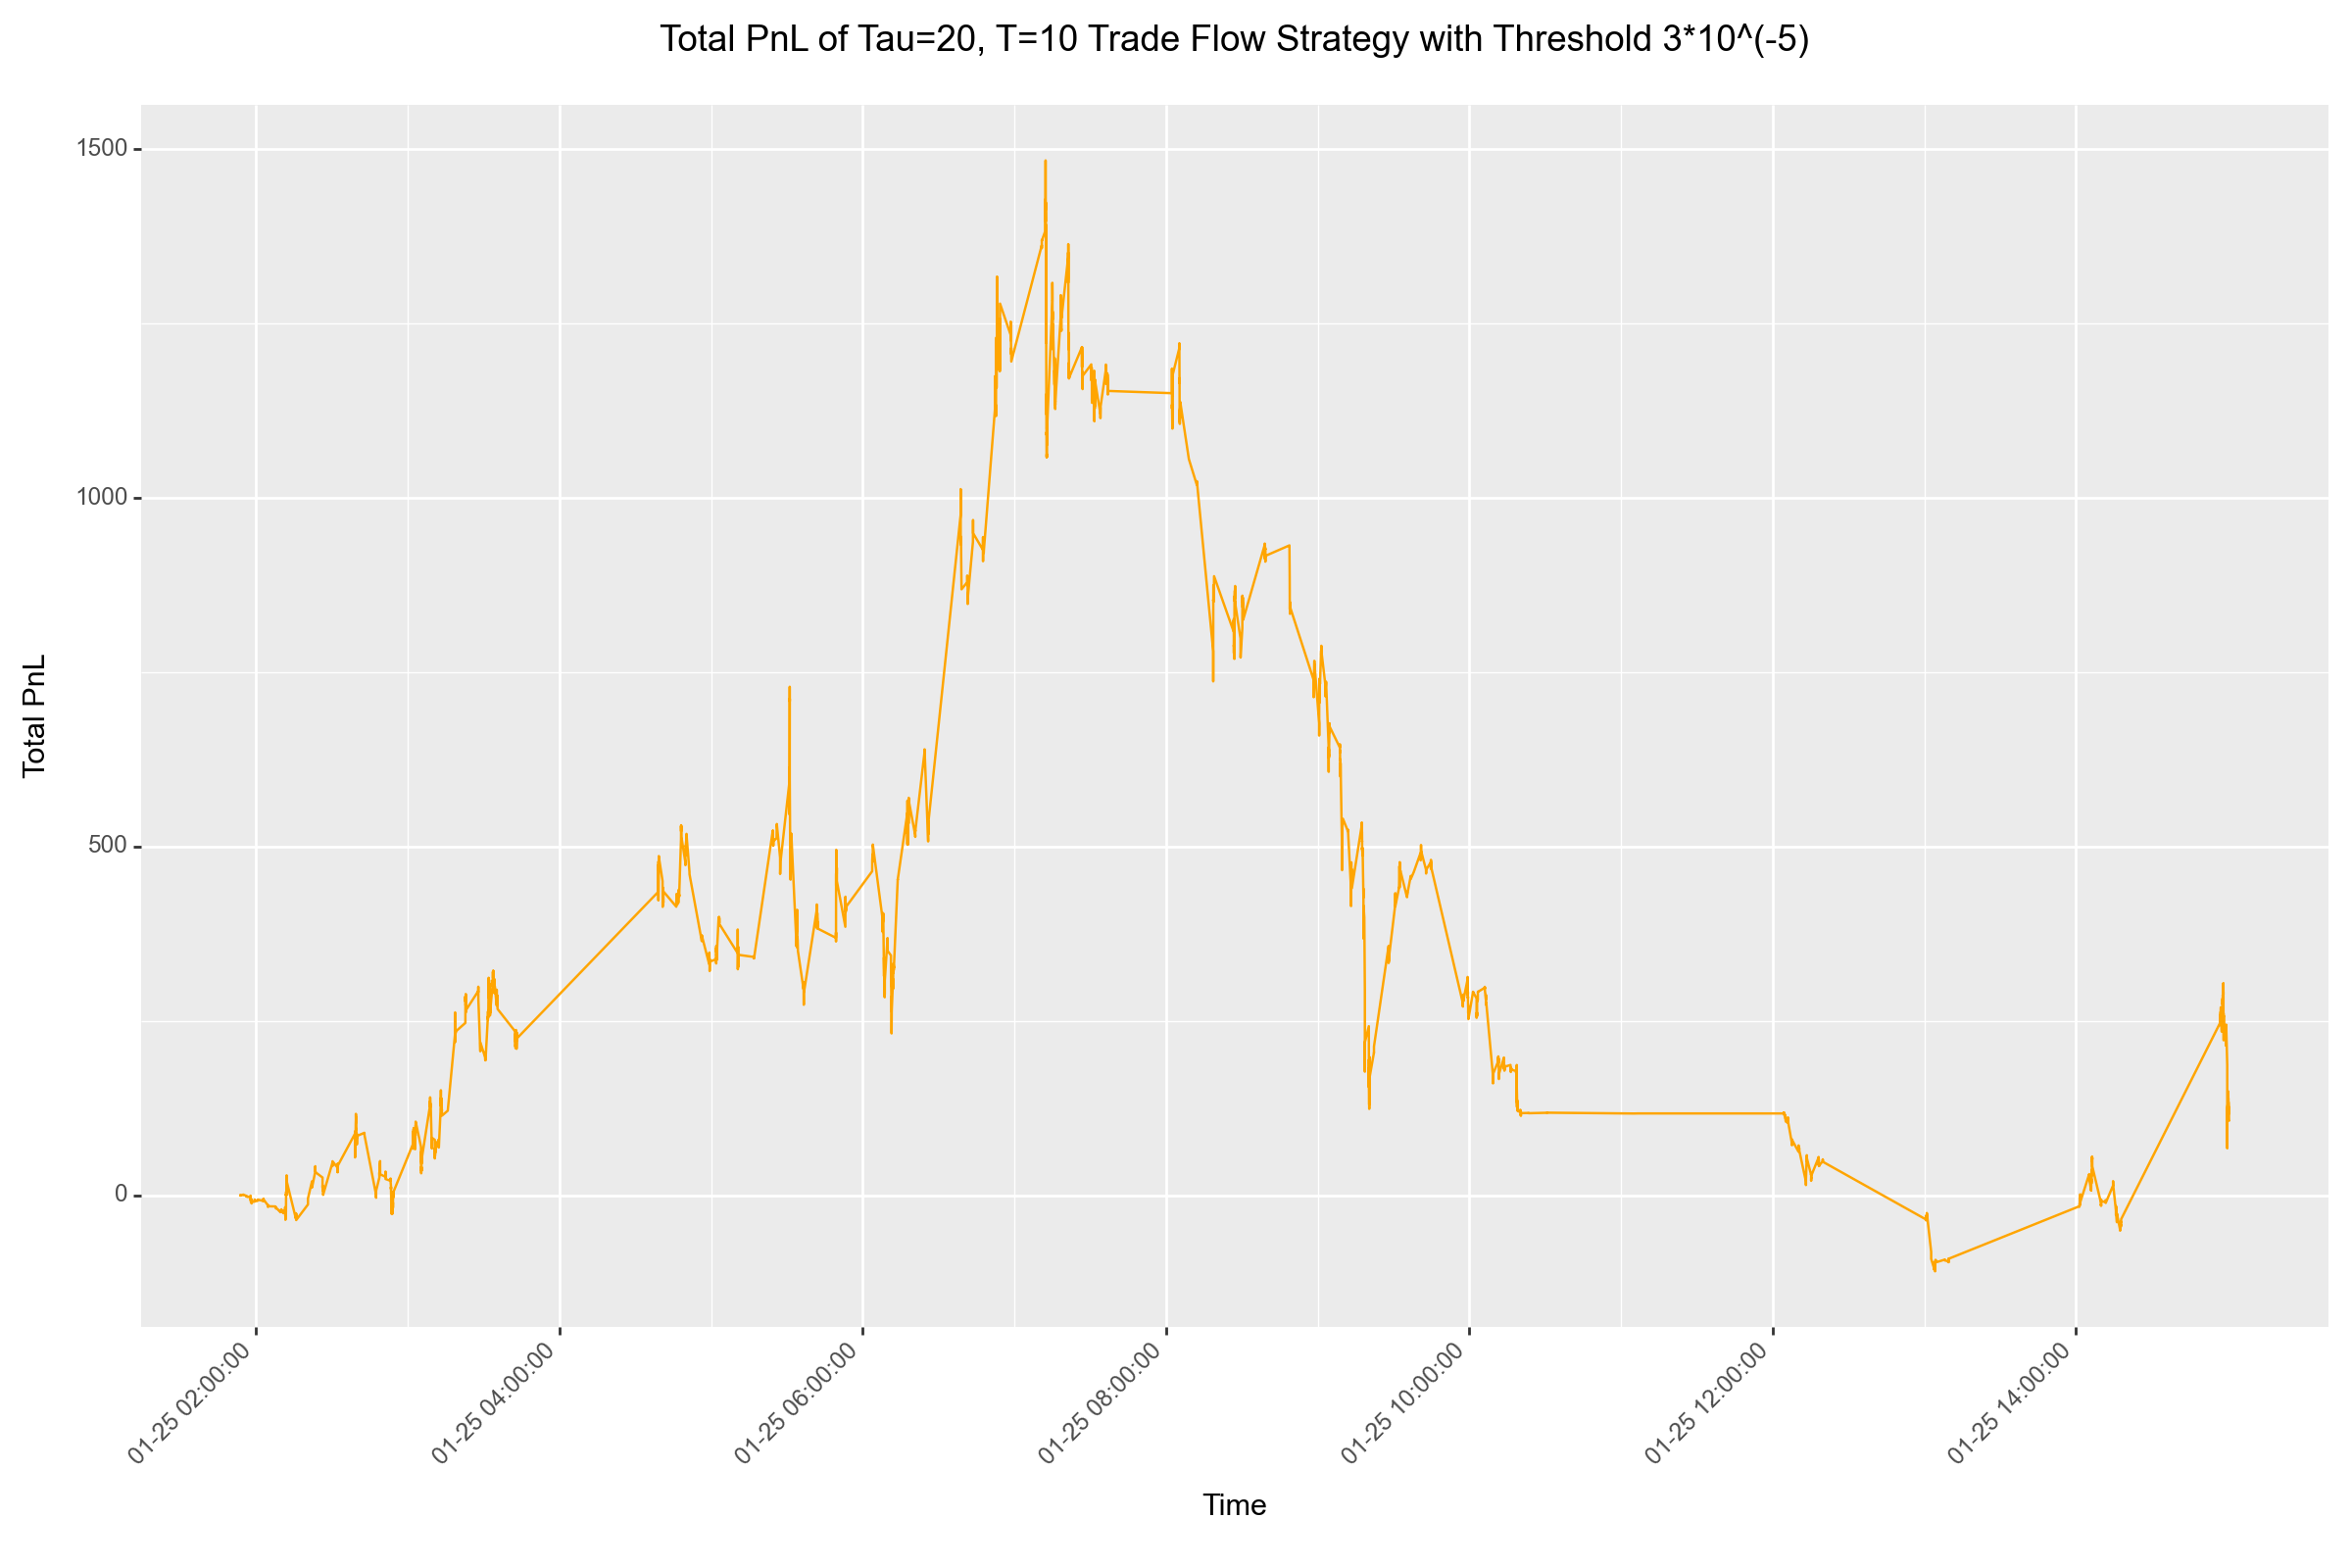

In [31]:
df = second_tau_and_T_train_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

second_tau_and_T_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title='Total PnL of Tau=20, T=10 Trade Flow Strategy with Threshold 3*10^(-5)',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

second_tau_and_T_attempt_pnl_plot.draw()

#### Now this looks a lot more promising. Our highest PnL is around 1500, and we actually recover from our poor performance, finishing with a positive PnL. We also notice that our threshold in this case seems to be producing a lot more trades, which means that our return predictions more frequently surpass our previously high threshold. Let us investigate this threshold and differing the values of tau and T more.

In [32]:
temp_df = second_tau_and_T_train_attempt_tfs.testing_data.copy()
temp_df['abs'] = abs(temp_df['return_predictions'])
temp_df[temp_df['abs'] >= fourth_trade_threshold]

Price      Size  Side  trade_flow  \
timestamp                                                          
2023-01-25 01:53:44.900030  1534.690  5.750774     1   69.471766   
2023-01-25 01:53:44.900491  1534.745  5.865668     1   75.222540   
2023-01-25 01:53:44.902535  1534.800  1.905197     1   81.088207   
2023-01-25 01:53:44.972329  1534.890  0.539651     1   82.797775   
2023-01-25 01:53:44.993891  1534.870  3.483189     1   83.337425   
...                              ...       ...   ...         ...   
2023-01-25 15:00:30.318655  1533.320  4.554000     1 -174.335085   
2023-01-25 15:00:30.318708  1533.335  7.617833     1 -169.781085   
2023-01-25 15:00:30.319185  1533.310  2.095787     1 -162.163252   
2023-01-25 15:00:30.330265  1533.310  1.181857     1 -160.067466   
2023-01-25 15:00:30.376266  1533.300  0.040724     1 -153.444550   

                            return_predictions       abs  
timestamp                                                 
2023-01-25 01:53:44.900030            0.000031  0.000031  
2023-01-25 01:53:44.900491            0.000034  0.000034  
2023-01-25 01:53:44.902535            0.000036  0.000036  
2023-01-25 01:53:44.972329            0.000037  0.000037  
2023-01-25 01:53:44.993891            0.000037  0.000037  
...                                        ...       ...  
2023-01-25 15:00:30.318655           -0.000078  0.000078  
2023-01-25 15:00:30.318708           -0.000076  0.000076  
2023-01-25 15:00:30.319185           -0.000073  0.000073  
2023-01-25 15:00:30.330265           -0.000072  0.000072  
2023-01-25 15:00:30.376266           -0.000069  0.000069  

[10765 rows x 6 columns]

#### As expected, we do in fact see a lot more trades that will be executed due to our change in T and tau. Therefore, we will define thresholds in the future by taking the minimum of the magnitude of the quantile value above our desired threshold percentage. For example, if we want to execute on 20% of the trades, then we will calculate the threshold to be the value which 20% of the magnitude of return_predictions are greater than.

In [33]:
def find_threshold_value_by_percentage(test_df, percentage):
    df = test_df.copy()
    df['abs'] = abs(df['return_predictions'])
    
    return df['abs'].quantile(1-percentage) 

In [34]:
threshold_20_pct = find_threshold_value_by_percentage(second_tau_and_T_train_attempt_tfs.testing_data, 0.2)

second_tau_and_T_train_attempt_tfs.threshold = threshold_20_pct
second_tau_and_T_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99798/99798 [00:52<00:00, 1890.24it/s]


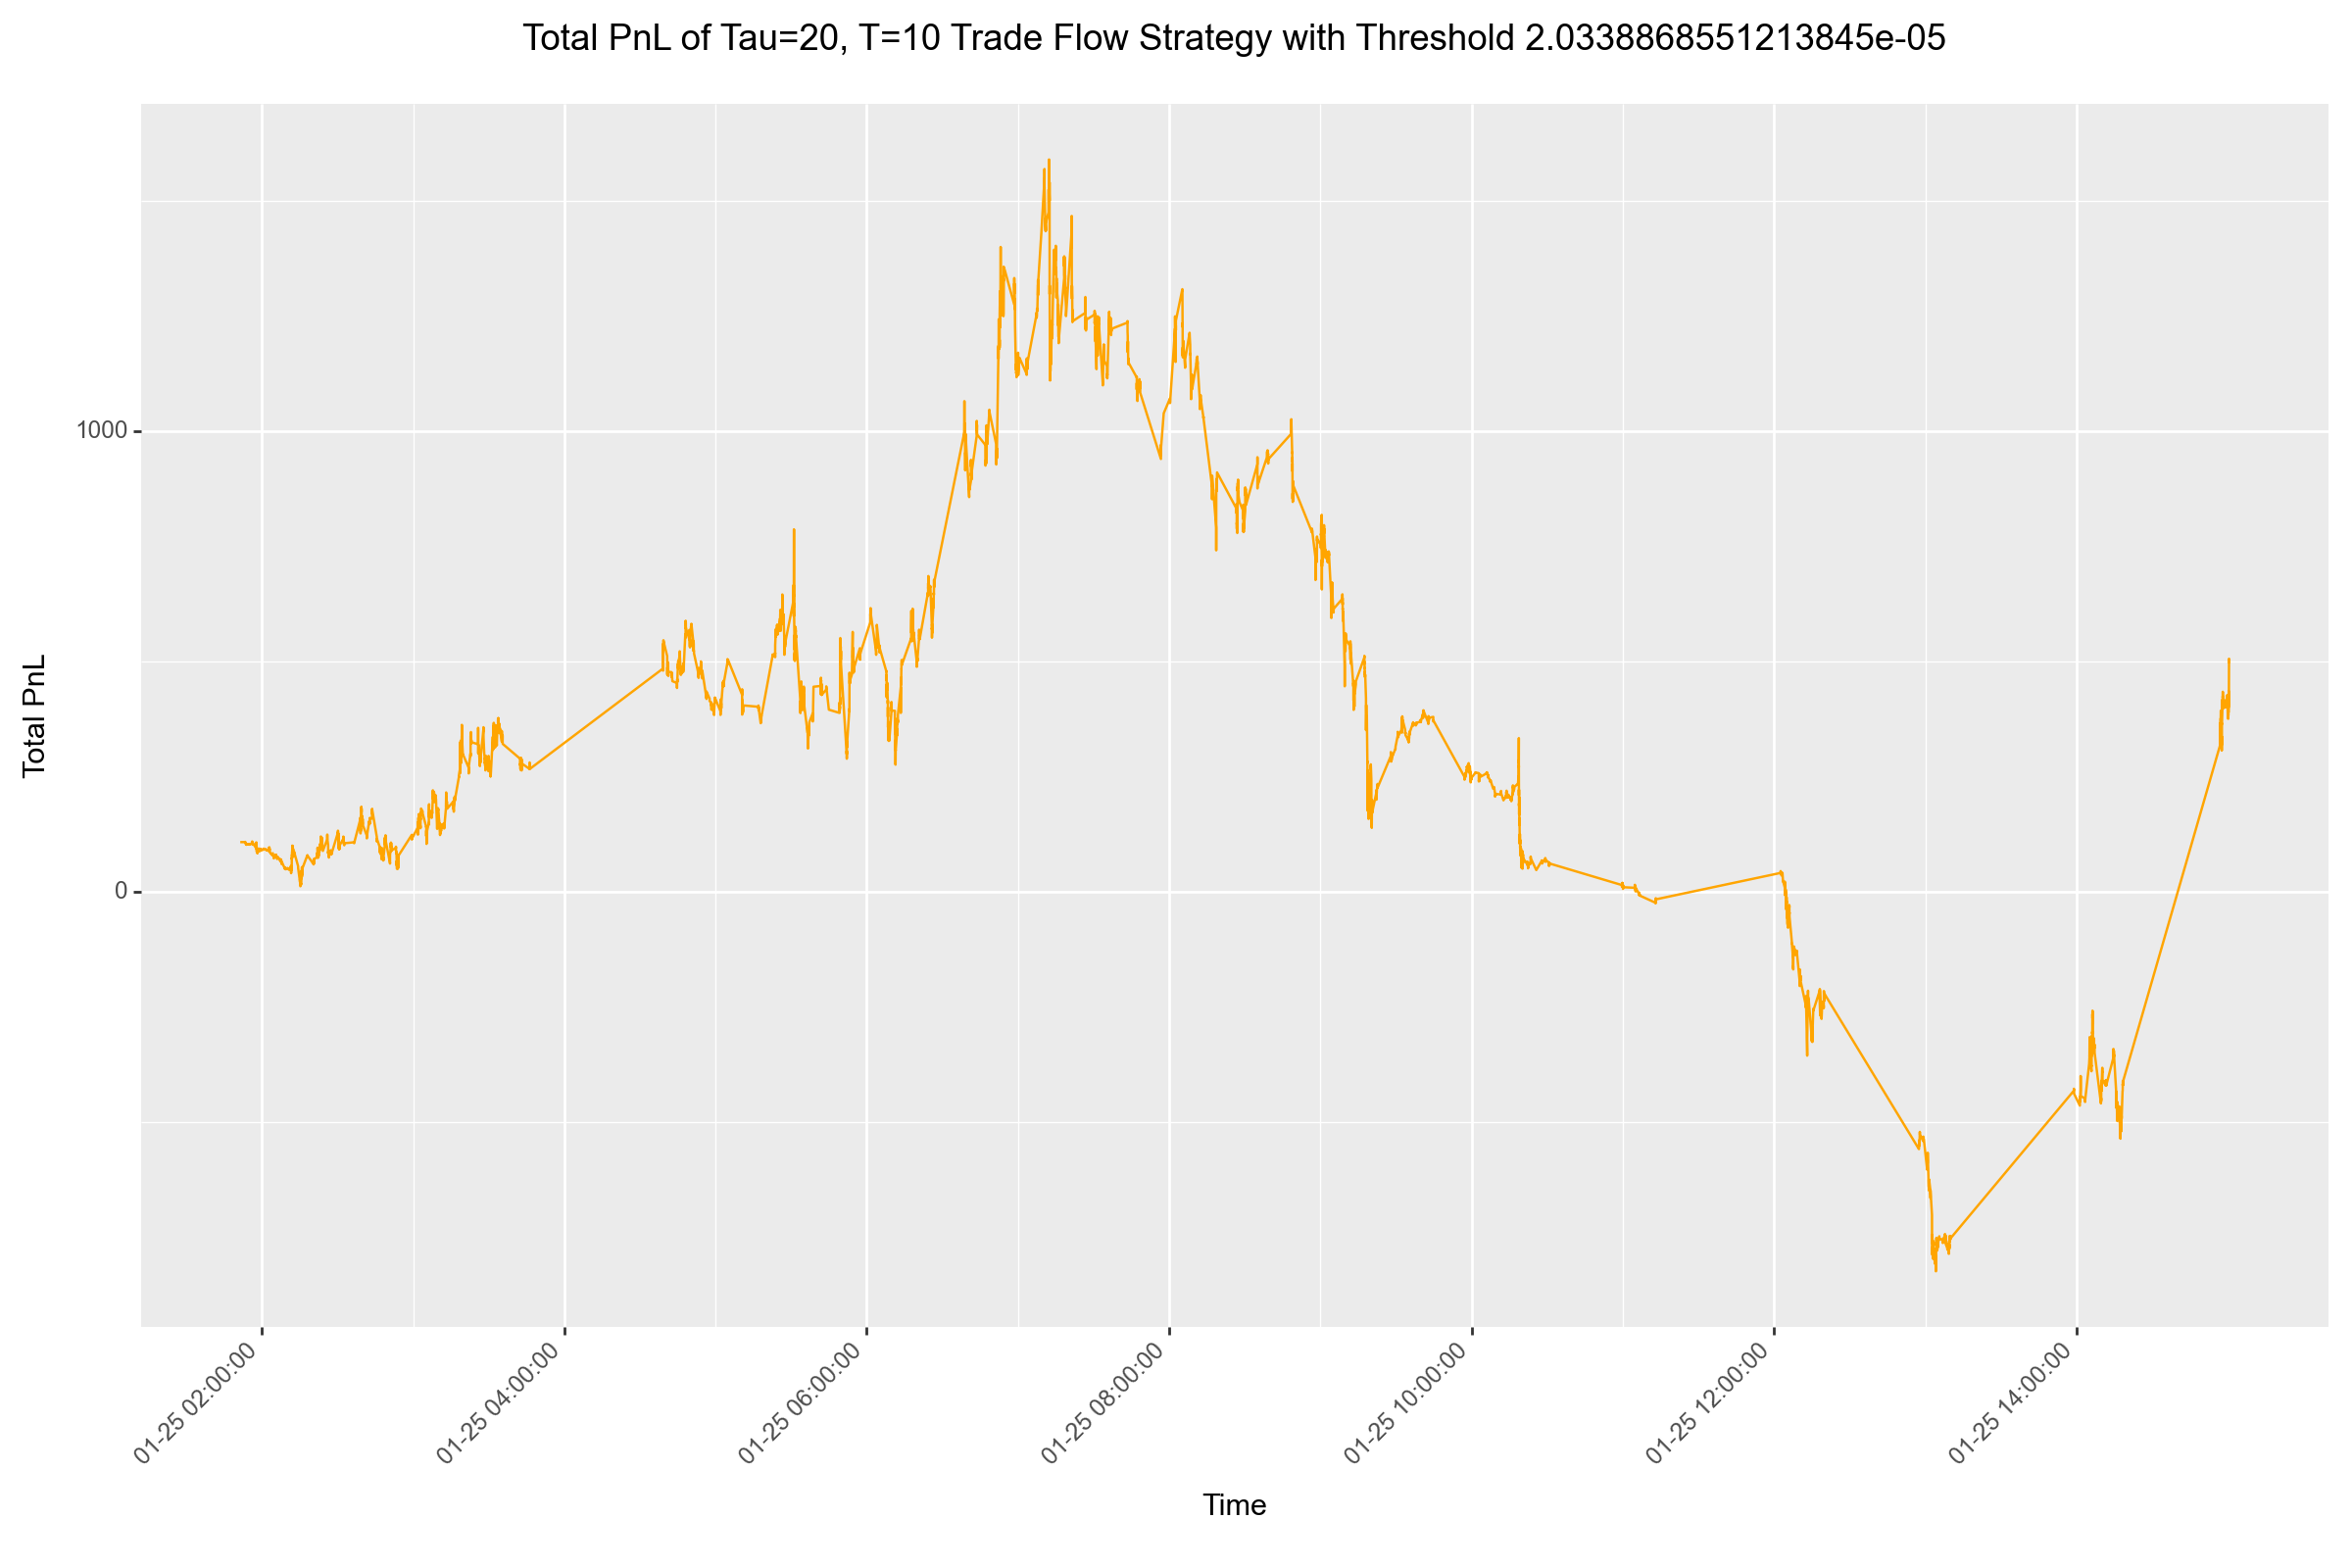

In [66]:
df = second_tau_and_T_train_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

second_tau_and_T_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title=f'Total PnL of Tau=20, T=10 Trade Flow Strategy with Threshold {threshold_20_pct}',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

second_tau_and_T_attempt_pnl_plot.draw()

#### We see that with our correctly defined threshold, our graph is already looking more promising. In order to get a more general understanding of the appropriate threshold range, we are going to calculate multiple other strategies and compare PnL. We are currently seeing that a lower threshold produces better PnL, but to be completely sure we must see how strategies in threshold increments of 5% perform against each other.

In [50]:
threshold_pct_list = list(np.arange(0.05, 1.05, 0.05))
threshold_list = []
test_df = second_tau_and_T_train_attempt_tfs.testing_data

for threshold_pct in threshold_pct_list:
    threshold_list.append(find_threshold_value_by_percentage(test_df, threshold_pct))

In [51]:
threshold_strat_list = []

for threshold in threshold_list:
    tfs = TradeFlowStrategy(
    second_tau_and_T_finished_eth_usd_trade_train, 
    second_tau_and_T_finished_eth_usd_trade_test, 
    threshold, 
    0.00001)
    tfs.run_strategy()
    
    threshold_strat_list.append((tfs, threshold))

Running strategy on testing set: 100%|██████████| 99798/99798 [02:54<00:00, 571.52it/s] 


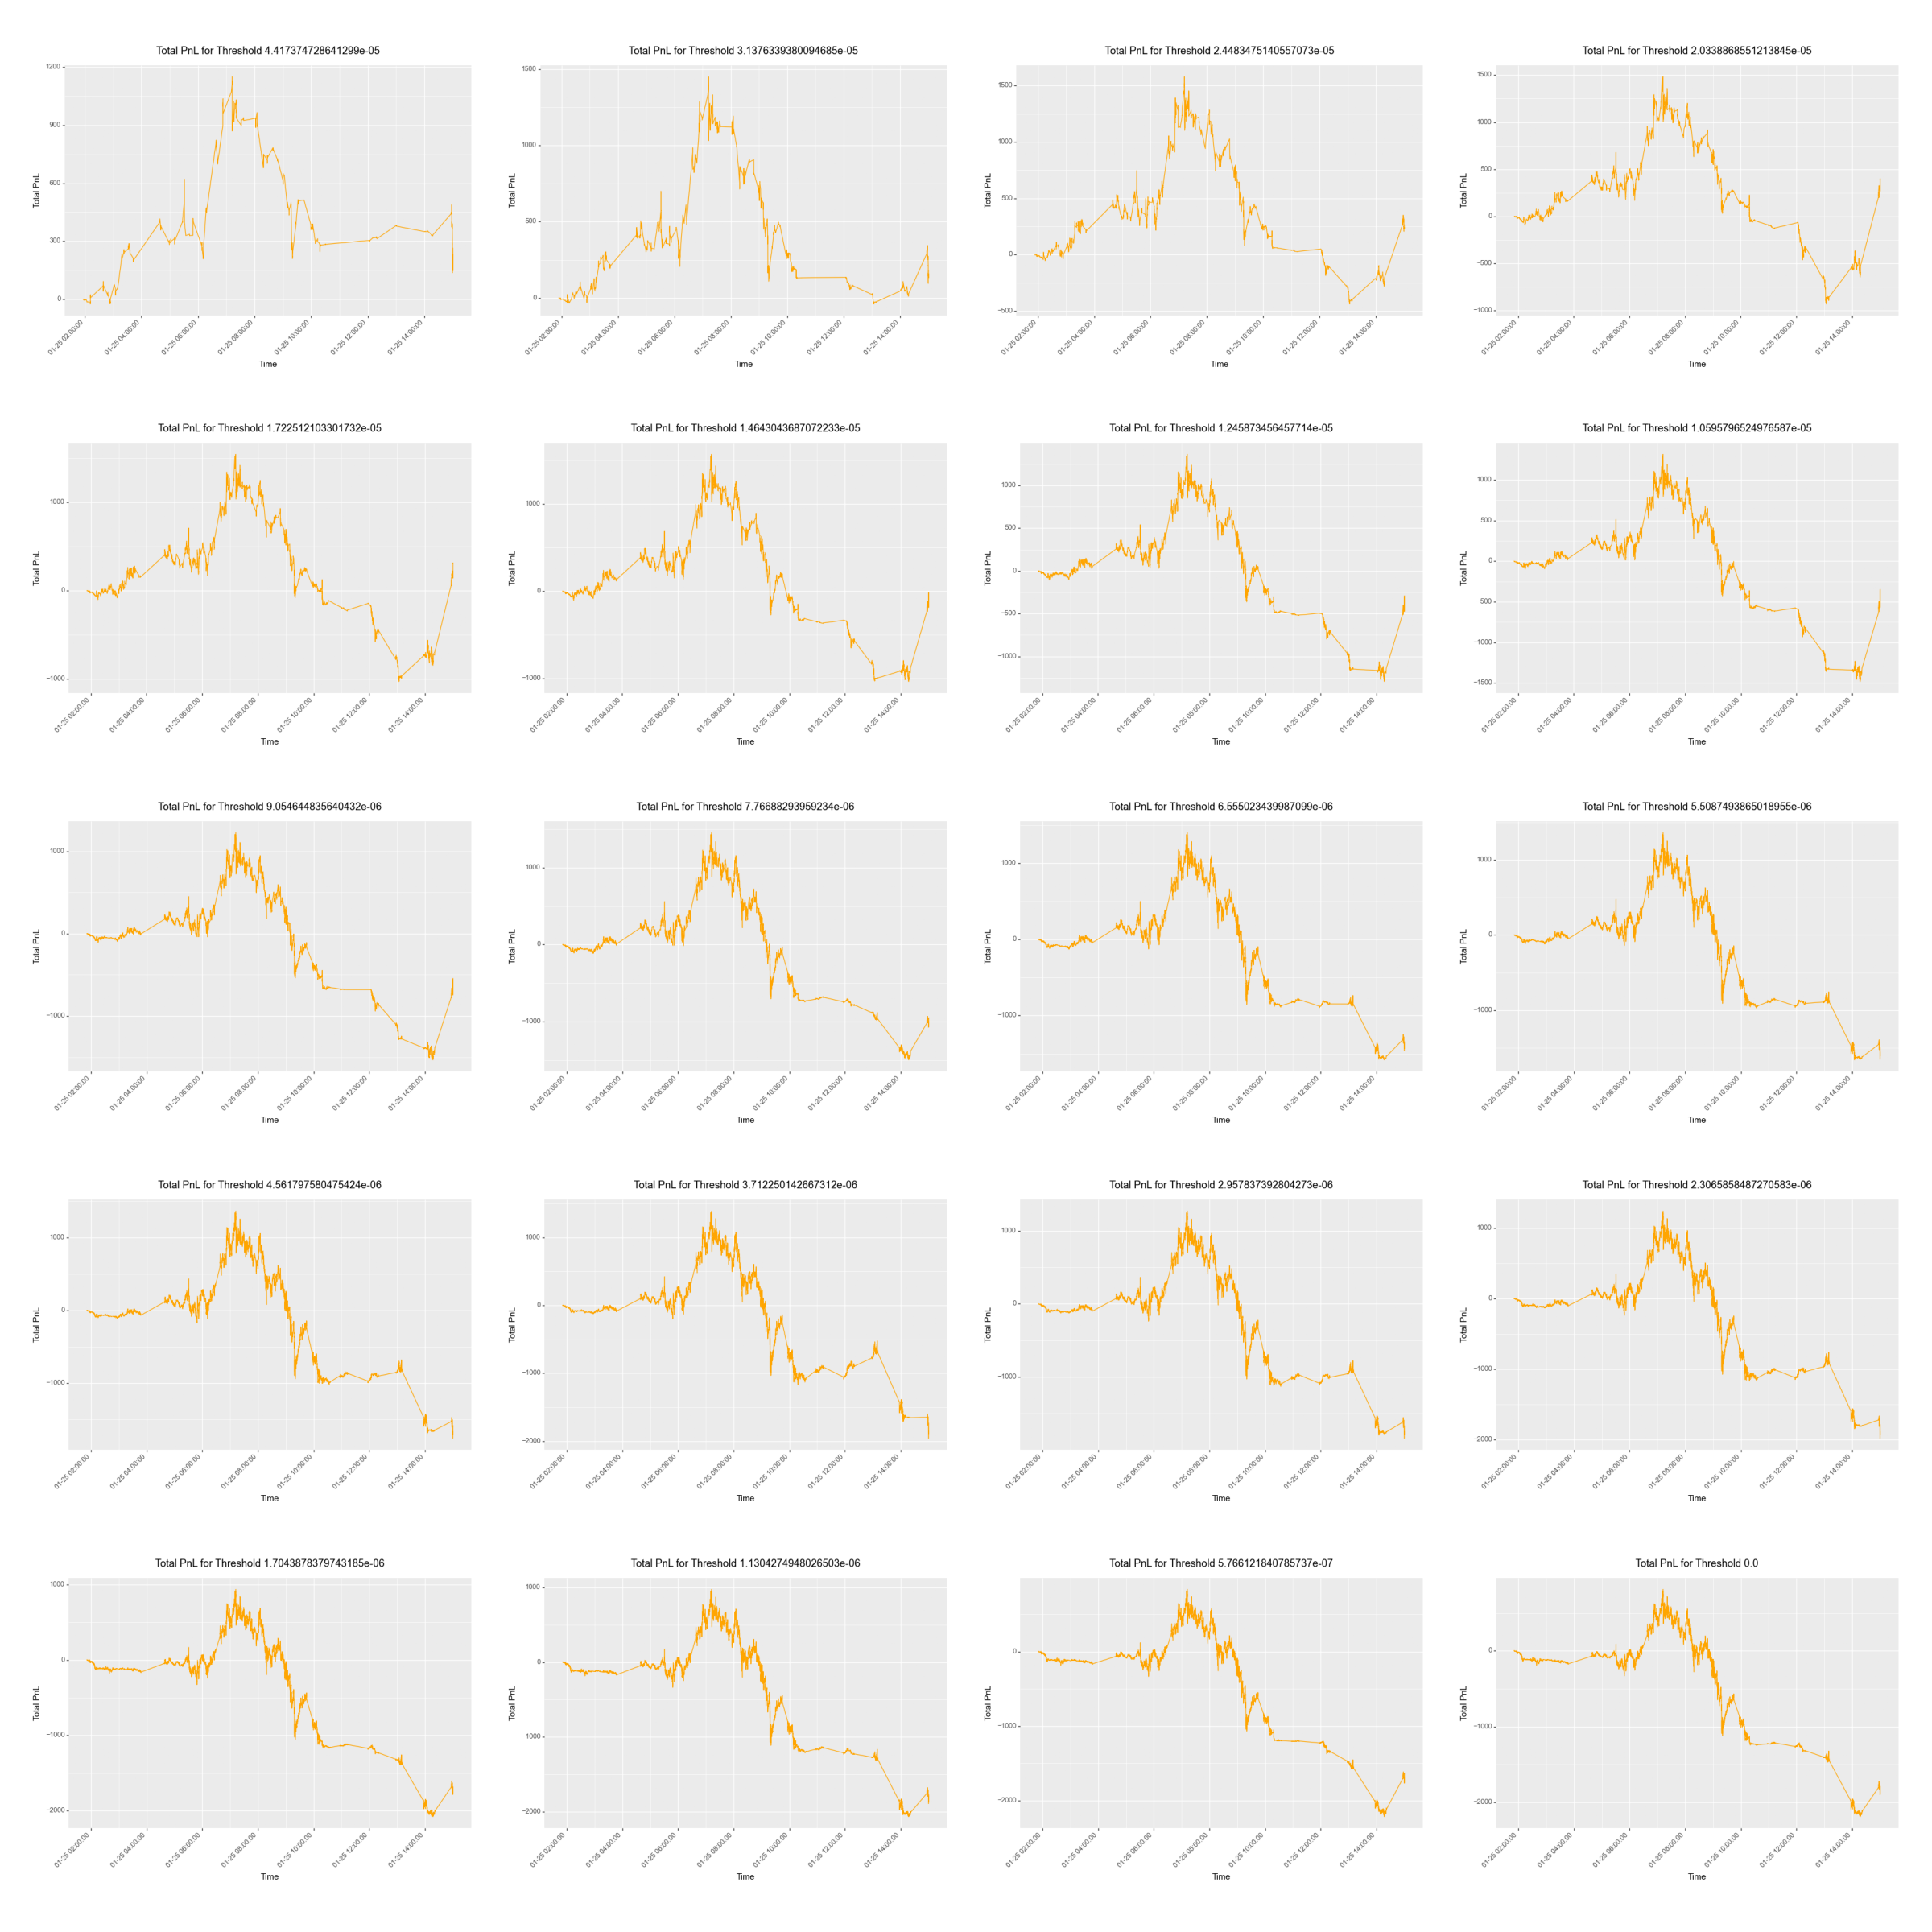

In [52]:
fig, axes = plt.subplots(5, 4, figsize=(12, 12))
axes = axes.flatten()

for i, ele in enumerate(threshold_strat_list):
    df = ele[0].trading_log
    threshold = ele[1]
    
    image = get_plot_as_image(df, threshold)
    axes[i].imshow(image)
    axes[i].axis('off')


plt.tight_layout()
plt.show()

#### We don't actually have positive PnL except in the cases where the threshold has a percent of trades at or less than 30%. Let us observe these graphs specifically to see if we notice any patterns or ranges that seem particularly profitable.

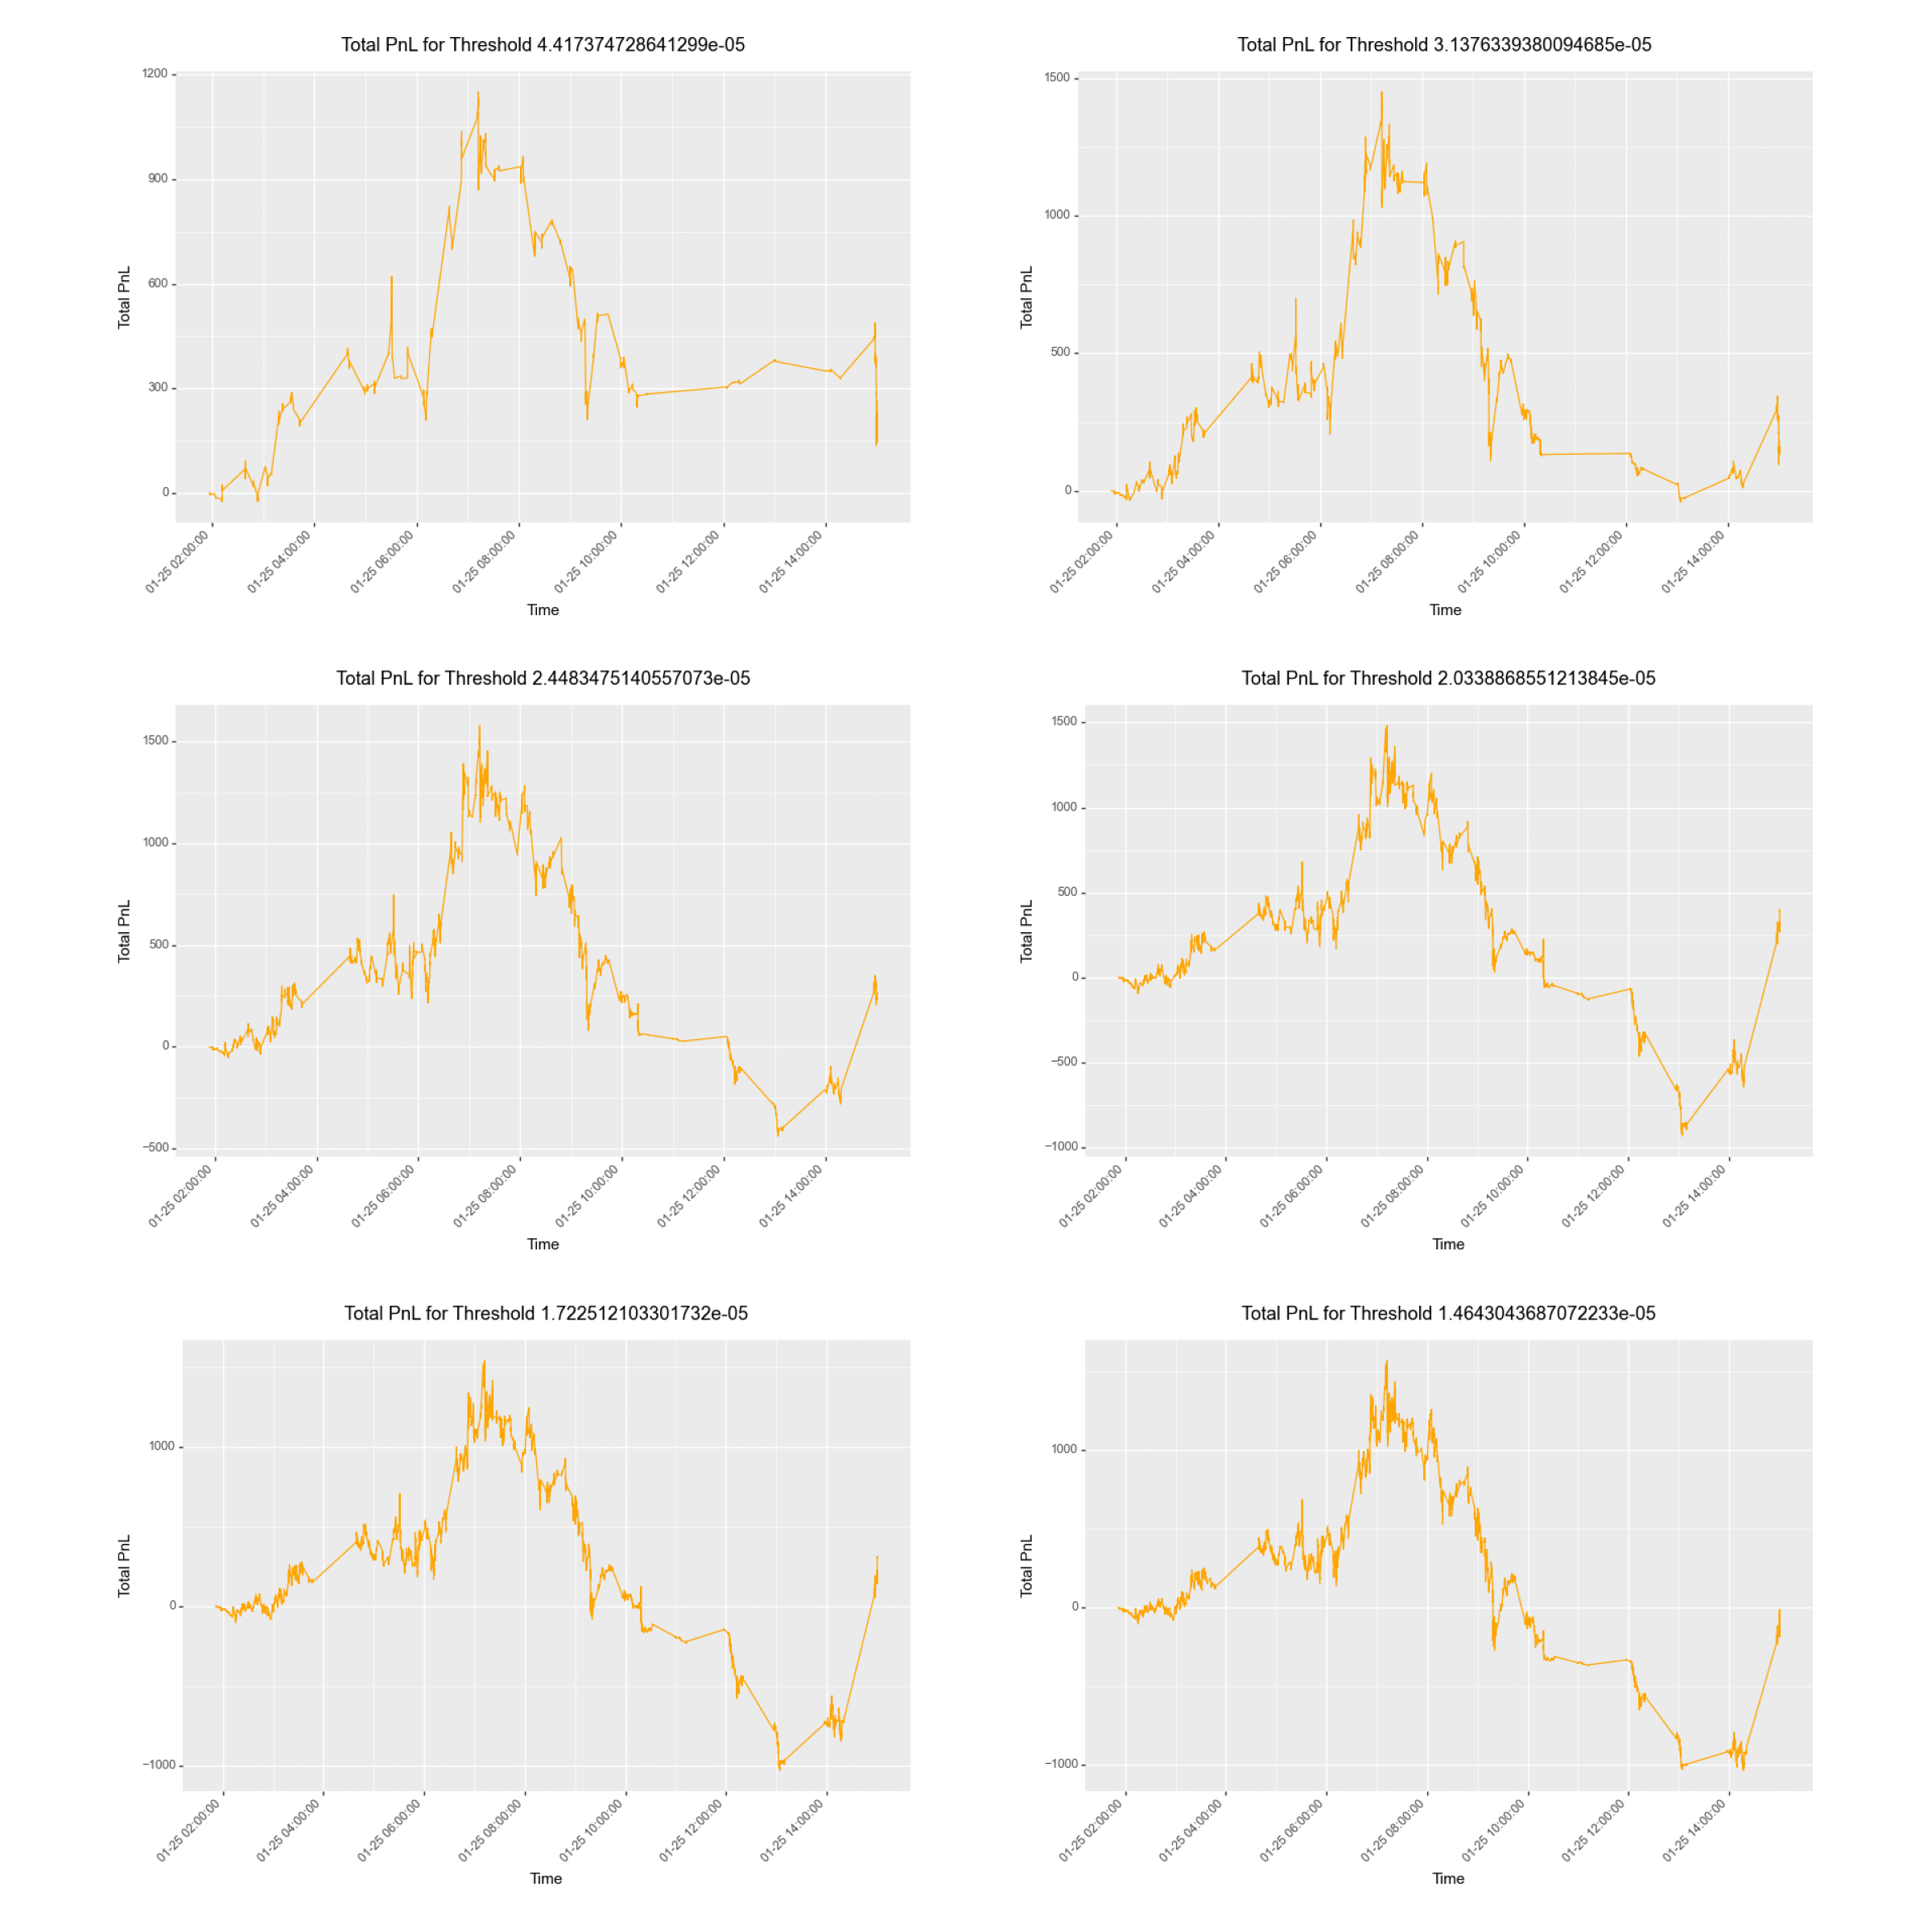

In [53]:
reduced_threshold_strat_list = threshold_strat_list[:6]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, ele in enumerate(reduced_threshold_strat_list):
    df = ele[0].trading_log
    threshold = ele[1]

    image = get_plot_as_image(df, threshold)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### Looking at these graphs, it is interesting to see that the lowest two thresholds actually only run a small negative cumulative PnL at any given time. This can pose an advantage for a trader that wants to be a bit more risk-adverse, but for traders that want a higher PnL and are willing to be more risky, we see that the range between 20%-25% seems most promising. So, we are going to get granular between these two types of trades: one for the risk-adverse and one for the profit-driven. Let us examine the safer of the two options first.

In [54]:
strat_thresh_5_pct = reduced_threshold_strat_list[0]
strat_thresh_10_pct = reduced_threshold_strat_list[1]

safe_threshold_pct_list = list(np.arange(0.06, 0.1, 0.01))
# Remove the last entry due to float point error
safe_threshold_pct_list = safe_threshold_pct_list[:4]
safe_threshold_list = []
test_df = second_tau_and_T_train_attempt_tfs.testing_data

for threshold_pct in safe_threshold_pct_list:
    safe_threshold_list.append(find_threshold_value_by_percentage(test_df, threshold_pct))

In [55]:
safer_threshold_strat_list = [strat_thresh_5_pct]

for threshold in safe_threshold_list:
    tfs = TradeFlowStrategy(
    second_tau_and_T_finished_eth_usd_trade_train, 
    second_tau_and_T_finished_eth_usd_trade_test, 
    threshold, 
    0.00001)
    tfs.run_strategy()
    
    safer_threshold_strat_list.append((tfs, threshold))
    
safer_threshold_strat_list.append(strat_thresh_10_pct)

Running strategy on testing set: 100%|██████████| 99798/99798 [00:31<00:00, 3172.88it/s]


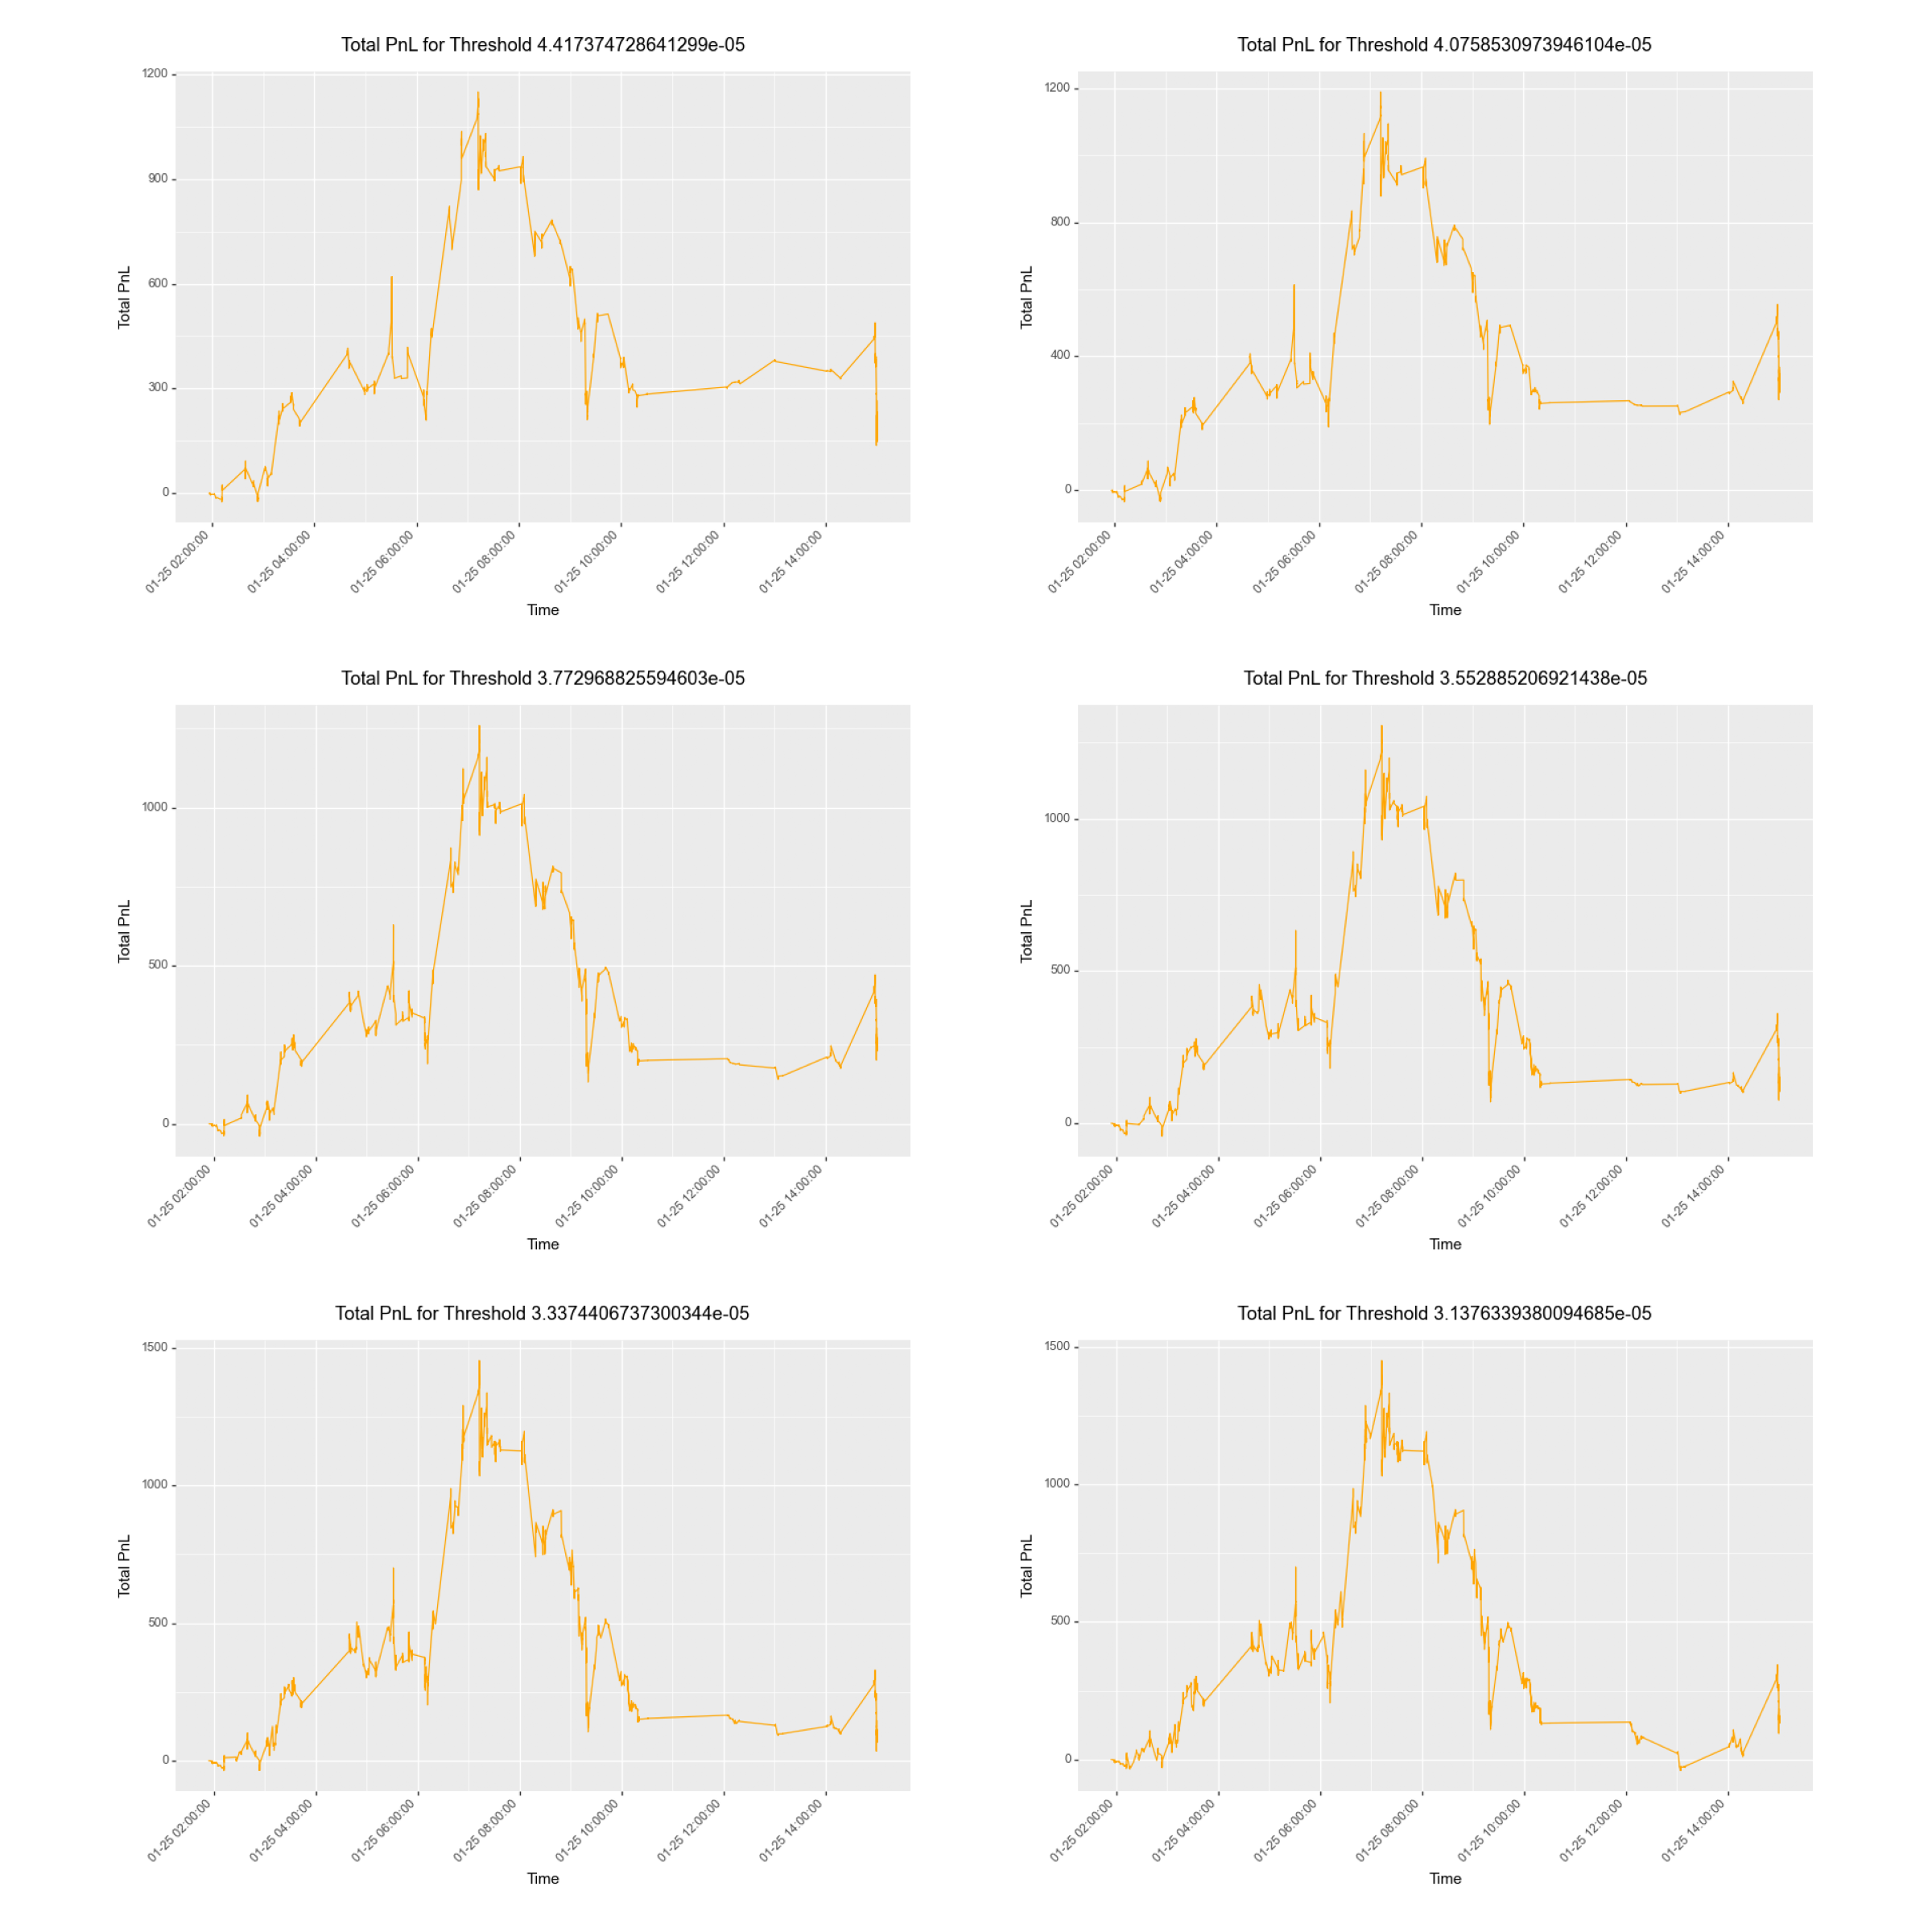

In [56]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, ele in enumerate(safer_threshold_strat_list):
    df = ele[0].trading_log
    threshold = ele[1]

    image = get_plot_as_image(df, threshold)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

#### For these lower higher thresholds, it appears as though the lower number is more suitable for a risk-adverse strategy, so we will define our SAFE_THRESHOLD_VALUE to be 0.06 (highest PnL of these strategies). Since we really don't see huge fluctuations in PnL movement at these threshold scales of 0.01, we will just set the RISKY_THRESHOLD_VALUE to be 0.2, as it delivered good PnL before.

In [57]:
OptimalParameters.SAFE_THRESHOLD_PCT = 0.06
OptimalParameters.RISKY_THRESHOLD_PCT = 0.2

#### We saw favorable movements in PnL as we adjusted our values of tau and T, so we will now examine each one specifically to see if we can arrive at optimal values for these two as well. First. we will see the impact of tau on our PnL.

In [68]:
third_tau = 30

third_tau_second_T_trade_flow_eth_usd_trade_train = calculate_trade_flow(long_consolidated_eth_usd_trade_train, third_tau)
third_tau_second_T_finished_eth_usd_trade_train = calculate_forward_returns(third_tau_second_T_trade_flow_eth_usd_trade_train, second_T).dropna()

third_tau_second_T_finished_eth_usd_trade_test = calculate_trade_flow(short_consolidated_eth_usd_trade_test, third_tau).dropna()
third_tau_second_T_finished_eth_usd_trade_test.set_index('timestamp', inplace=True)

In [59]:
third_tau_second_T_train_attempt_tfs = TradeFlowStrategy(
    third_tau_second_T_finished_eth_usd_trade_train, 
    third_tau_second_T_finished_eth_usd_trade_test, 
    0, 
    0.00001,
    False)

third_tau_second_T_train_attempt_tfs.make_return_predictions()
threshold = find_threshold_value_by_percentage(third_tau_second_T_train_attempt_tfs.testing_data, 
                                               OptimalParameters.RISKY_THRESHOLD_PCT)

third_tau_second_T_train_attempt_tfs.threshold = threshold

third_tau_second_T_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99766/99766 [00:39<00:00, 2516.62it/s]


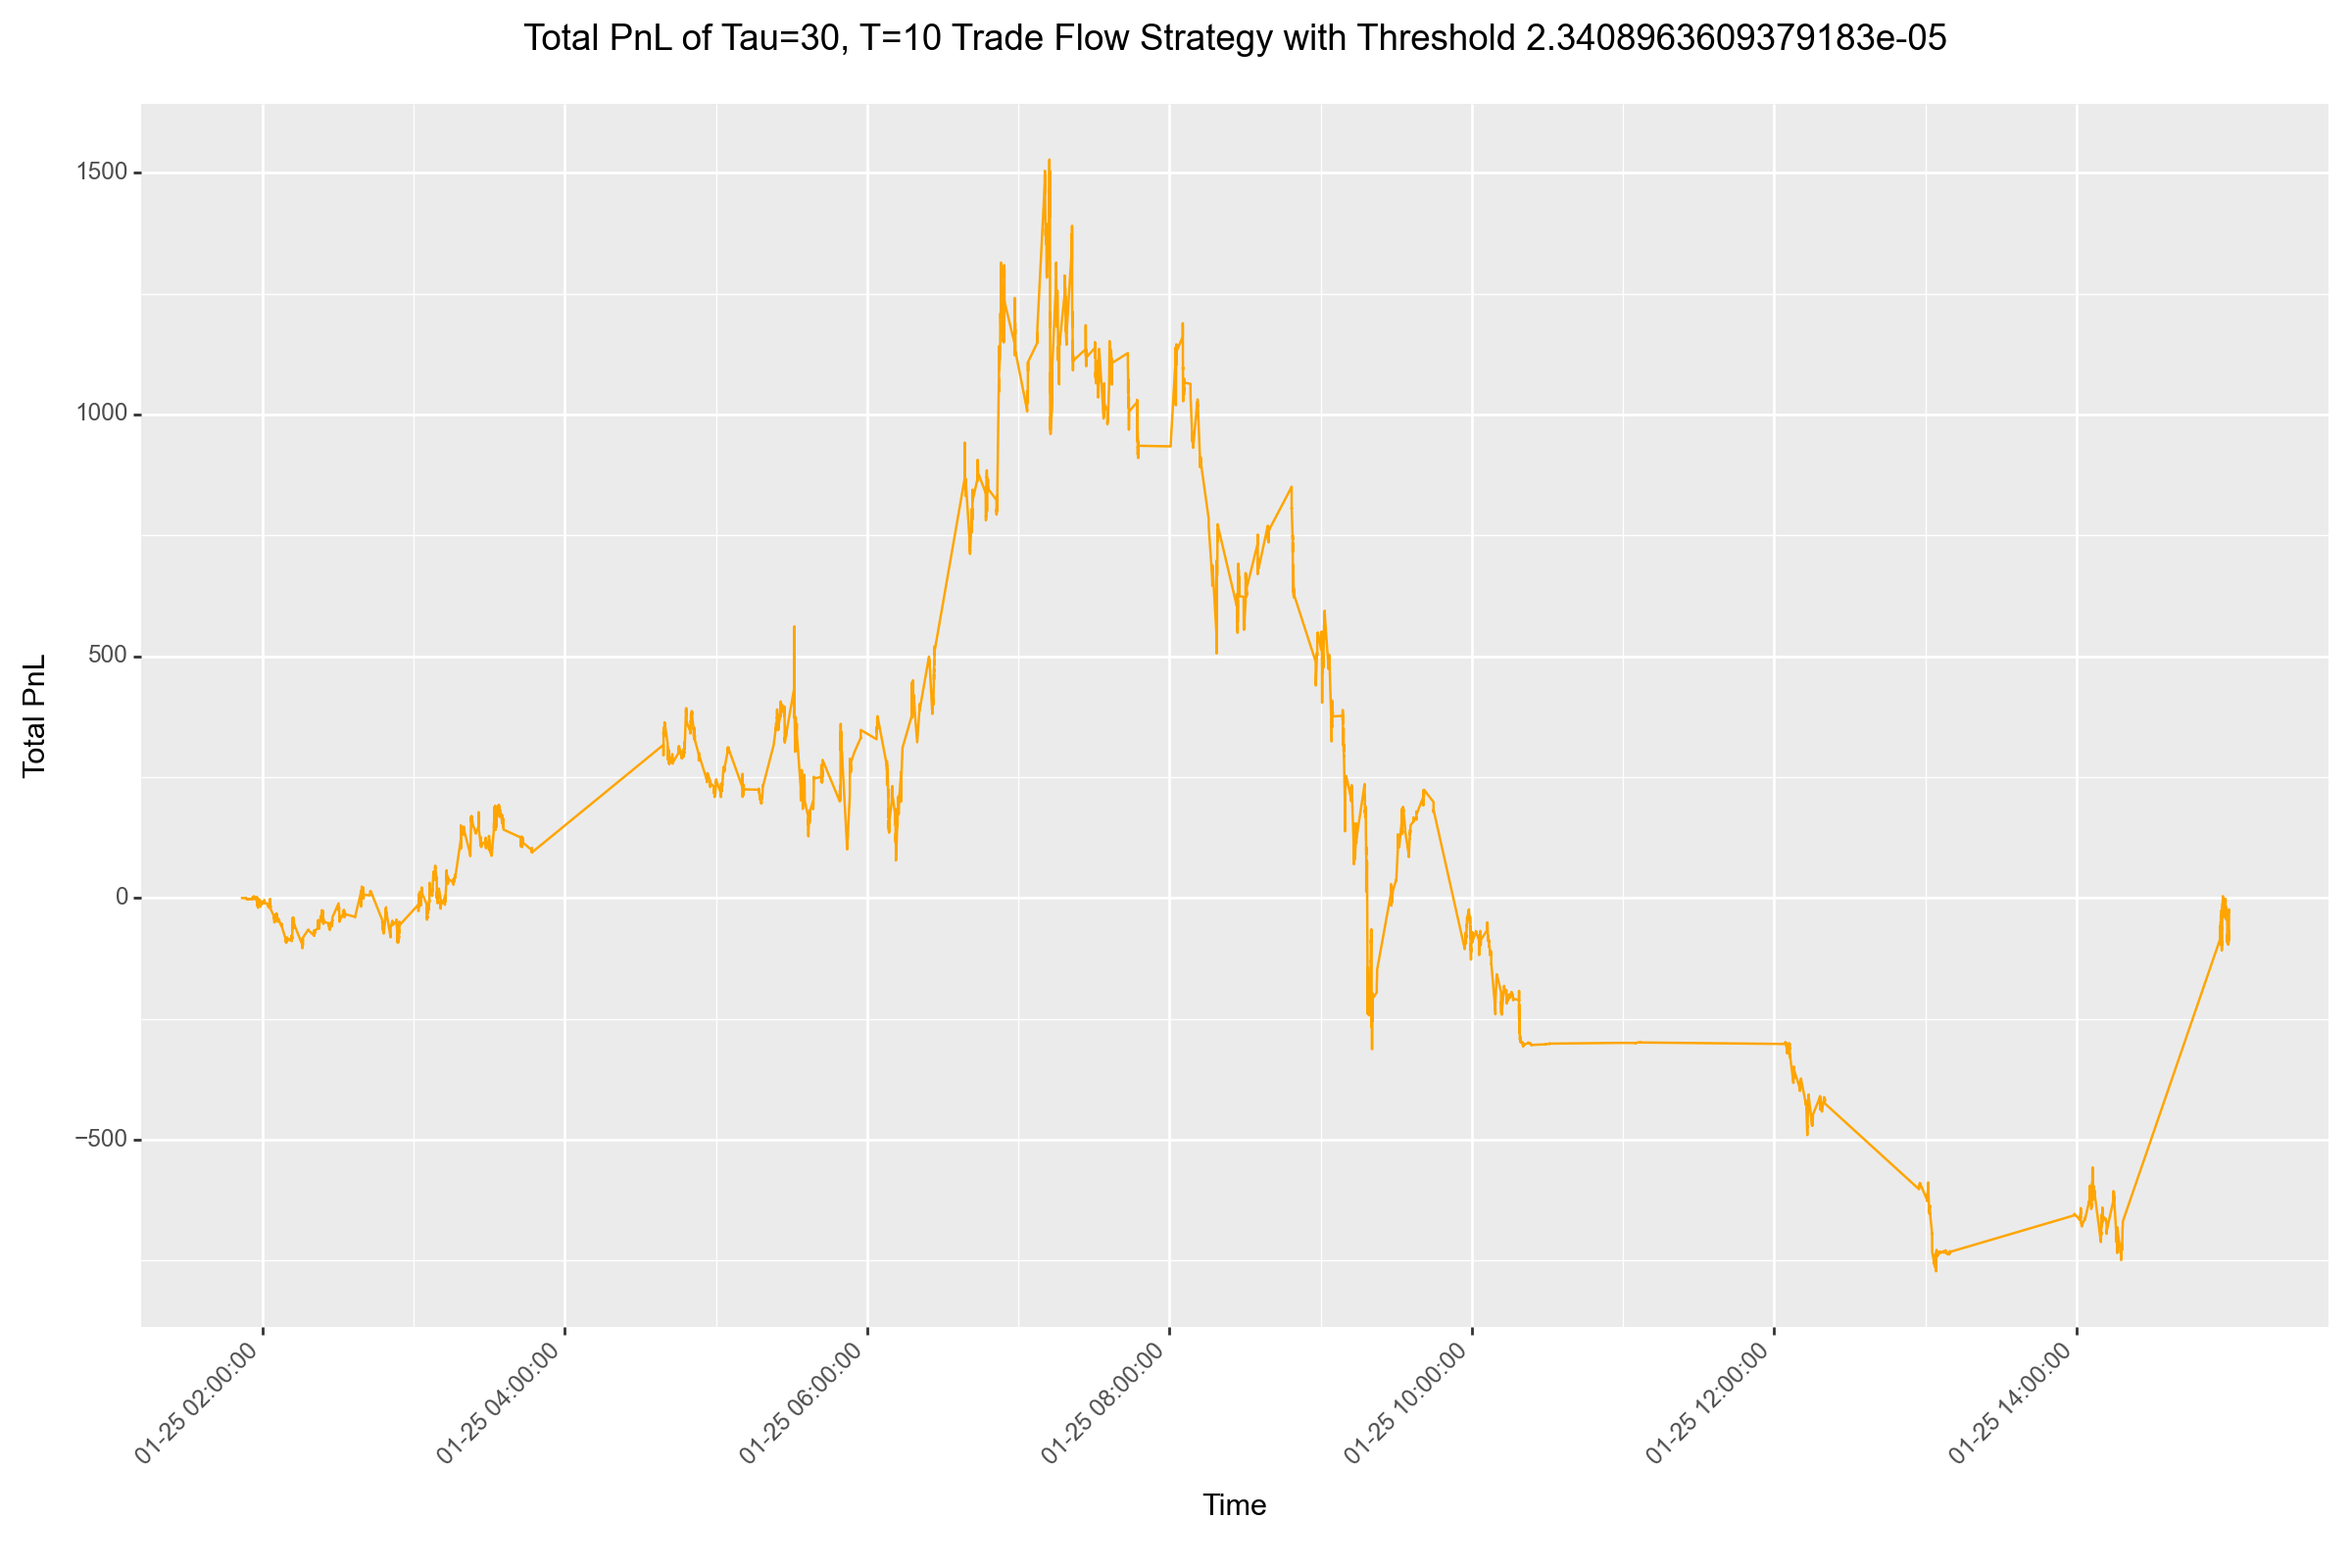

In [61]:
df = third_tau_second_T_train_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

third_tau_second_T_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title=f'Total PnL of Tau=30, T=10 Trade Flow Strategy with Threshold {threshold}',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

third_tau_second_T_attempt_pnl_plot.draw()

#### We see the PnL decrease with this increase in tau value, so let us try a final tau value in between 20 and 10 to see if we arrive at a better PnL using a value of tau at 15.

In [63]:
fourth_tau = 15

fourth_tau_second_T_trade_flow_eth_usd_trade_train = calculate_trade_flow(long_consolidated_eth_usd_trade_train, fourth_tau)
fourth_tau_second_T_finished_eth_usd_trade_train = calculate_forward_returns(fourth_tau_second_T_trade_flow_eth_usd_trade_train, second_T).dropna()

fourth_tau_second_T_finished_eth_usd_trade_test = calculate_trade_flow(short_consolidated_eth_usd_trade_test, fourth_tau).dropna()
fourth_tau_second_T_finished_eth_usd_trade_test.set_index('timestamp', inplace=True)

Price      Size  Side  trade_flow
timestamp                                                       
2023-01-25 01:50:51.692233  1533.910  0.015170     1   19.431042
2023-01-25 01:50:51.911840  1533.910  0.178900     1   19.446211
2023-01-25 01:50:51.911967  1533.915  0.213980     1   19.625111
2023-01-25 01:50:52.120174  1533.920  0.188970     1   19.839091
2023-01-25 01:50:52.257191  1533.925  0.185310     1   20.028061
...                              ...       ...   ...         ...
2023-01-25 15:00:30.318655  1533.320  4.554000     1 -158.555962
2023-01-25 15:00:30.318708  1533.335  7.617833     1 -154.001962
2023-01-25 15:00:30.319185  1533.310  2.095787     1 -146.384130
2023-01-25 15:00:30.330265  1533.310  1.181857     1 -144.288343
2023-01-25 15:00:30.376266  1533.300  0.040724     1 -143.106486

[99813 rows x 4 columns]

In [64]:
fourth_tau_second_T_train_attempt_tfs = TradeFlowStrategy(
    fourth_tau_second_T_finished_eth_usd_trade_train, 
    fourth_tau_second_T_finished_eth_usd_trade_test, 
    0, 
    0.00001,
    False)

fourth_tau_second_T_train_attempt_tfs.make_return_predictions()
threshold = find_threshold_value_by_percentage(fourth_tau_second_T_train_attempt_tfs.testing_data, 
                                               OptimalParameters.RISKY_THRESHOLD_PCT)

fourth_tau_second_T_train_attempt_tfs.threshold = threshold

fourth_tau_second_T_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99813/99813 [00:49<00:00, 2035.15it/s]


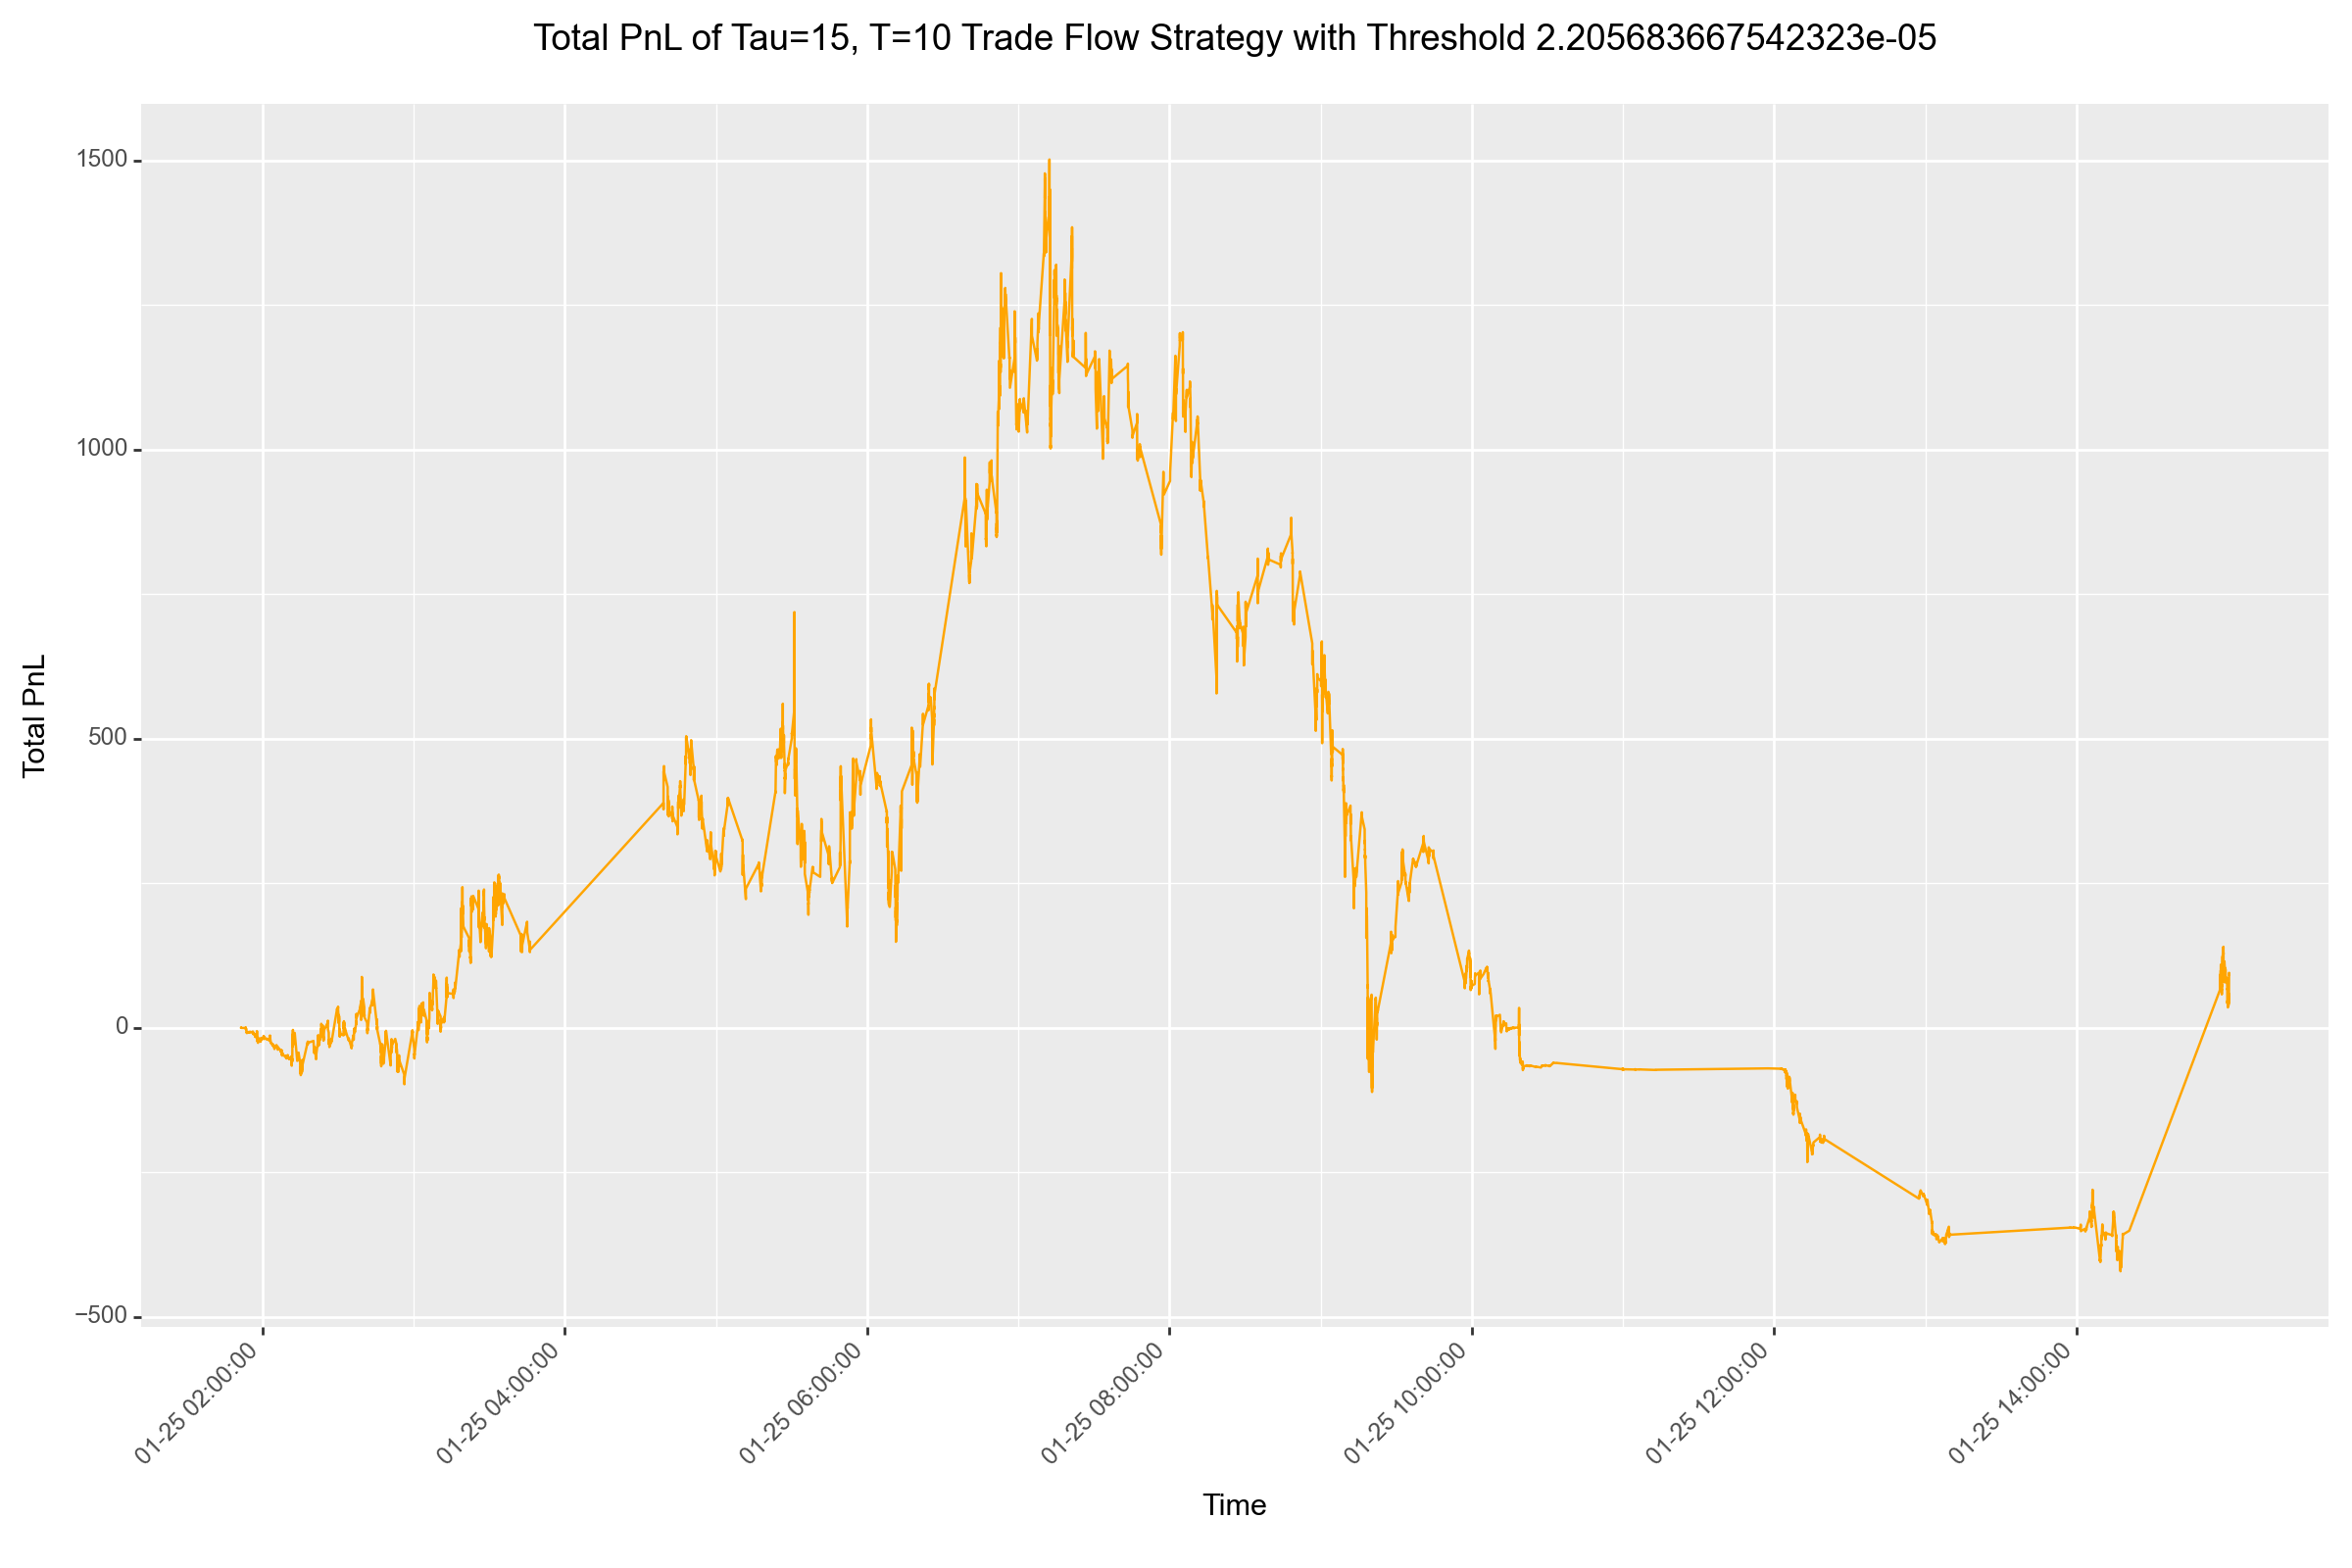

In [67]:
df = fourth_tau_second_T_train_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

fourth_tau_second_T_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title=f'Total PnL of Tau=15, T=10 Trade Flow Strategy with Threshold {threshold}',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

fourth_tau_second_T_attempt_pnl_plot.draw()

#### Unfortunately, this did not yield great results as we would have liked, so we are going to stick with a value of tau at 20 for now. With this value of tau, let us now explore a few other values of T. We are going to implement 3 new strategies, where we have T=3 (like our first attempt), T=15, and a final value exploring another T based on the best result from these two strategies. Note that we already have T=10 and tau=20, so we can compare our two new values of T to see if there is any benefit in changing T relative to tau. 

#### Note: For this section, we are going to be hard-coding the threshold value. Please skip the explanation below this section to understand why we have done this.

In [100]:
second_tau_first_T_trade_flow_eth_usd_trade_train = calculate_trade_flow(long_consolidated_eth_usd_trade_train, second_tau)
second_tau_first_T_finished_eth_usd_trade_train = calculate_forward_returns(second_tau_first_T_trade_flow_eth_usd_trade_train, T).dropna()

second_tau_first_T_finished_eth_usd_trade_test = calculate_trade_flow(short_consolidated_eth_usd_trade_test, second_tau).dropna()
second_tau_first_T_finished_eth_usd_trade_test.set_index('timestamp', inplace=True)

In [101]:
second_tau_first_T_train_attempt_tfs = TradeFlowStrategy(
    second_tau_first_T_finished_eth_usd_trade_train, 
    second_tau_first_T_finished_eth_usd_trade_test, 
    10**(-5), 
    0.00001)

second_tau_first_T_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99798/99798 [00:42<00:00, 2348.77it/s]


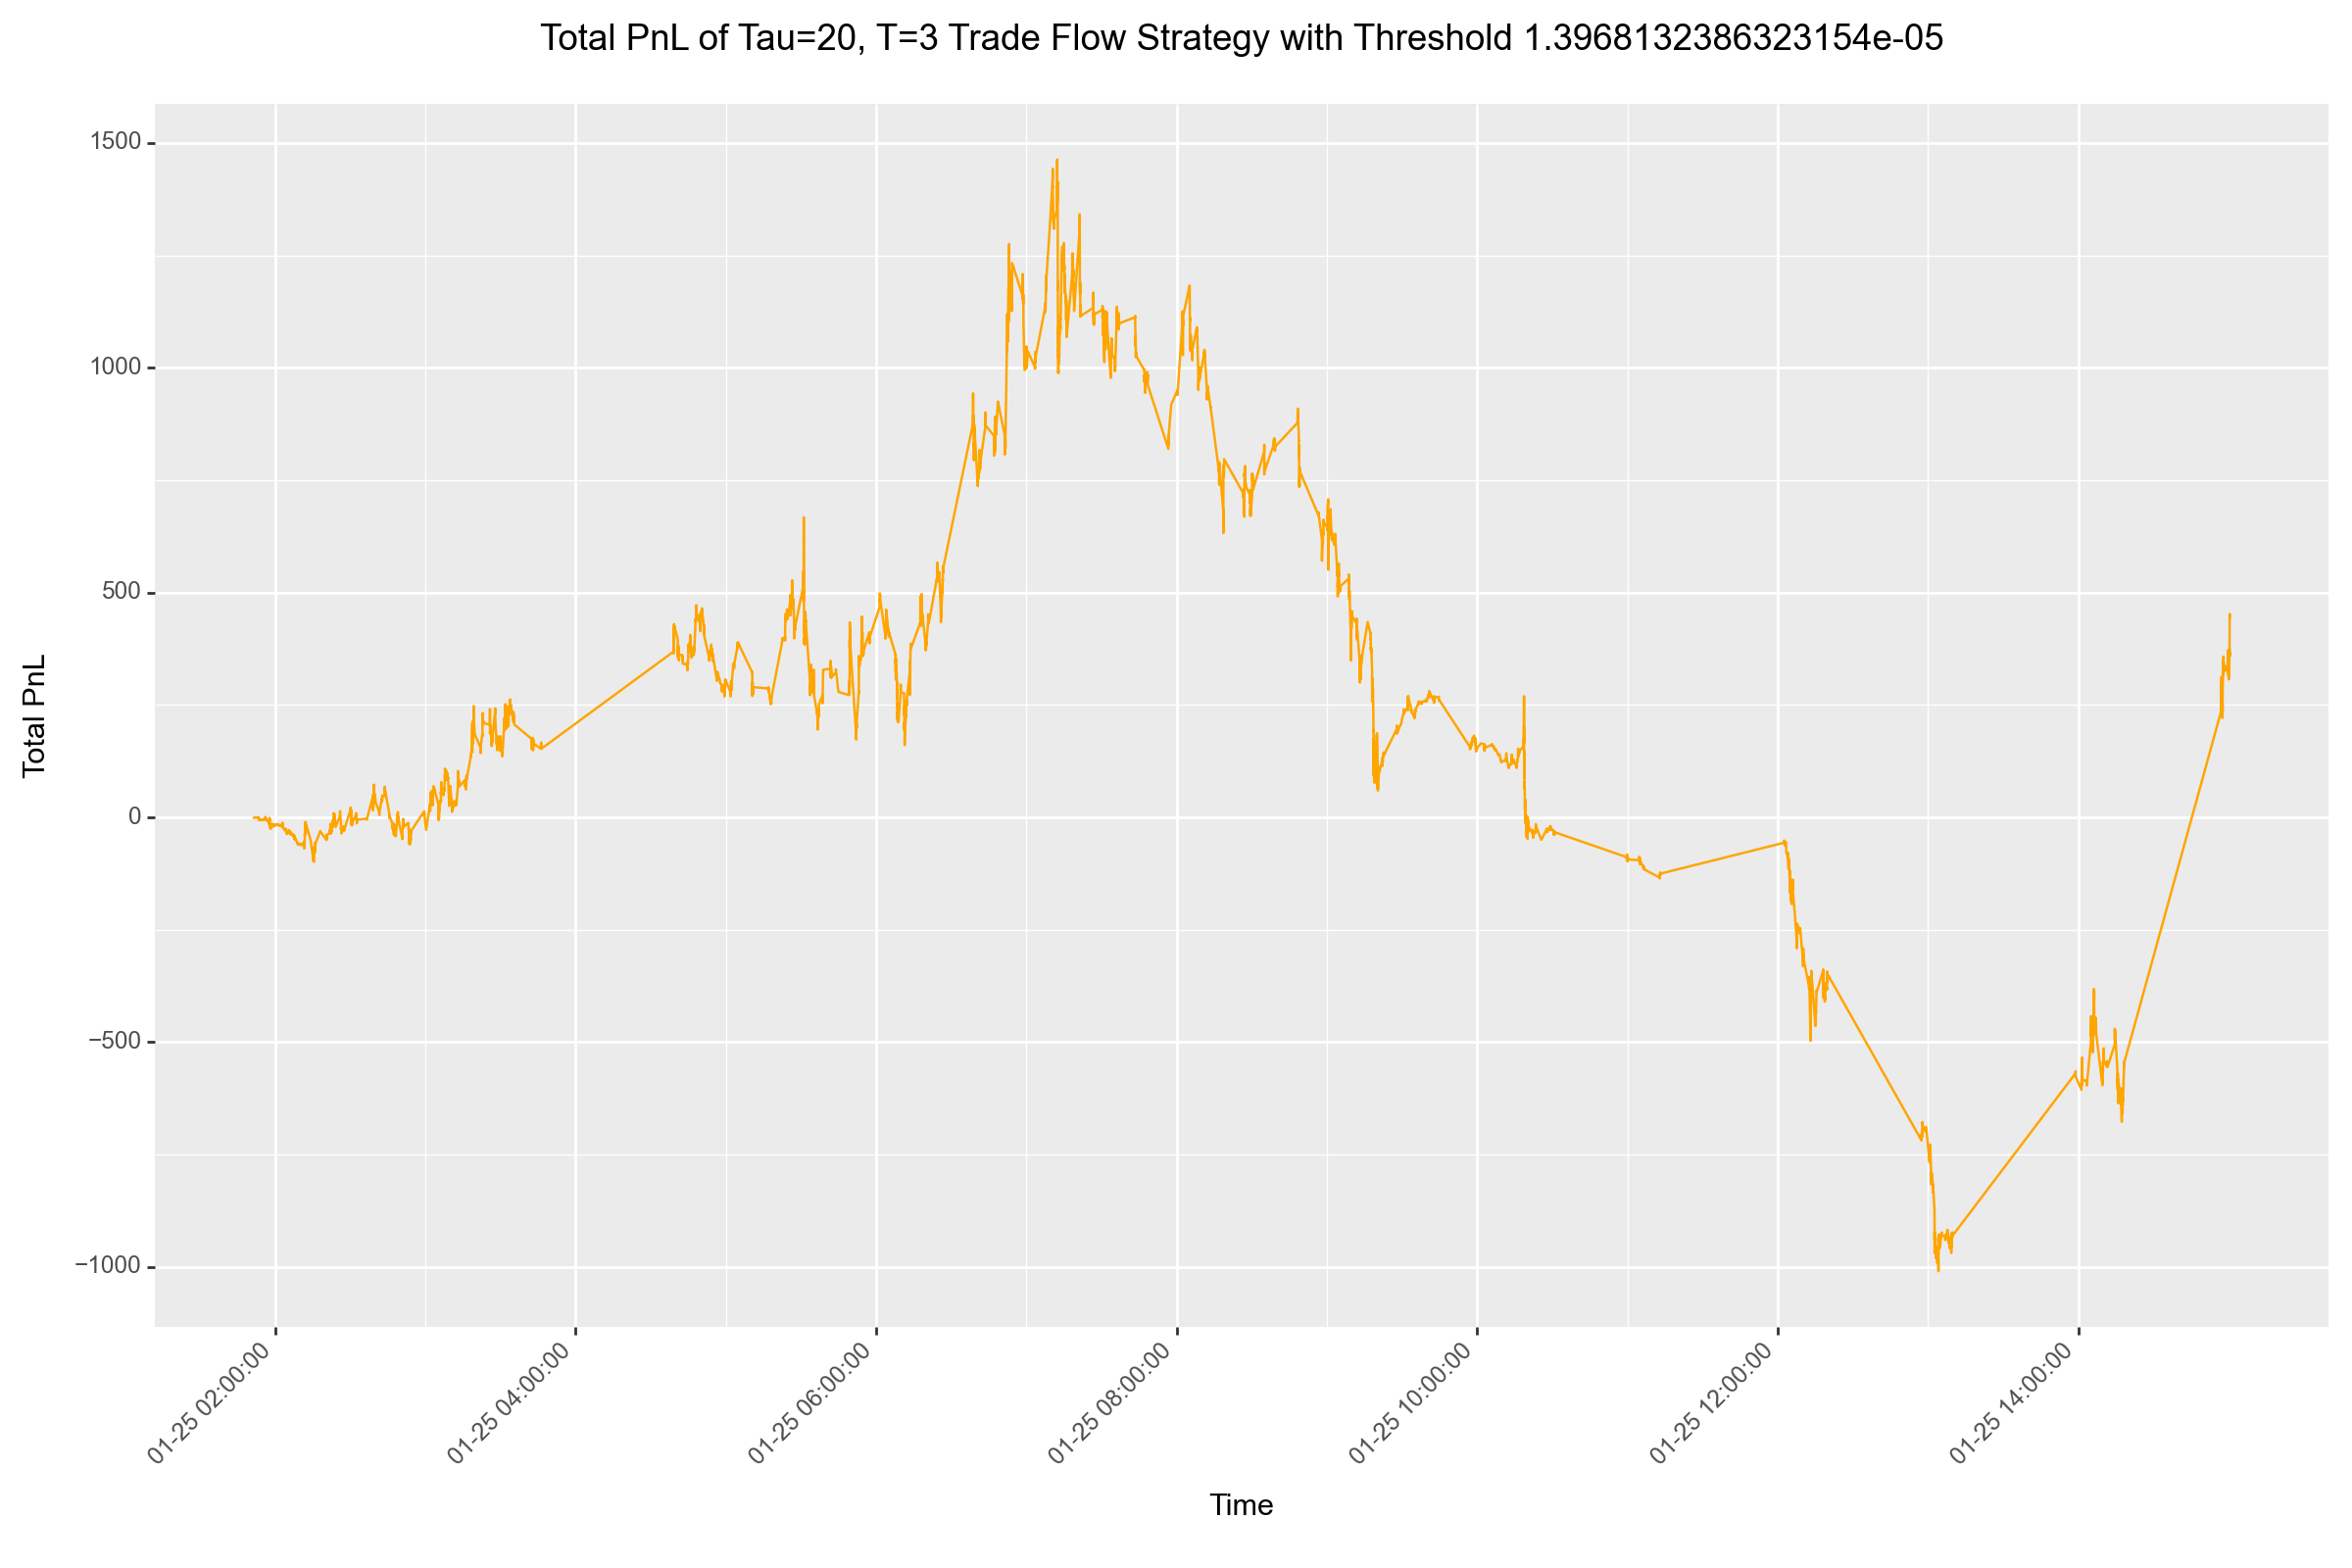

In [102]:
df = second_tau_first_T_train_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

second_tau_first_T_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title=f'Total PnL of Tau=20, T=3 Trade Flow Strategy with Threshold {threshold}',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

second_tau_first_T_attempt_pnl_plot.draw()

In [103]:
third_T = 15

second_tau_third_T_trade_flow_eth_usd_trade_train = calculate_trade_flow(long_consolidated_eth_usd_trade_train, second_tau)
second_tau_third_T_finished_eth_usd_trade_train = calculate_forward_returns(second_tau_third_T_trade_flow_eth_usd_trade_train, third_T).dropna()

second_tau_third_T_finished_eth_usd_trade_test = calculate_trade_flow(short_consolidated_eth_usd_trade_test, second_tau).dropna()
second_tau_third_T_finished_eth_usd_trade_test.set_index('timestamp', inplace=True)

In [104]:
second_tau_third_T_train_attempt_tfs = TradeFlowStrategy(
    second_tau_third_T_finished_eth_usd_trade_train, 
    second_tau_third_T_finished_eth_usd_trade_test, 
    10**(-5), 
    0.00001)

second_tau_third_T_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99798/99798 [00:52<00:00, 1899.71it/s]


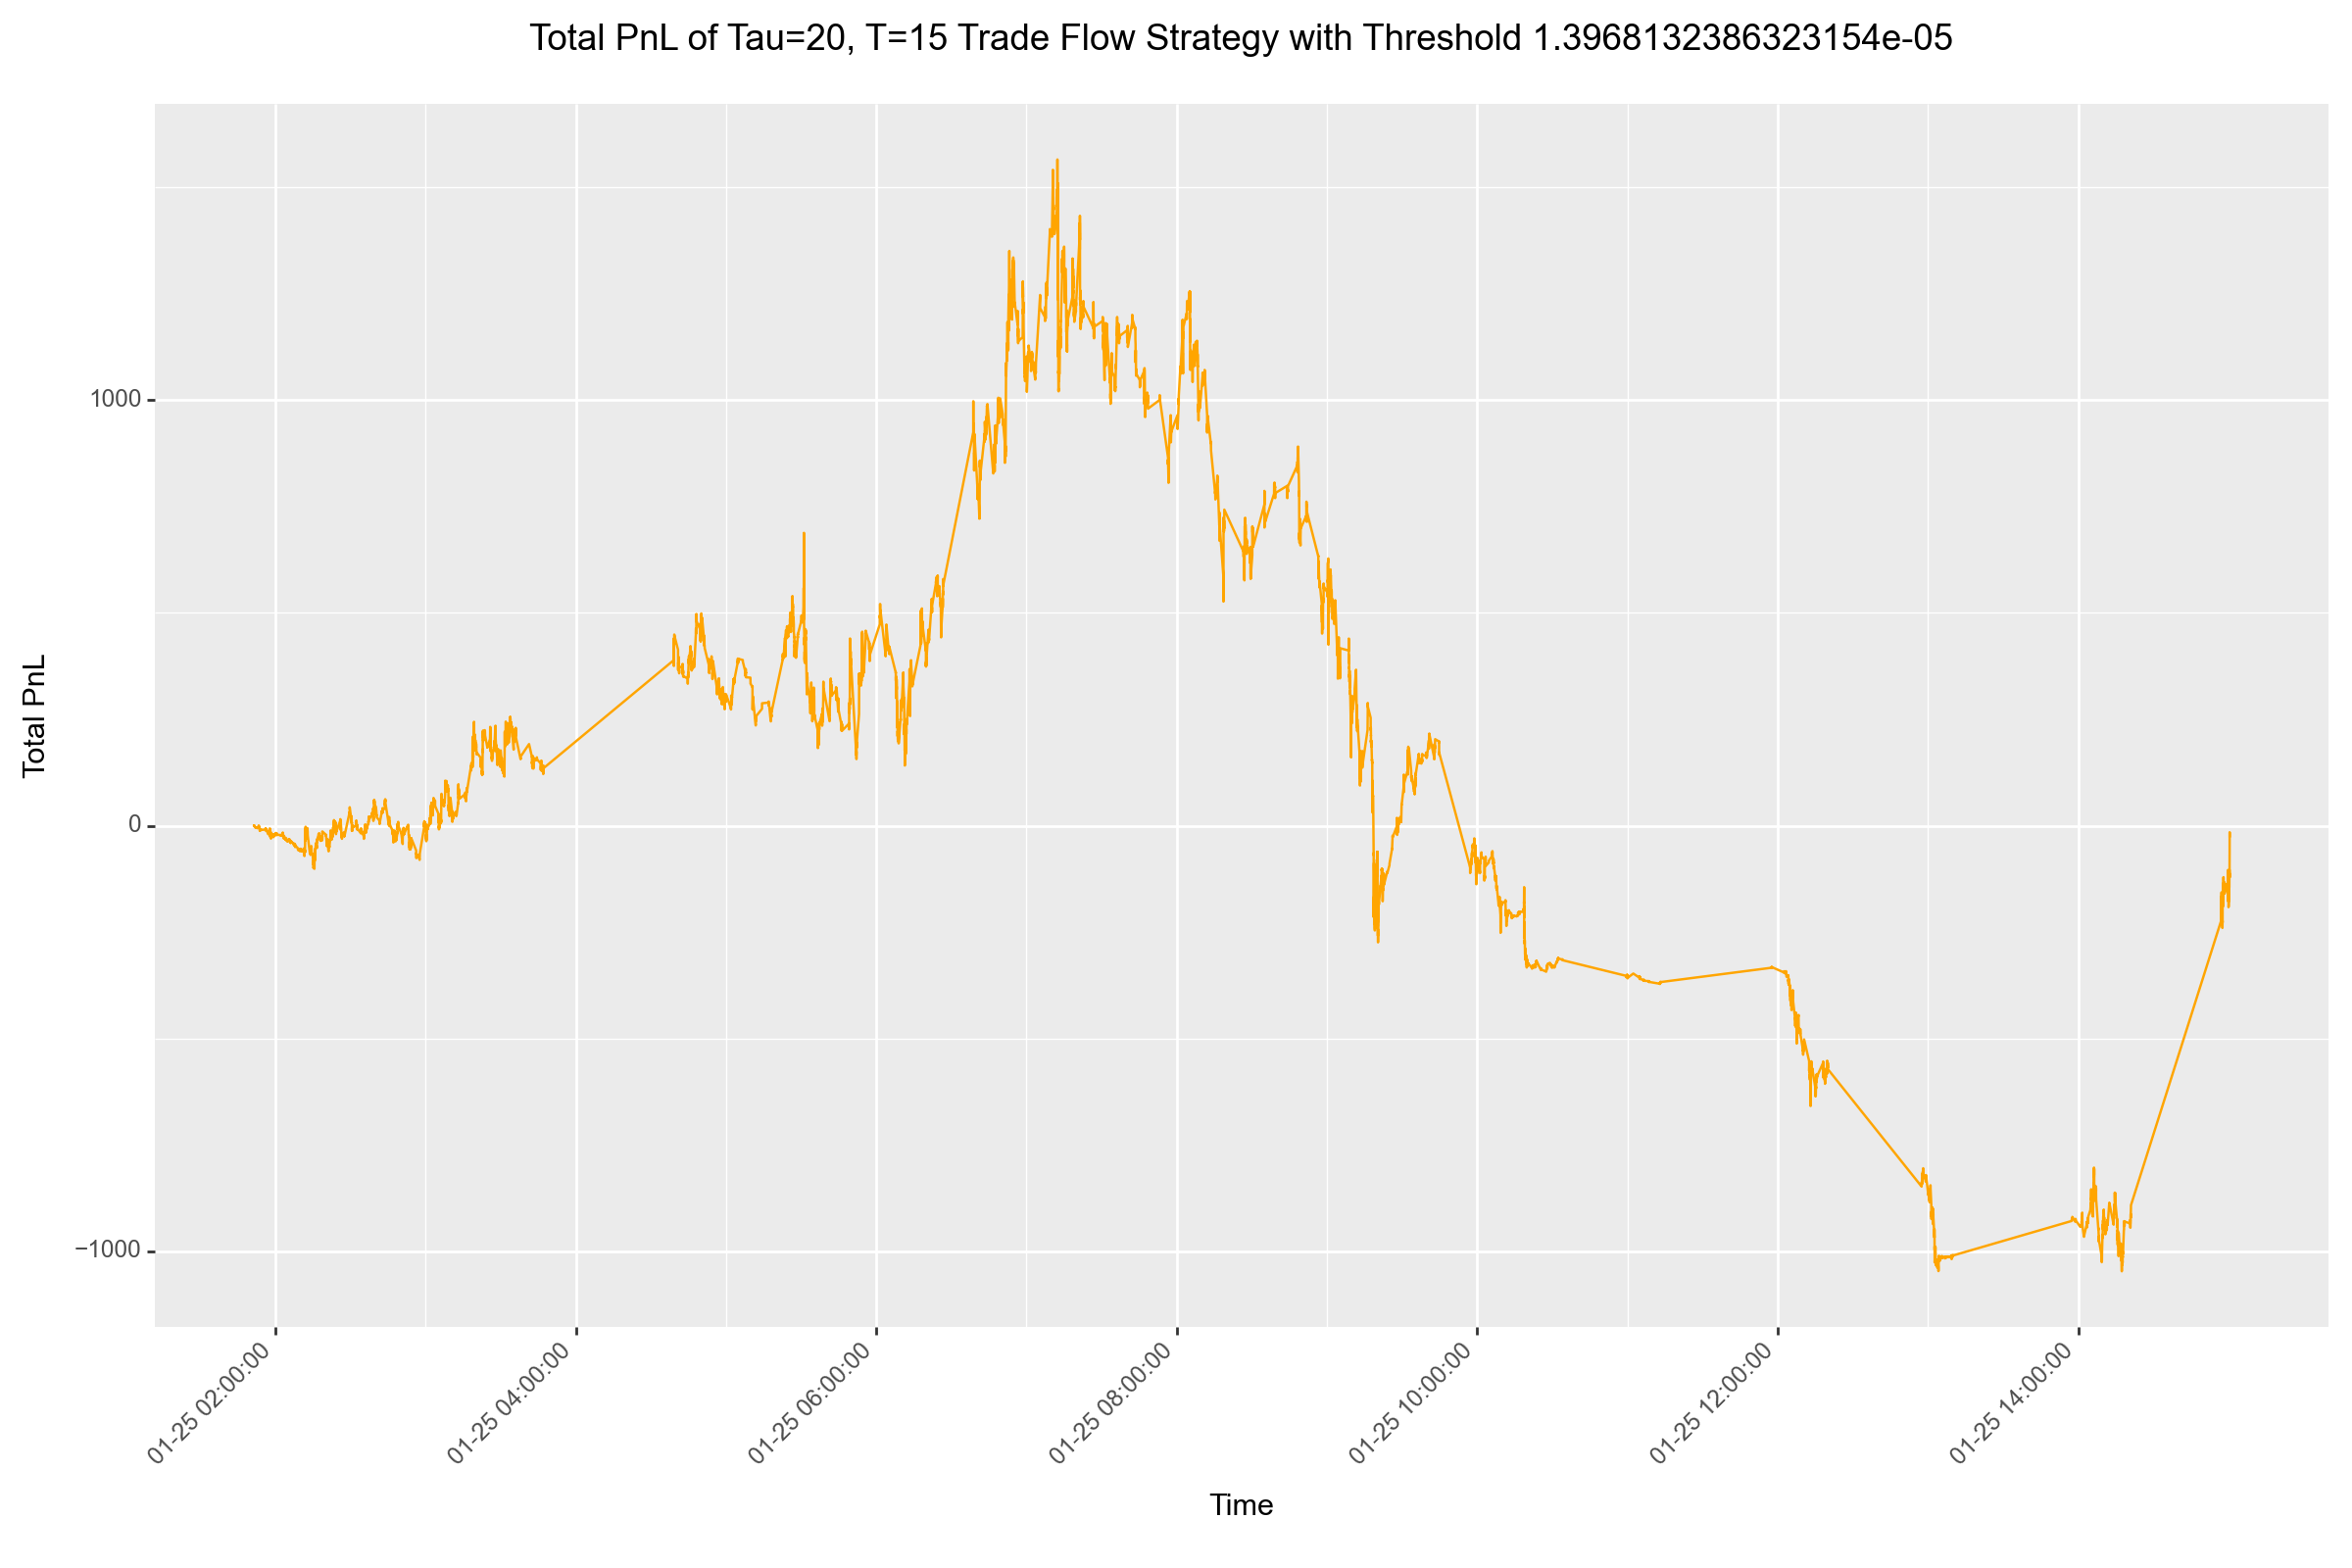

In [105]:
df = second_tau_third_T_train_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

second_tau_third_T_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title=f'Total PnL of Tau=20, T=15 Trade Flow Strategy with Threshold {threshold}',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

second_tau_third_T_attempt_pnl_plot.draw()

## EXPLANATION OF ISSUE:

#### Our trading logs were identical for the same value of tau when we had a constant percentage of threshold. This makes sense given how we have defined return_predictions, as they arise from the beta coefficient times our trade_flow. So, if trade_flow doesn't change (which it doesn't for differing values of T), then our return predictions will merely be scaled differently. Obviously this poses an issue for examining the effect of T on PnL, but there is a simple fix. Notice that we are fixing our threshold to be a fixed percentage amount, which is causing this scaling issue to be more pronounced. As such, we are going to retroactively go back and hard code threshold values of 10**(-5).

## Analyzing T:
 
#### We see that a larger value of T produces less favorable results, and as such our fourth value of T will be set to a look ahead period between our values of 10 and 3 seconds. Note that we are fixing the threshold, and this will have a huge impact on our PnL as we have seen. However, since we are looking to find an optimal T value right now, then we will simply keep it at this fixed value of 10**(-5). Once we are satisfied with our value of T, we can play with the threshold to examine the one that fits best with our value of T.

In [121]:
fourth_T = 5

second_tau_fourth_T_trade_flow_eth_usd_trade_train = calculate_trade_flow(long_consolidated_eth_usd_trade_train, second_tau)
second_tau_fourth_T_finished_eth_usd_trade_train = calculate_forward_returns(second_tau_fourth_T_trade_flow_eth_usd_trade_train, fourth_T).dropna()

second_tau_fourth_T_finished_eth_usd_trade_test = calculate_trade_flow(short_consolidated_eth_usd_trade_test, second_tau).dropna()
second_tau_fourth_T_finished_eth_usd_trade_test.set_index('timestamp', inplace=True)

In [122]:
second_tau_fourth_T_train_attempt_tfs = TradeFlowStrategy(
    second_tau_fourth_T_finished_eth_usd_trade_train, 
    second_tau_fourth_T_finished_eth_usd_trade_test, 
    10**(-5), 
    0.00001)

second_tau_fourth_T_train_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 99798/99798 [00:43<00:00, 2273.21it/s]


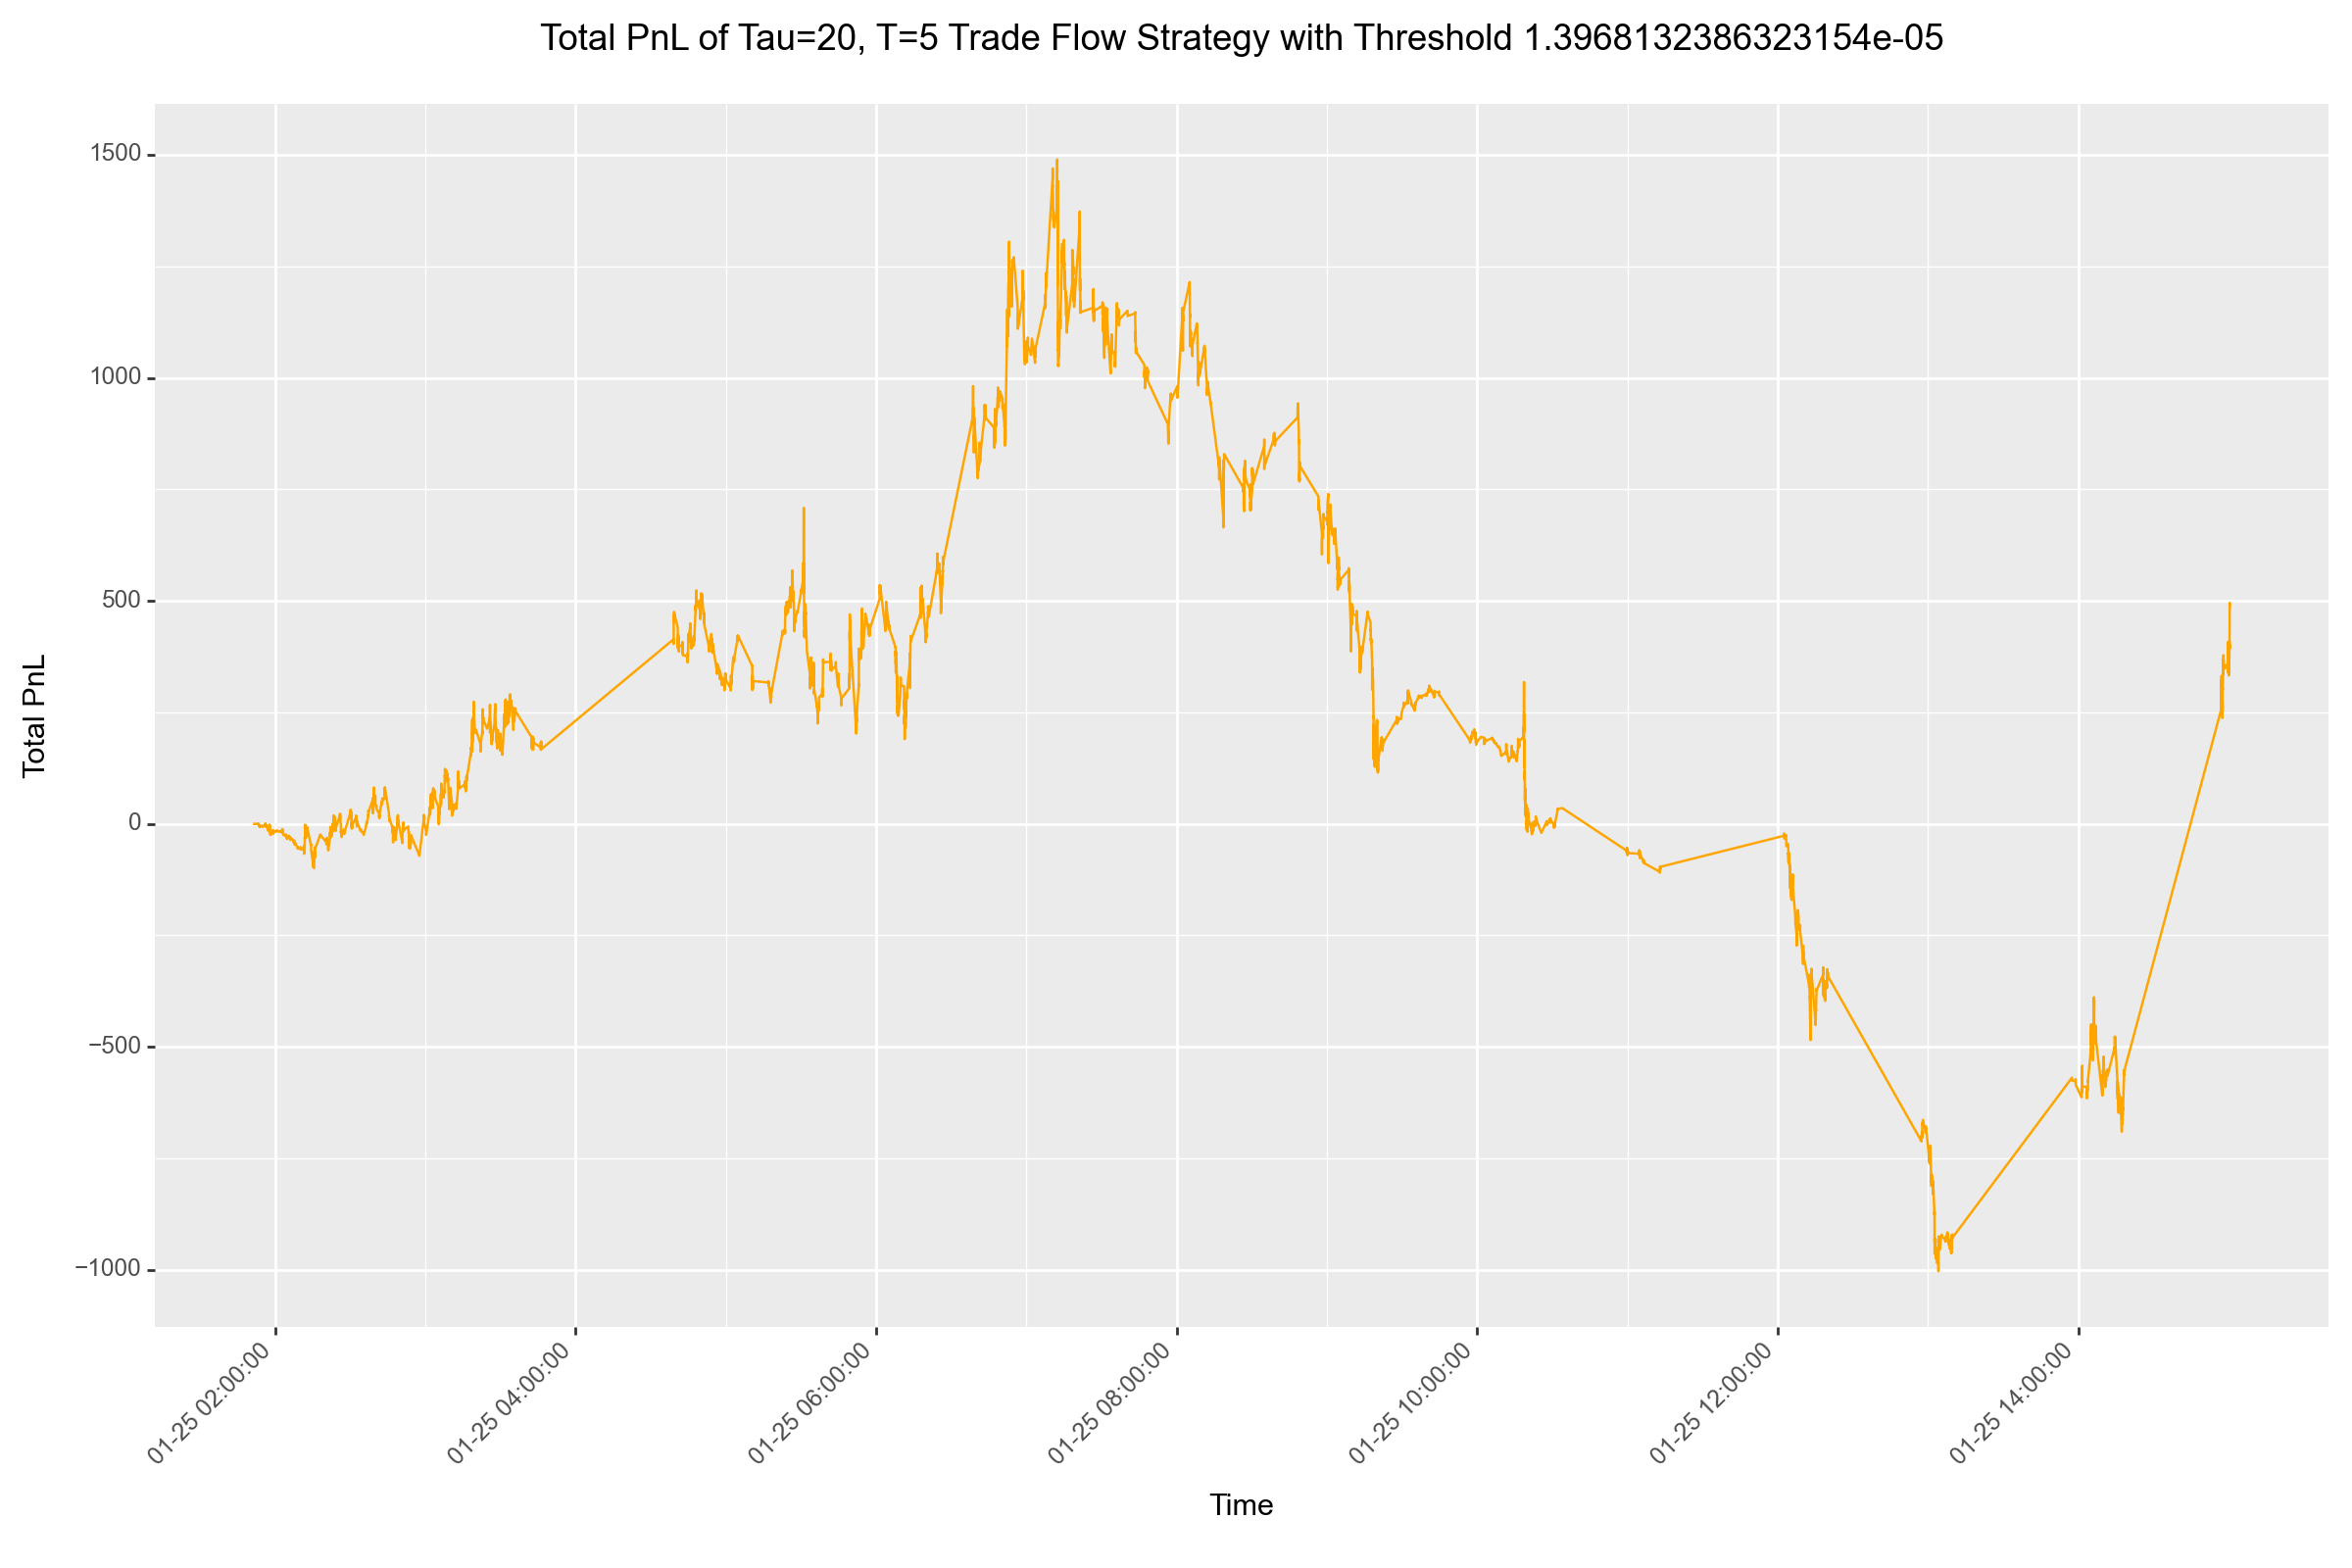

In [123]:
df = second_tau_fourth_T_train_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

second_tau_fourth_T_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title=f'Total PnL of Tau=20, T=5 Trade Flow Strategy with Threshold {threshold}',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

second_tau_fourth_T_attempt_pnl_plot.draw()

#### This has produced the most favorable PnL yet, and we will therefore set it as our optimal parameter value. Additionally, we will add the tau of 20 to our optimal parameters as well.

## Note on optimal parameters:
#### We have to keep in mind that our optimal parameters are not going to be the absolute best for every single set of data or circumstances. They are merely a good estimate at trying to get close to values that will be applicable to future circumstances. We will examine some of the risk metrics that come along with our certain parameters, but before doing that let us see the robustness of our strategy applied to the btc_usd data set instead.

In [132]:
OptimalParameters.T = 5
OptimalParameters.TAU = 20

In [133]:
longer_btc_usd_trade_train, shorter_btc_usd_trade_test = split_data_into_training_and_testing(btc_usd_trade_df, training_cutoff=0.6)

In [134]:
long_consolidated_btc_usd_trade_train = consolidate_by_timestamp(longer_btc_usd_trade_train)
long_trade_flow_btc_usd_trade_train = calculate_trade_flow(long_consolidated_btc_usd_trade_train, OptimalParameters.TAU)
long_finished_btc_usd_trade_train = calculate_forward_returns(long_trade_flow_btc_usd_trade_train, OptimalParameters.T).dropna()

short_consolidated_btc_usd_trade_test = consolidate_by_timestamp(shorter_btc_usd_trade_test)
short_finished_btc_usd_trade_test = calculate_trade_flow(short_consolidated_btc_usd_trade_test, OptimalParameters.TAU).dropna()
short_finished_btc_usd_trade_test.set_index('timestamp', inplace=True)

In [136]:
first_btc_attempt_tfs = TradeFlowStrategy(
    long_finished_btc_usd_trade_train, 
    short_finished_btc_usd_trade_test, 
    10**(-5), 
    0.00001)

first_btc_attempt_tfs.run_strategy()

Running strategy on testing set: 100%|██████████| 149855/149855 [00:50<00:00, 2945.72it/s]


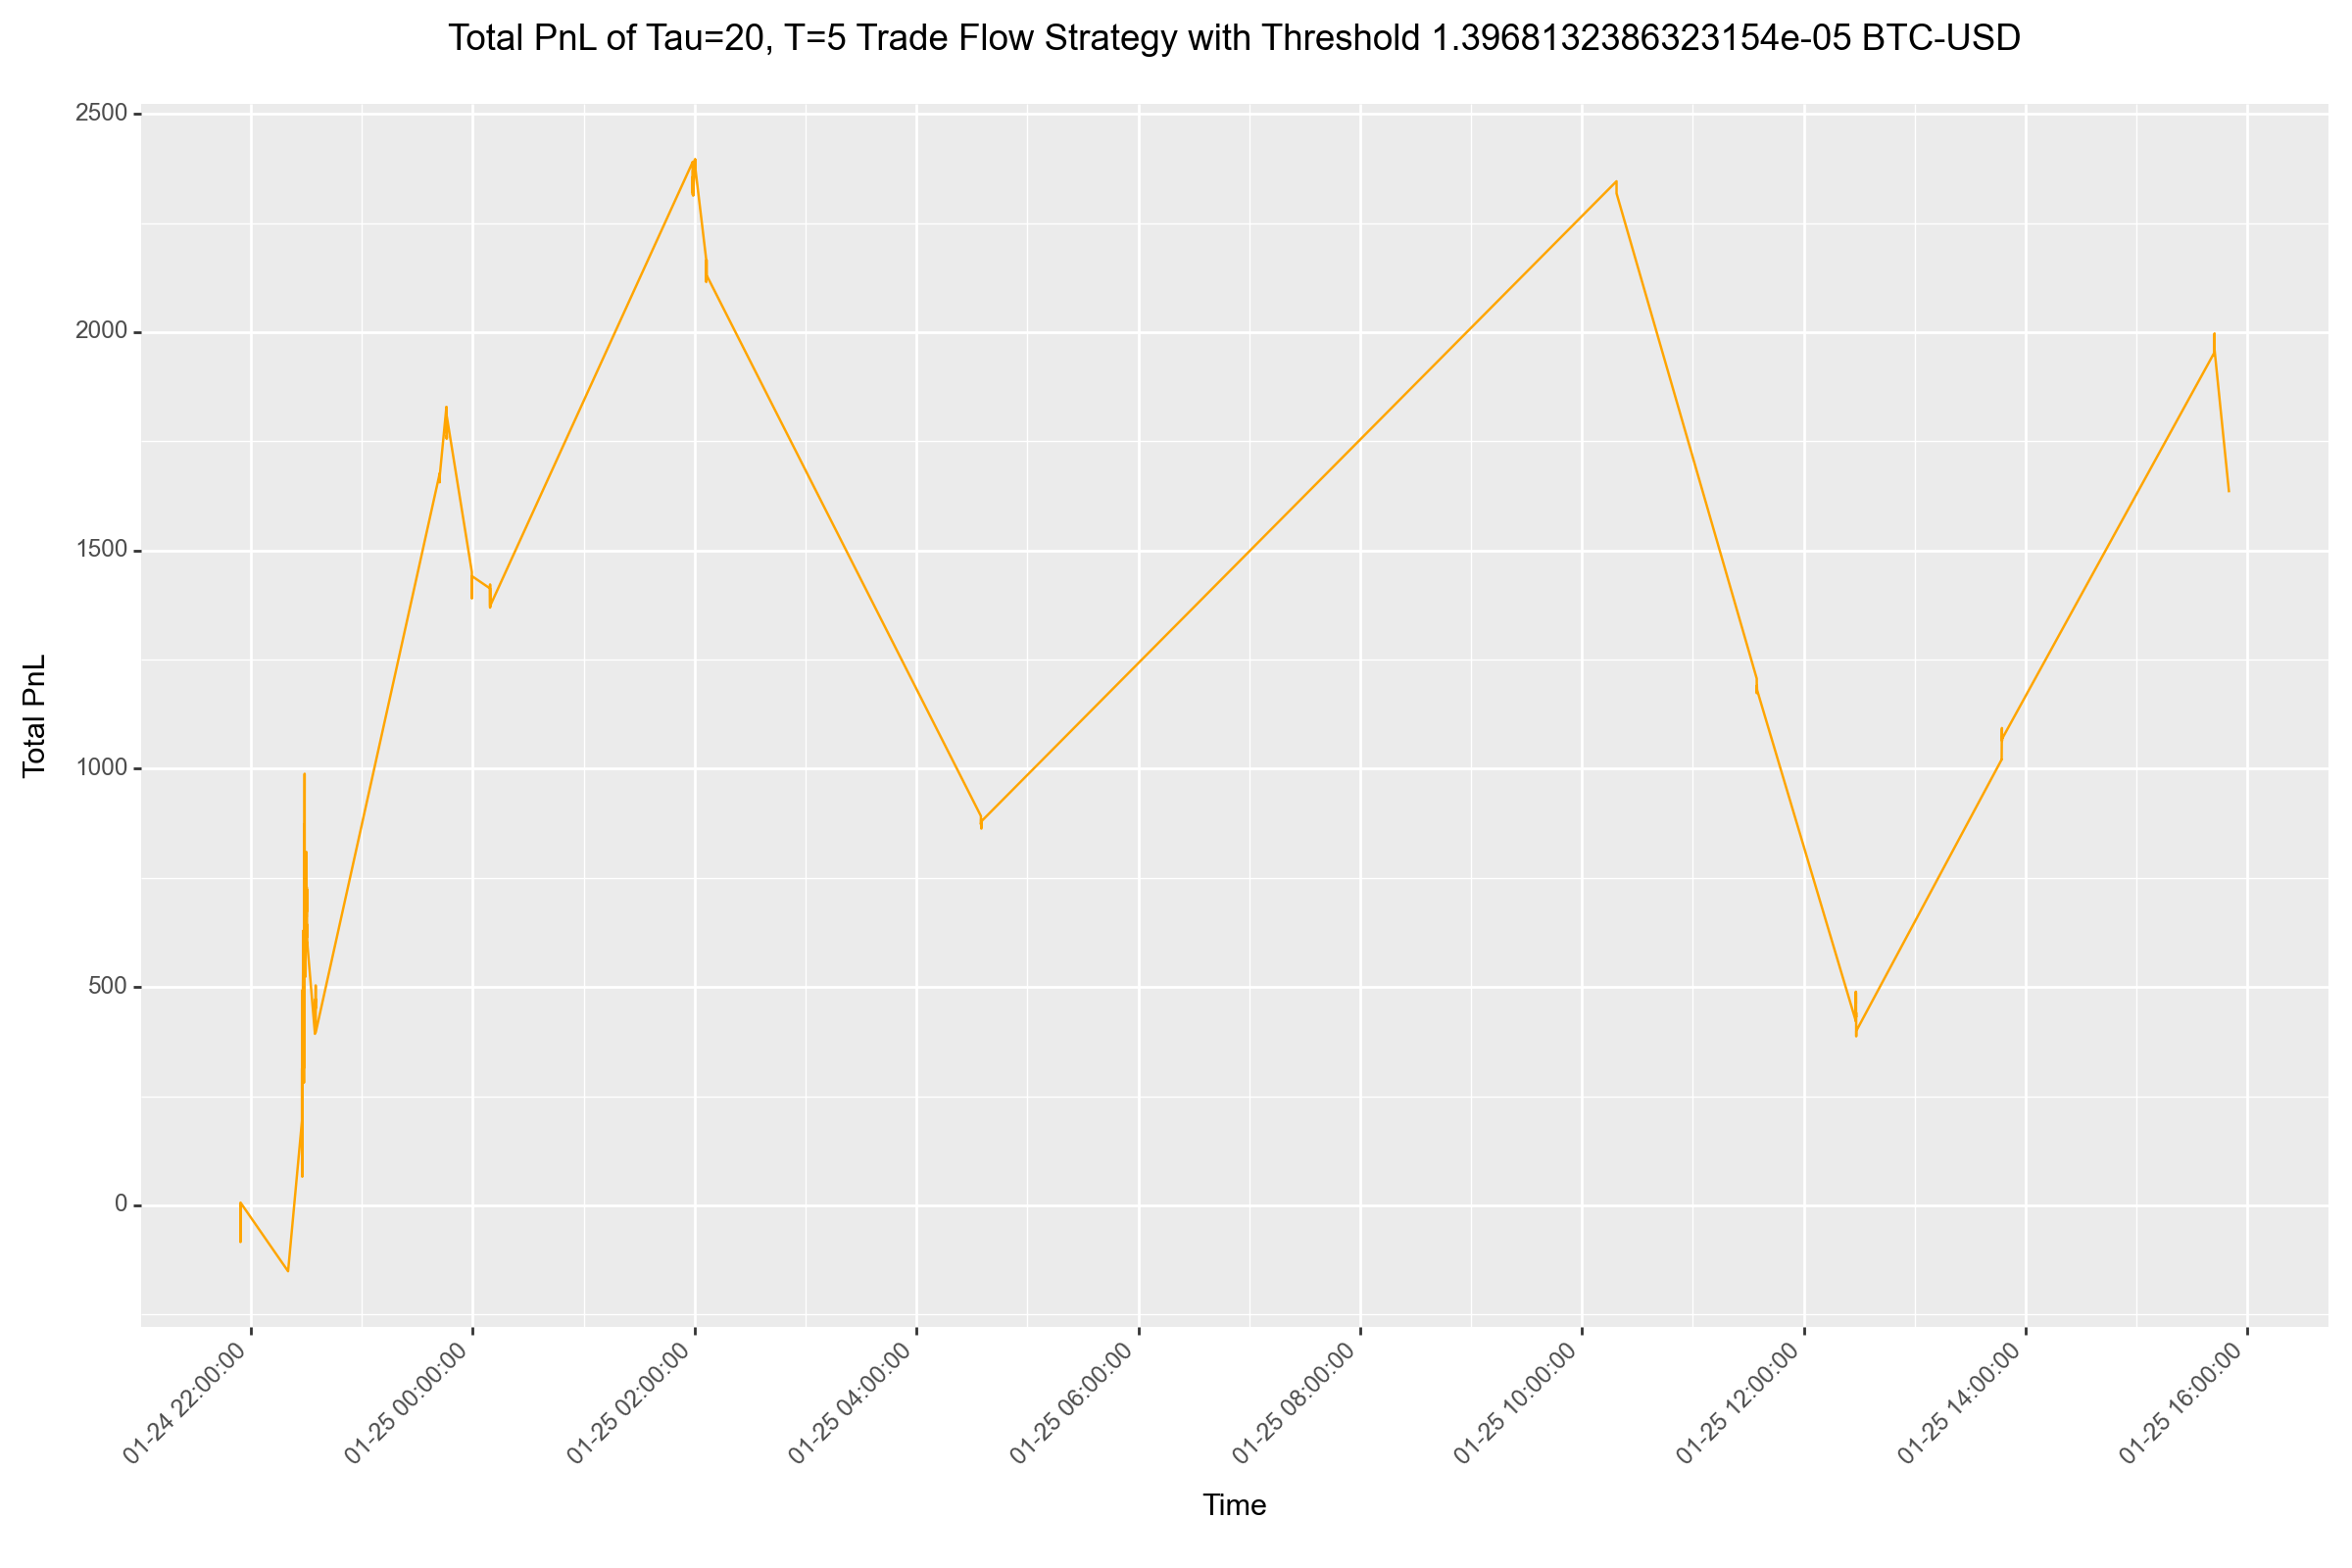

In [137]:
df = first_btc_attempt_tfs.trading_log.copy()
df['timestamp'] = df.index

first_btc_attempt_pnl_plot = (p9.ggplot(df, aes(x='timestamp', y='total_pnl'))
     + p9.geom_line(color='orange')
     + p9.labs(title=f'Total PnL of Tau=20, T=5 Trade Flow Strategy with Threshold {threshold} BTC-USD',
           x='Time',
           y='Total PnL')
     + p9.scale_x_datetime(date_labels='%m-%d %H:%M:%S')
     + p9.theme(figure_size=(12, 8), 
               plot_title=p9.element_text(hjust=0.5),
               axis_text_x=p9.element_text(angle=45, hjust=1))
    )

first_btc_attempt_pnl_plot.draw()

#### This PnL is exactly what we want to see based on our previous analysis. Even though we derived our optimal parameters on the ETH/USD set, we see a promising return and a much higher PnL overall. Let us see if different threshold percentages yield better/worse PnL like was previously seen. We will try a threshold of 5%, 20%, 50%, and 75% to see if BTC has a different trading behavior.

In [143]:
btc_threshold_pct_list = [0.05, 0.20, 0.50, 0.75]
btc_threshold_list = []
test_df = first_btc_attempt_tfs.testing_data

for threshold_pct in btc_threshold_pct_list:
    btc_threshold_list.append(find_threshold_value_by_percentage(test_df, threshold_pct))

In [146]:
btc_threshold_strat_list = []

for threshold in btc_threshold_list:
    tfs = TradeFlowStrategy(
    long_finished_btc_usd_trade_train, 
    short_finished_btc_usd_trade_test,
    threshold, 
    0.00001)
    tfs.run_strategy()
    
    btc_threshold_strat_list.append((tfs, threshold))

Running strategy on testing set: 100%|██████████| 149855/149855 [03:51<00:00, 645.99it/s]


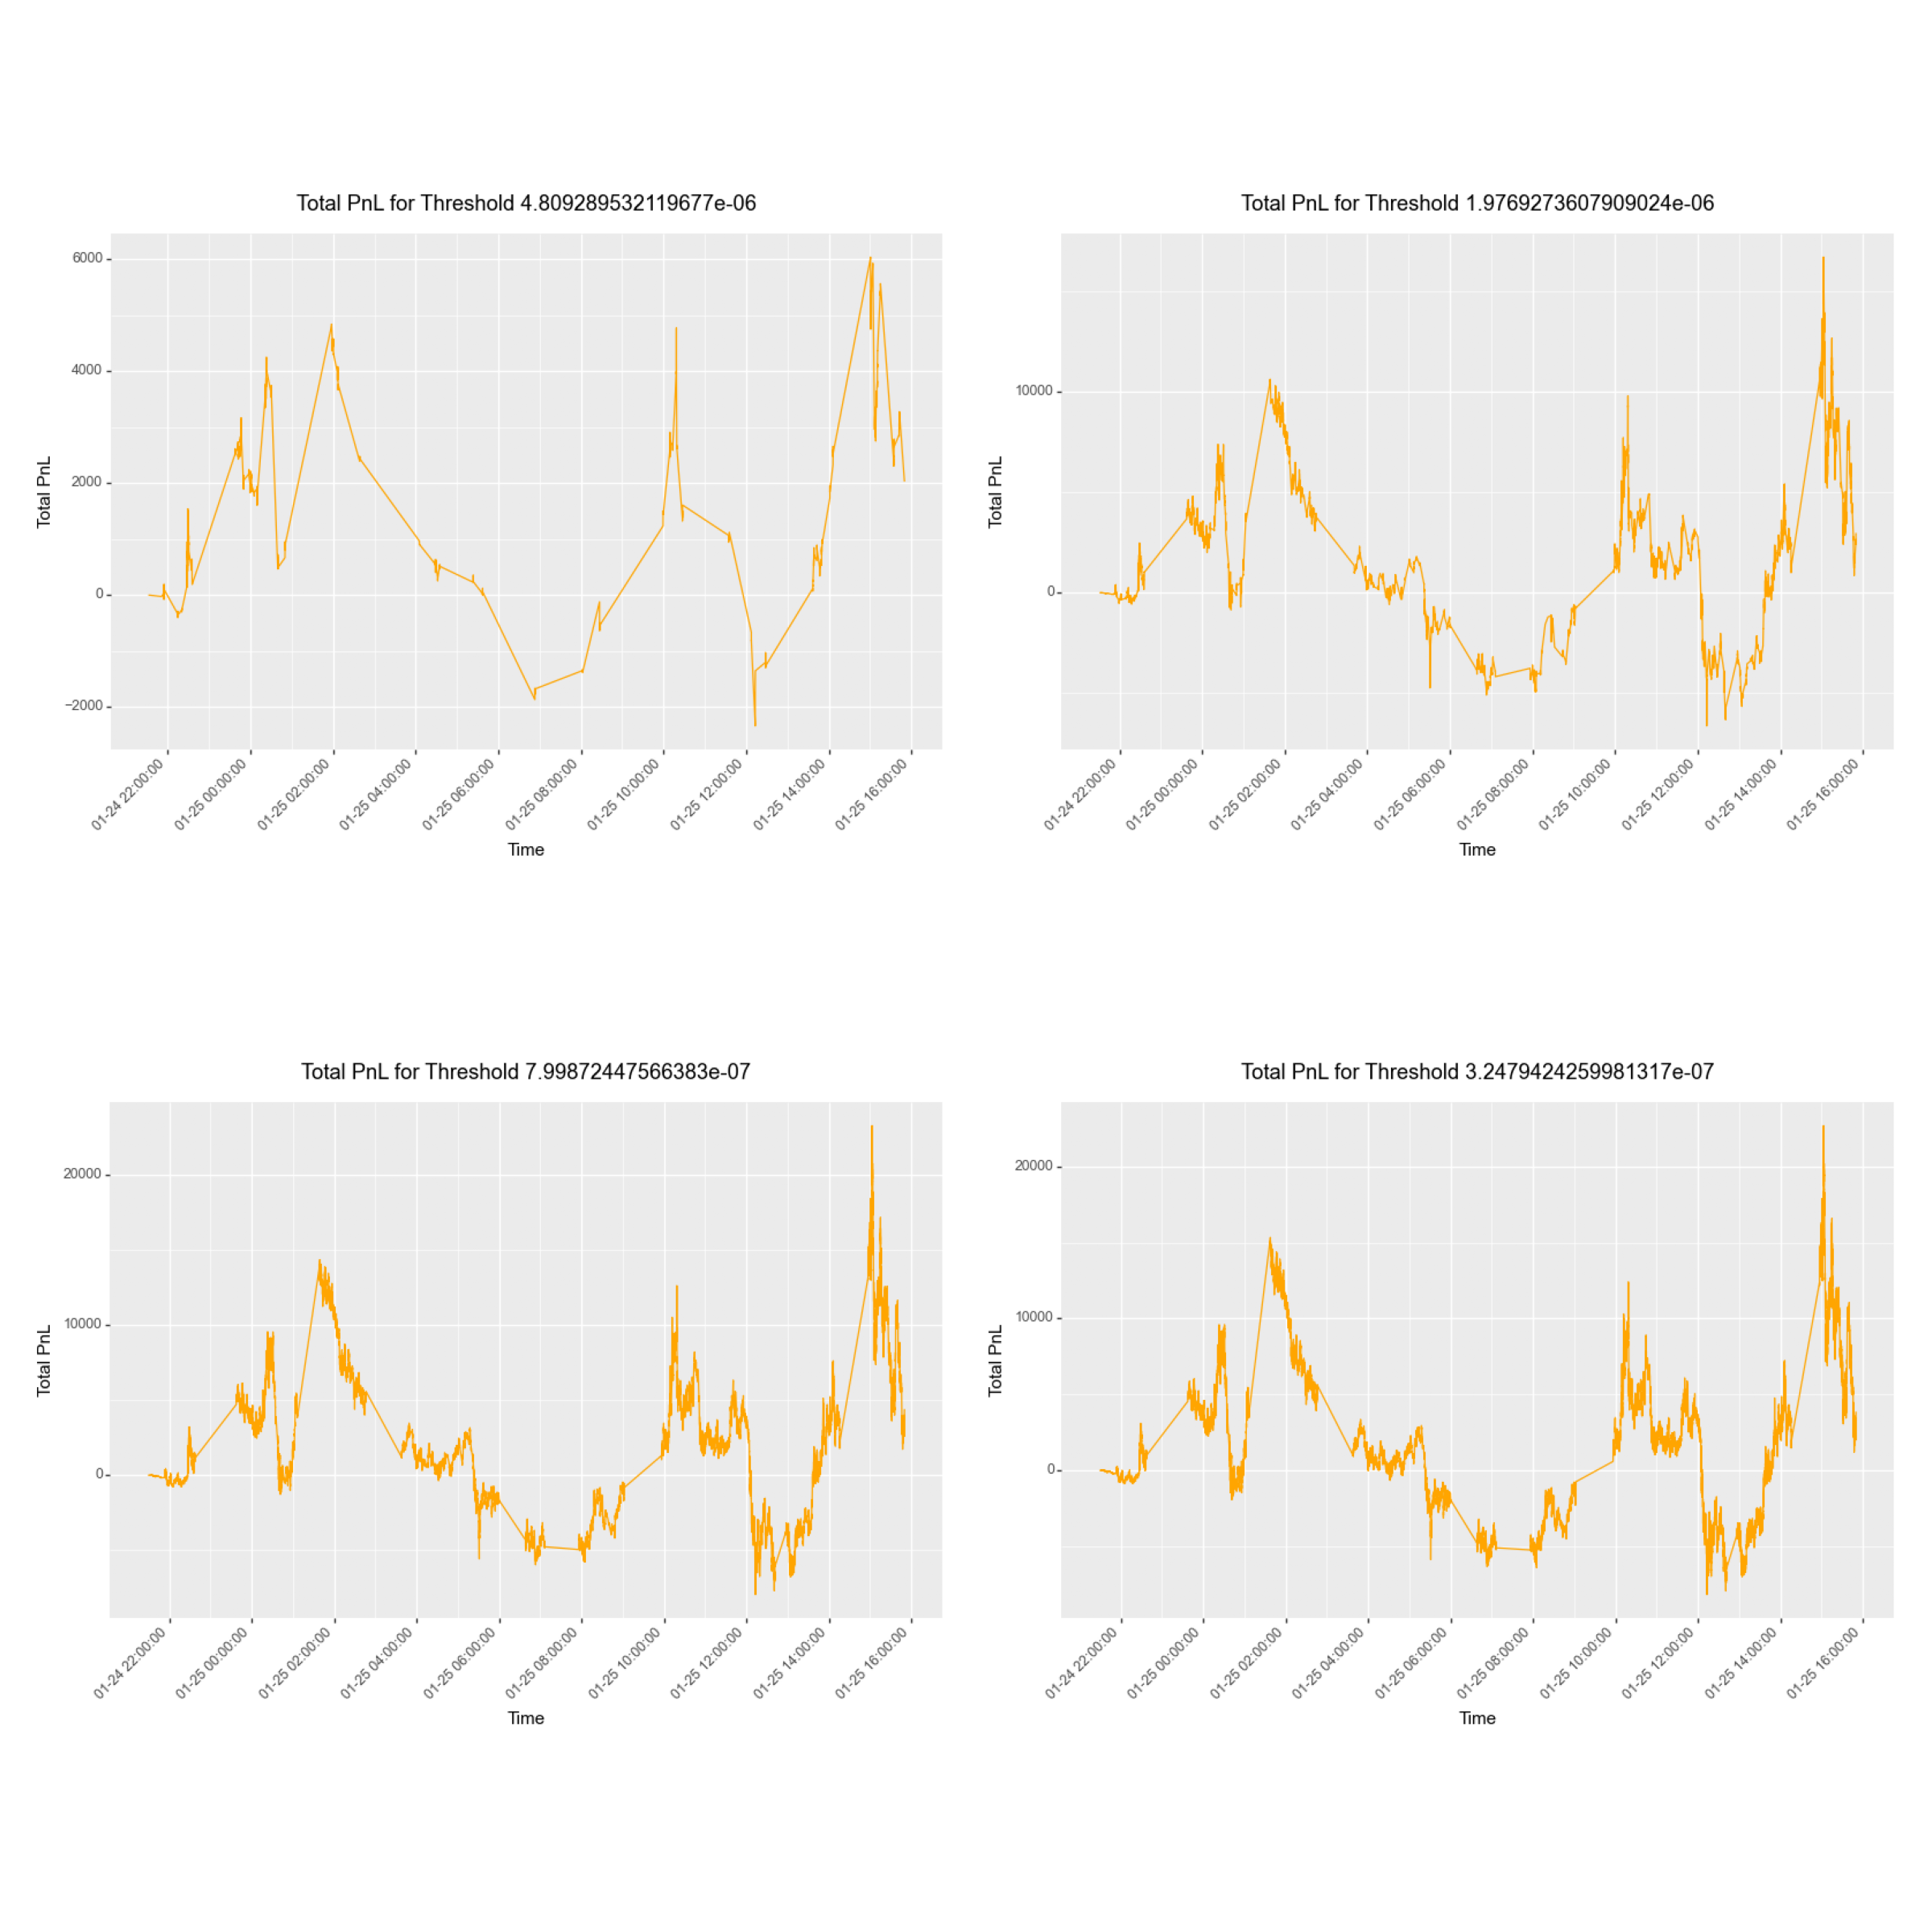

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, ele in enumerate(btc_threshold_strat_list):
    df = ele[0].trading_log
    threshold = ele[1]
    
    image = get_plot_as_image(df, threshold)
    axes[i].imshow(image)
    axes[i].axis('off')


plt.tight_layout()
plt.show()

#### We see that trading more frequently again gives the chance for higher PnL. However, we also see that each of the graphs follows a consistent pattern, suggesting that the best strategy will be based on the risk tolerance of the trader. Therefore, let us observe the risk metrics between the 5% and 20% graphs above to compare the risk necessary for entering into these strategies.

In [158]:
def calculate_risk_metrics(risk_df, confidence_level=0.95):

    # Maximum Drawdown
    prev_high = 0
    max_drawdown = 0
    for i, tot_pnl in risk_df.itertuples():
        prev_high = max(prev_high, tot_pnl)
        dd = tot_pnl - prev_high
        if dd < max_drawdown:
            max_drawdown = dd
    
    # Value at Risk (VaR) - Assuming normal distribution for simplicity
    var = np.percentile(risk_df, (1 - confidence_level) * 100)
    
    # Conditional Value at Risk (CVaR) - Average of losses worse than VaR
    cvar = float(risk_df[risk_df <= var].mean())
    
    sharpe = float(risk_df.mean()/risk_df.std())
    
    # Prepare the result DataFrame
    risk_metrics = pd.DataFrame({
        'Metric': ['Maximum Drawdown', 'VaR', 'CVaR', 'Sharpe Ratio'],
        'Value': [max_drawdown, var, cvar, sharpe]
    })
    
    return risk_metrics

In [159]:
btc_5_pct_threshold_strat = btc_threshold_strat_list[0][0]
btc_20_pct_threshold_strat = btc_threshold_strat_list[1][0]

btc_5_pct_pnl = btc_5_pct_threshold_strat.trading_log.total_pnl.to_frame()
btc_20_pct_pnl = btc_20_pct_threshold_strat.trading_log.total_pnl.to_frame()

btc_5_pct_risk_metrcs = calculate_risk_metrics(btc_5_pct_pnl)
btc_20_pct_risk_metrcs = calculate_risk_metrics(btc_20_pct_pnl)

In [160]:
display(btc_5_pct_risk_metrcs)
display(btc_20_pct_risk_metrcs)

Metric        Value
0  Maximum Drawdown -7172.779206
1               VaR  -323.666908
2              CVaR -1114.094191
3      Sharpe Ratio     1.019408

Metric         Value
0  Maximum Drawdown -17244.035285
1               VaR  -3679.690428
2              CVaR  -4443.990593
3      Sharpe Ratio      0.727298

#### As expected, entering into a higher amount of trading positions yields a higher maximum drawdown. However, we also notice that the Sharpe ratio of the strategy PnL that only entered into 5% of the trades had a higher Sharpe ratio, indicating that the volatility of the riskier strategy produces lower PnL returns. This means that there is a greater downside risk and lower expected mean/std ratio, but again the actual implementation of the strategy is up to the risk-tolerance of the trader. We will test the risk metrics of the 5% and 20% strategy for the ETH-USD strategies, and then summarize our findings in a conclusion.

In [161]:
eth_5_pct_threshold_strat = threshold_strat_list[0][0]
eth_20_pct_threshold_strat = threshold_strat_list[3][0]

eth_5_pct_pnl = eth_5_pct_threshold_strat.trading_log.total_pnl.to_frame()
eth_20_pct_pnl = eth_20_pct_threshold_strat.trading_log.total_pnl.to_frame()

eth_5_pct_risk_metrcs = calculate_risk_metrics(eth_5_pct_pnl)
eth_20_pct_risk_metrcs = calculate_risk_metrics(eth_20_pct_pnl)

In [162]:
display(eth_5_pct_risk_metrcs)
display(eth_20_pct_risk_metrcs)

Metric        Value
0  Maximum Drawdown -1014.425650
1               VaR   -13.538723
2              CVaR   -18.672183
3      Sharpe Ratio     1.444032

Metric        Value
0  Maximum Drawdown -2414.463463
1               VaR  -622.332743
2              CVaR  -803.540132
3      Sharpe Ratio     0.512307

#### While the magnitude of the drawdowns are smaller, this is to be expected due to the fact that Etherium trades at a lower price than Bitcoin. Overall, we see the same trend here, where the Sharpe ratio is better for a trader who chooses to be risk-adverse. Additionally, the maximum drawdown for the risky trader is about the same proportion higher as it was for BTC, indicating that, at the very least, our strategy is consistent between ETH/USD and BTC/USD. This is good, as it could mean that we can generalize our findings to other markets in the crypto space as well as apply the strategy to different time periods (perhaps even on the live market). More analysis would be needed to verify, but overall we have a solid foundation to believe that, with sufficient risk tolerance, this strategy could produce favorable PnL.

## Conclusion:

#### Overall, we were able to find a set of parameters which fit a good trade flow strategy across multiple cryptocurrencies. While this does not indicate that these parameters are the best for every other trading period or set of currencies, we do know that their being generalizable shows a robustness to the strategy implementation and development. Other important findings include:
* Higher thresholds lead to lower total PnL but more favorable risk metrics
* Strategy performance are highly sensitive to differing values of tau but are less subject to drastic swings when switching the value of T
* Risk tolerance could capture more PnL, but the volatility of these lower thresholds introduce much bigger drawdowns and lower Sharpe ratios

#### To further explore the efficacy of this strategy, several directions can be taken to try to expand PnL opportunity. One of the most immediate is to add a percentage stop loss into the strategy to liquidate the position when the market is going against your bottom line. This will lead to a more immediate loss in PnL but may reduce some of the drastic drawdowns (and therefore increase PnL performance overall). This obviously presents some challenges to implement, as we do not know the actual trade fluctuations when trading in the open market. Therefore, we will have a look ahead bias on our chosen stop loss value and can lose out on some nice PnL opportunities due to this caution. Another avenue to explore is a more fine-tuned combination of metrics to see if different parameters behave more favorably when varied simultaneously. This did not seem to be the case in our above analysis, but implementing an optimized approach to finding general parameters is essential to taking our strategy from the backtesting stage to the open markets.